<a href="https://colab.research.google.com/github/MoonJaeHoon/Dacon_Behavioral_Data_Analysis/blob/master/Ch5.3_Permutation_Importance_%26_RF%EB%B3%80%EC%88%98%EC%A4%91%EC%9A%94%EB%8F%84_%EB%AA%A8%EB%8D%B8%EB%A7%8141.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install optuna==0.18.1

     |████████████████████████████████| 122kB 3.4MB/s 
     |████████████████████████████████| 1.1MB 10.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 9.1MB/s 
     |████████████████████████████████| 81kB 9.8MB/s 
     |████████████████████████████████| 112kB 22.4MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=a702fe37963e5f7240b1a401829121de9f8abd87080bd5a6ca0092af8f8047af
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-0.18.1-cp36-none-any.whl size=165106 sha256=75116afe5ca0704c0a2133257e7edc54dd454c6b2ed5d2e505eee0db92658e39
  Stored in directory: /root/.cache/pip/wheels/40/

In [0]:
import os
print( '변경 전 기본 경로 :' )
print(  os.getcwd() )
os.chdir('./drive/My Drive/데이콘_게임데이터분석')
print( '변경 후 파일 경로 :' )
print(  os.getcwd()  )


import optuna                               # 베이지안 최적화 라이브러리  
from optuna import Trial
import gc
debug = False
import numpy as np
import pandas as pd

from tqdm import tqdm_notebook              # 진행바
from sklearn.metrics import roc_auc_score   # AUC 스코어 계산
from sklearn.model_selection import KFold   # K-fold CV    
from functools import partial               # 함수 변수 고정
import lightgbm as lgb                      # LightGBM 라이브러리
import warnings                             
warnings.filterwarnings("ignore")           # 경고 문구 미표시
%time
train16 = pd.read_pickle('train16.pkl')

%time
test16 = pd.read_pickle('test16.pkl')

변경 전 기본 경로 :
/content
변경 후 파일 경로 :
/content/drive/My Drive/데이콘_게임데이터분석


## 루트변환 or 로그변환후 생성하기, 종족 변수 인코딩

## Train Set diff생성 (apply 적용)

In [0]:
######################################### 종족 인코딩하기 ########################################
def spec_convert(x):
    if x[0] == 'Z':
        return 2
    elif x[0] == 'P':
        return 1
    else:
        return 0

train16['P0_species']=train16.apply(lambda x: spec_convert(x['P0_species']),axis=1)
train16['P1_species']=train16.apply(lambda x: spec_convert(x['P1_species']),axis=1)

################################ 결측치가 있는 column & 사용 안할 column들 제거해놓기 ######################
no_missing_train0 = train16.drop(['player0_starting_category','player1_starting_category','player0_center_x','player0_center_y','player1_center_x','player1_center_y',]
                                , axis=1)

################################## 종족이라는 변수는 빼고 P0와 P1간의 차이를 구할 거기 때문에 ##########################
columns = pd.Series(no_missing_train0.columns)
columns.index = no_missing_train0.columns.tolist()
columns = columns.drop(['P0_species','P1_species','map'])
columns = columns.tolist()

#################### 범주형 변수들 ################# (종족은 순서형으로 봐야될지도 확인ㄱㄱㄱ)
cat_features = ['P0_species','P1_species','map']

####################### P0를 포함하는 컬럼, P1을 포함하는 컬럼 #################################
p0_columns = [c for c in columns if c.startswith('P0_')]
p1_columns = [c for c in columns if c.startswith('P1_')]

####################################### diff변수 생성 전에 루트변환? (카운팅은 높을수록 서로간의 차이가 의미가 없으므로) ##############################
from math import log
from math import sqrt
import re
diff_feat_list = []

for rawfeat0, rawfeat1 in zip(p0_columns,p1_columns):
  #no_missing_train0[rawfeat0]  =  no_missing_train0.apply(lambda x: sqrt(x[rawfeat0]),axis=1) 
  #no_missing_train0[rawfeat1]  =  no_missing_train0.apply(lambda x: sqrt(x[rawfeat1]),axis=1) 
  diff_feat = 'diff_'+ re.sub('P0_','', rawfeat0)
  diff_feat_list.append(diff_feat)
  no_missing_train0[diff_feat]  =  no_missing_train0.apply(lambda x: (x[rawfeat1]-x[rawfeat0]), axis=1)

################################# diff 변수 생성 후 본래 P0, P1 컬럼 없애기 #######################

#no_missing_train0 = no_missing_train0.drop(p0_columns+p1_columns,axis=1)

no_missing_train0.describe()


P0_Ability_bytime_0  ...  diff_Click_Multi_bytime_10
count         38872.000000  ...                38872.000000
mean              7.431467  ...                   -0.038537
std               2.544722  ...                    4.552791
min               0.000000  ...                  -97.000000
25%               6.000000  ...                   -1.000000
50%               7.000000  ...                    0.000000
75%               9.000000  ...                    1.000000
max              52.000000  ...                   77.000000

[8 rows x 599 columns]

## Test Set diff생성 (apply 적용)

In [0]:
def spec_convert(x):
    if x[0] == 'Z':
        return 2
    elif x[0] == 'P':
        return 1
    else:
        return 0

test16['P0_species']=test16.apply(lambda x: spec_convert(x['P0_species']),axis=1)
test16['P1_species']=test16.apply(lambda x: spec_convert(x['P1_species']),axis=1)

################################ 결측치가 있는 column & 사용 안할 column들 제거해놓기 ######################
no_missing_test = test16.drop(['player0_starting_category','player1_starting_category','player0_center_x','player0_center_y','player1_center_x','player1_center_y',]
                                , axis=1)

################################## 종족이라는 변수는 빼고 P0와 P1간의 차이를 구할 거기 때문에 ##########################
columns = pd.Series(no_missing_test.columns)
columns.index = no_missing_test.columns.tolist()
columns = columns.drop(['P0_species','P1_species','map'])
columns = columns.tolist()

#################### 범주형 변수들 ################# (종족은 순서형으로 봐야될지도 확인ㄱㄱㄱ)
cat_features = ['P0_species','P1_species','map']

####################### P0를 포함하는 컬럼, P1을 포함하는 컬럼 #################################
p0_columns = [c for c in columns if c.startswith('P0_')]
p1_columns = [c for c in columns if c.startswith('P1_')]

####################################### diff변수 생성 전에 루트변환? (카운팅은 높을수록 서로간의 차이가 의미가 없으므로) ##############################
from math import log
from math import sqrt
import re
diff_feat_list = []

for rawfeat0, rawfeat1 in zip(p0_columns,p1_columns):
  #no_missing_test[rawfeat0]  =  no_missing_test.apply(lambda x: sqrt(x[rawfeat0]),axis=1) 
  #no_missing_test[rawfeat1]  =  no_missing_test.apply(lambda x: sqrt(x[rawfeat1]),axis=1) 
  diff_feat = 'diff_'+ re.sub('P0_','', rawfeat0)
  diff_feat_list.append(diff_feat)
  no_missing_test[diff_feat]  =  no_missing_test.apply(lambda x: (x[rawfeat1]-x[rawfeat0]), axis=1)

################################# diff 변수 생성 후 본래 P0, P1 컬럼 없애기 #######################

#no_missing_test = no_missing_test.drop(p0_columns+p1_columns,axis=1)

no_missing_test.describe()

P0_Ability_bytime_0  ...  diff_Click_Multi_bytime_10
count         16787.000000  ...                16787.000000
mean              7.397093  ...                   -0.013225
std               2.508546  ...                    4.505719
min               0.000000  ...                  -85.000000
25%               6.000000  ...                   -1.000000
50%               7.000000  ...                    0.000000
75%               9.000000  ...                    1.000000
max              30.000000  ...                   50.000000

[8 rows x 598 columns]

In [0]:
train_Ability_Raw = pd.read_pickle('train_Ability_Raw.pkl')
test_Ability_Raw = pd.read_pickle('test_Ability_Raw.pkl')

train_Ability2 = pd.read_pickle('train_Ability2.pkl')
train_Ability4 = pd.read_pickle('train_Ability4.pkl')
train_Ability6 = pd.read_pickle('train_Ability6.pkl')
train_Ability8 = pd.read_pickle('train_Ability8.pkl')
train_Ability10 = pd.read_pickle('train_Ability10.pkl')
train_Ability12 = pd.read_pickle('train_Ability12.pkl')
train_Ability = pd.concat([train_Ability2,train_Ability4,train_Ability6,train_Ability8,train_Ability10,train_Ability12],axis=1)
del train_Ability2,train_Ability4,train_Ability6,train_Ability8,train_Ability10,train_Ability12

test_Ability2 = pd.read_pickle('test_Ability2.pkl')
test_Ability4 = pd.read_pickle('test_Ability4.pkl')
test_Ability6 = pd.read_pickle('test_Ability6.pkl')
test_Ability8 = pd.read_pickle('test_Ability8.pkl')
test_Ability10 = pd.read_pickle('test_Ability10.pkl')
test_Ability12 = pd.read_pickle('test_Ability12.pkl')
test_Ability = pd.concat([test_Ability2,test_Ability4,test_Ability6,test_Ability8,test_Ability10,test_Ability12],axis=1)
del test_Ability2,test_Ability4,test_Ability6,test_Ability8,test_Ability10,test_Ability12

train_Selection_Raw = pd.read_pickle('train_Selection_Raw.pkl')
test_Selection_Raw = pd.read_pickle('test_Selection_Raw.pkl')

train_Selection2 = pd.read_pickle('train_Selection2.pkl')
train_Selection4 = pd.read_pickle('train_Selection4.pkl')
train_Selection6 = pd.read_pickle('train_Selection6.pkl')
train_Selection8 = pd.read_pickle('train_Selection8.pkl')
train_Selection10 = pd.read_pickle('train_Selection10.pkl')
train_Selection12 = pd.read_pickle('train_Selection12.pkl')
train_Selection = pd.concat([train_Selection2,train_Selection4,train_Selection6,train_Selection8,train_Selection10,train_Selection12],axis=1)
del train_Selection2,train_Selection4,train_Selection6,train_Selection8,train_Selection10,train_Selection12

test_Selection2 = pd.read_pickle('test_Selection2.pkl')
test_Selection4 = pd.read_pickle('test_Selection4.pkl')
test_Selection6 = pd.read_pickle('test_Selection6.pkl')
test_Selection8 = pd.read_pickle('test_Selection8.pkl')
test_Selection10 = pd.read_pickle('test_Selection10.pkl')
test_Selection12 = pd.read_pickle('test_Selection12.pkl')
test_Selection = pd.concat([test_Selection2,test_Selection4,test_Selection6,test_Selection8,test_Selection10,test_Selection12],axis=1)
del test_Selection2,test_Selection4,test_Selection6,test_Selection8,test_Selection10,test_Selection12

train_Right_Raw = pd.read_pickle('train_Right_Raw.pkl')
test_Right_Raw = pd.read_pickle('test_Right_Raw.pkl')
train_Right = pd.read_pickle('train_Right.pkl')
test_Right = pd.read_pickle('test_Right.pkl')
#train_Camera = pd.read_pickle('train_Camera_10단위.pkl')
#test_Camera = pd.read_pickle('test_Camera_10단위.pkl')

train_Ability_Raw = train_Ability_Raw.add_prefix('Ability_Raw_')
test_Ability_Raw = test_Ability_Raw.add_prefix('Ability_Raw_')
train_Selection_Raw = train_Selection_Raw.add_prefix('Selection_Raw_')
test_Selection_Raw = test_Selection_Raw.add_prefix('Selection_Raw_')
train_Right_Raw = train_Right_Raw.add_prefix('Right_Raw_')
test_Right_Raw = test_Right_Raw.add_prefix('Right_Raw_')

train_Ability = train_Ability.add_prefix('Ability_')
test_Ability = test_Ability.add_prefix('Ability_')
train_Selection = train_Selection.add_prefix('Selection_')
test_Selection = test_Selection.add_prefix('Selection_')
train_Right = train_Right.add_prefix('Right_')
test_Right = test_Right.add_prefix('Right_')

print(train_Ability_Raw.shape)
print(train_Ability.shape)
print(train_Selection_Raw.shape)
print(train_Selection.shape)
print(train_Right_Raw.shape)
print(train_Right.shape)


(38872, 1507)
(38872, 4087)
(38872, 2491)
(38872, 1590)
(38872, 1552)
(38872, 336)


# Feature Selection

In [0]:
import lightgbm as lgb
#LGBMC = lgb.LGBMClassifier(n_estimators=100, n_jobs=-1)
#LGBMC.fit(x_train, y_train)
no_missing_train = pd.concat([no_missing_train0,train_Ability_Raw, train_Ability, train_Selection_Raw, train_Selection , train_Right_Raw, train_Right
                              ], axis=1)
x = no_missing_train.drop(['winner'],axis=1)
y = no_missing_train['winner']

del no_missing_train,train_Ability_Raw, train_Ability, train_Selection_Raw, train_Selection, train_Right_Raw, train_Right
x.shape

(38872, 12161)

In [0]:
test_Ability_Raw.index = no_missing_test.index
test_Ability.index = no_missing_test.index
test_Selection_Raw.index =  no_missing_test.index
test_Selection.index = no_missing_test.index
test_Right_Raw.index =  no_missing_test.index
test_Right.index = no_missing_test.index
#test_concat = pd.concat([no_missing_test,test_Ability_Raw,test_Ability,
#                    test_Selection_Raw,test_Selection,
#                    test_Right_Raw, test_Right],axis=1).copy()

#print(test_concat.shape)
print(len(x.columns))
print(len(x.columns.unique()))
#print(len(test_concat.columns))
#print(len(test_concat.columns.unique()))
#(test_concat.columns.sort_values() == x.columns.sort_values()).all()
#del test_concat

12161
12161


In [0]:
#x = no_missing_train.drop(['winner'],axis=1)
#y = no_missing_train['winner']
from sklearn.model_selection import train_test_split
tr_X, val_X, tr_y, val_y = train_test_split(x, y,   stratify=y, random_state=42)
cat_features = ['P0_species','P1_species','map']

params = {
    'objective': 'binary',
    'max_depth': -1,  # 18,20,-1,30,25,15,13, 11,12,10
    'learning_rate': 0.01, 
    "boosting": "gbdt",#'dart','goss',
    "metric": "auc",
    "verbosity": -1,
    'seed':0,
    'n_jobs':-1,
}
d_train = lgb.Dataset(tr_X, label=tr_y, categorical_feature=cat_features)
d_valid = lgb.Dataset(val_X, label=val_y, categorical_feature=cat_features)
watchlist = [d_train, d_valid]

print('training LGB:')
model = lgb.train(params,
                    train_set=d_train,
                    num_boost_round=10000,
                    valid_sets=watchlist,
                    verbose_eval=500,
                    early_stopping_rounds=750,
                    )

# predictions
#y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration,cat_features=cat_features)
del tr_X, val_X, tr_y, val_y, d_train, d_valid, watchlist

training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.816815	valid_1's auc: 0.723624
[1000]	training's auc: 0.887663	valid_1's auc: 0.729385
[1500]	training's auc: 0.931312	valid_1's auc: 0.730314
[2000]	training's auc: 0.958193	valid_1's auc: 0.730978
[2500]	training's auc: 0.97465	valid_1's auc: 0.73155
[3000]	training's auc: 0.984578	valid_1's auc: 0.731734
[3500]	training's auc: 0.990673	valid_1's auc: 0.731824
[4000]	training's auc: 0.994327	valid_1's auc: 0.731924
[4500]	training's auc: 0.996508	valid_1's auc: 0.731554
Early stopping, best iteration is:
[3831]	training's auc: 0.993355	valid_1's auc: 0.732185


# 1. Permutation Importance 기법 적용 전, RandomForest 보고 영향력이 적은 변수 제거
* 여러가지 seed로 RF 적합시키면서 하위 중요도 변수는 안좋은 변수로 판단하기
* RF들로부터 나온 변수중요도의 평균을 기준으로 => rf_bad_feature 선별

mydata = pd.read_pickle('permutation_importance_colname구별되게_42_1000.pkl')
threshold = 1e-8
mydata['mean_scores'] = mydata.apply(np.mean,axis=1)
mean_scores = mydata.apply(np.mean,axis=1)
myindex = np.where(mean_scores>mydata.loc['base_score','mean_scores'] + threshold)[0]
bad_features = mean_scores.index[myindex].tolist()
try:
    bad_features.remove('P0_species')
except:
    pass
try:
    bad_features.remove('P1_species')
except:
    pass
try:
    bad_features.remove('map')
except:
    pass
del mydata

In [0]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
seed_list = [0,42,128,300,600,1024]
#for_rf_x = x.copy()
rf_feat_import = pd.DataFrame(index = x.columns)

from tqdm import tqdm_notebook
for seed in tqdm_notebook(seed_list):
    rf = RandomForestClassifier(n_estimators=5000, random_state=seed, verbose=0.1,n_jobs=-1).fit(x, y)
    rf_feat_import['seed_'+str(seed)] = rf.feature_importances_.tolist()

rf_feat_import['mean_scores'] = rf_feat_import.apply(np.mean,axis=1)
print(rf_feat_import.shape)

#rf_feat_import.to_pickle('RandomForest_importance_시간나눈후.pkl')
#rf_feat_import = pd.read_pickle('RandomForest_importance_시간나눈후.pkl')
rf_feat_import.head()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 527 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 943 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 1478 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 2131 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 2903 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 3794 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done 4804 tasks      | elapsed: 35.0min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 36.4min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 527 tasks      | elapsed:  3.7min
[Parallel(n_jobs


(12161, 7)


seed_0   seed_42  ...  seed_1024  mean_scores
P0_Ability_bytime_0  0.000573  0.000578  ...   0.000577     0.000579
P0_Ability_bytime_2  0.000745  0.000776  ...   0.000775     0.000766
P0_Ability_bytime_4  0.001002  0.001003  ...   0.001021     0.001010
P0_Ability_bytime_6  0.001117  0.001098  ...   0.001115     0.001115
P0_Ability_bytime_8  0.001133  0.001159  ...   0.001153     0.001154

[5 rows x 7 columns]

In [0]:
#rf_feat_import.to_pickle('RandomForest_importance_시간나눈후.pkl')
rf_feat_import = pd.read_pickle('RandomForest_importance_시간나눈후.pkl')

In [0]:
(rf_feat_import.index == x.columns).all()

True

In [0]:
## X.shape (38872, 12161) : Score 0.732185

## 제거 1000개 : Score after removing bad_features: 0.73219, amount of features: 11161
## 제거 2000개 : Score after removing bad_features: 0.73306, amount of features: 10161
## 제거 2500개 : Score after removing bad_features: 0.73165, amount of features: 9661

## 제거 3000개 : Score after removing bad_features: 0.73176, amount of features: 9161
## 제거 3500개 : Score after removing bad_features: 0.73165, amount of features: 8661
## 제거 4000개 : Score after removing bad_features: 0.7306, amount of features: 8161
## 제거 4500개 : Score after removing bad_features: 0.7313, amount of features: 7661
## 제거 5000개 : Score after removing bad_features: 0.73087, amount of features: 7161
## 제거 개 : 

## 5e-7 :                   Score after removing bad_features: 0.7509, amount of features: 6021
## 1e-8 :                   Score after removing bad_features: 0.7509, amount of features: 5948
## RandomForest 변수 제거 : Score after removing bad_features: 0.751236, amount of features: 4948

from sklearn.metrics import roc_auc_score
metric = roc_auc_score
length = 2000

rf_bad_features = rf_feat_import.sort_values(by=['mean_scores'], axis=0, ascending=False).iloc[-length:].index.tolist()

print('P0_species 변수','P0_species' in rf_bad_features)
print('P1_species 변수','P1_species' in rf_bad_features)
print('map 변수','map' in rf_bad_features)
print('time_list 변수','time_list' in rf_bad_features)

try:
    rf_bad_features.remove('P0_species')
except:
    pass
try:
    rf_bad_features.remove('P1_species')
except:
    pass
try:
    rf_bad_features.remove('map')
except:
    pass

print(len(rf_bad_features))

# 2. Customized function : Permutation Importance

In [0]:
#x.to_pickle('모델링41_x.pkl')
#y.to_pickle('모델링41_y.pkl')
x = pd.read_pickle('모델링41_x.pkl')
y = pd.read_pickle('모델링41_y.pkl')


In [0]:
rf_bad_features = ['Ability_Time_10_player1_fightermode', 'Ability_Time_10_player1_cancelupgradetolair', 'Ability_Time_10_player1_orbitalcommandflying', 'Ability_Time_4_player1_zealot', 'Ability_Time_2_player0_hatchery', 'Ability_Time_8_player0_sprayzerg', 'Ability_Time_12_player0_sprayzerg', 'Selection_Time_12_player0_overlordgeneratecreepkeybind', 'Ability_Time_12_player0_creeptumorqueen', 'Ability_Time_10_player0_morphswarmhost', 'Ability_Time_6_player0_egg', 'Selection_Time_12_player0_factoryreactor', 'Ability_Time_4_player1_uprootspinecrawler', 'Ability_Time_6_player1_baneling', 'Ability_Time_12_player1_cancelupgradetolair', 'Ability_Time_12_player0_vikingassault', 'Ability_Time_10_player0_bypassarmordrone', 'Right_player1_colossus', 'Selection_Time_10_player0_overlordgeneratecreepkeybind', 'Ability_Time_10_player0_upgradeterraninfantryweapons2', 'Ability_Time_10_player1_buildnyduscanal', 'Ability_Time_6_player0_evolveglialreconstitution', 'Selection_Time_6_player0_ghost', 'Selection_Time_12_player1_overlordgeneratecreepkeybind', 'Ability_Time_12_player0_starport', 'Selection_Time_10_player0_factoryreactor', 'Ability_Time_12_player1_voidray', 'Ability_Time_10_player0_destructibleice2x4horizontal', 'Ability_Time_8_player0_assaultmode', 'Selection_Time_6_player0_droneburrowed', 'Right_player1_nydusworm', 'Selection_Time_12_player1_changelingzealot', 'Ability_Time_12_player1_sprayterran', 'Ability_Time_10_player0_commandcenter', 'Ability_Time_10_player0_evolvetunnelingclaws', 'Selection_Time_12_player1_factoryreactor', 'Ability_Time_8_player0_marauder', 'Ability_Time_10_player1_sprayterran', 'Selection_Time_6_player0_hydraliskden', 'Ability_Time_10_player1_raven', 'Ability_Time_6_player1_unloadallcommandcenter', 'Ability_Time_12_player0_cancelupgradetoorbitalcommand', 'Ability_Time_8_player1_prismaticalignment', 'Selection_Time_6_player0_sporecrawleruprooted', 'Selection_Time_6_player1_broodling', 'Ability_Time_12_player0_morphswarmhost', 'Ability_Time_4_player1_loadallcommandcenter', 'Ability_Time_8_player1_xelnagatower', 'Ability_Time_4_player1_rootspinecrawler', 'Ability_Time_12_player0_evolutionchamber', 'Ability_Time_10_player0_starport', 'Ability_Time_10_player1_upgradetomothership', 'Selection_Time_8_player1_factoryreactor', 'Selection_Time_4_player0_creeptumorburrowed', 'Selection_Time_8_player0_factoryreactor', 'Ability_Time_12_player1_orbitalcommandflying', 'Ability_Time_8_player0_cancelupgradetolair', 'Right_player1_darkshrine', 'Ability_Time_2_player1_loadallcommandcenter', 'Ability_Time_6_player0_medivac', 'Ability_Time_8_player1_assaultmode', 'Ability_Time_6_player0_sprayzerg', 'Ability_Time_12_player0_upgradeterraninfantryarmor2', 'Selection_Time_10_player1_factoryreactor', 'Ability_Time_10_player0_evolutionchamber', 'Selection_Time_10_player1_changelingzealot', 'P1_Up_Armor_bytime_2', 'Ability_Time_12_player0_raven', 'Ability_Time_10_player0_sprayterran', 'Ability_Time_10_player0_voidray', 'Ability_Time_10_player0_raven', 'Ability_Time_4_player0_banelingcocoon', 'Selection_Time_2_player0_evolutionchamber', 'Right_player1_commandcenterflying', 'Ability_Time_12_player0_voidray', 'Ability_Time_12_player0_buildnyduscanal', 'Selection_Time_6_player0_physicscapsule', 'Ability_Time_8_player1_cancelupgradetolair', 'Ability_Time_4_player0_rootspinecrawler', 'Ability_Time_8_player0_trainbattlecruiser', 'Selection_Time_2_player1_roachwarren', 'Ability_Time_6_player0_engineeringbay', 'Ability_Time_4_player0_factory', 'Selection_Time_6_player1_aiurlightbridgeabandonedne10out', 'Selection_Time_8_player0_mutalisk', 'Ability_Time_6_player0_unloadallcommandcenter', 'Ability_Time_12_player1_barracksflying', 'Ability_Time_8_player0_sprayterran', 'Ability_Time_6_player1_explode', 'Ability_Time_12_player0_swarmhost', 'Selection_Time_10_player1_overlordgeneratecreepkeybind', 'Ability_Time_6_player0_buildnydusnetwork', 'Selection_Time_4_player1_weapon', 'Selection_Time_10_player1_carrier', 'Ability_Time_4_player0_xelnagatower', 'Ability_Time_12_player1_buildnyduscanal', 'Ability_Time_8_player0_evolveflyerattacks1', 'Ability_Time_8_player0_commandcenter', 'Ability_Time_4_player1_unloadallbunker', 'Ability_Time_10_player0_researchbansheespeed', 'Ability_Time_8_player1_sprayterran', 'Ability_Time_10_player0_unloadall', 'Ability_Time_12_player0_upgradeshipweapons1', 'Ability_Time_8_player1_traincolossus', 'Ability_Time_10_player1_trainnuke', 'Ability_Time_8_player1_upgradetolurkerdenmp', 'Ability_Time_6_player1_trainghost', 'Ability_Time_4_player0_morphtoravager', 'Ability_Time_8_player0_buildbattlehellion', 'Ability_Time_12_player1_upgradetomothership', 'Selection_Time_10_player0_carrier', 'Ability_Time_8_player0_researchterranvehicleandshiparmorslevel1', 'Selection_Time_8_player0_infestationpit', 'Right_player0_hydraliskden', 'Selection_Time_4_player1_factorytechlab', 'Ability_Time_12_player0_planetaryfortress', 'Ability_Time_10_player0_upgradeshipweapons1', 'Selection_Time_8_player0_changeling', 'Ability_Time_6_player0_sprayterran', 'Selection_Time_10_player0_battlecruiser', 'Selection_Time_8_player0_overlordgeneratecreepkeybind', 'Ability_Time_12_player1_sentry', 'Ability_Time_10_player0_planetaryfortress', 'Selection_Time_12_player0_aiurlightbridgeabandonedne8out', 'Ability_Time_4_player0_unloadallbunker', 'Selection_Time_10_player0_aiurlightbridgeabandonedne8out', 'Ability_Time_6_player1_buildnydusnetwork', 'Ability_Time_6_player0_baneling', 'Ability_Time_6_player0_ravager', 'Selection_Time_8_player1_overlordgeneratecreepkeybind', 'Right_player0_nydusworm', 'Ability_Time_10_player1_sentry', 'Right_player0_colossus', 'Ability_Time_6_player0_researchpersonalcloaking', 'Ability_Time_4_player1_spinecrawler', 'Selection_Time_12_player0_nydusworm', 'Selection_Time_8_player0_thor', 'Ability_Time_8_player0_overlordgeneratecreepkeybind', 'Ability_Time_10_player0_cancelupgradetoorbitalcommand', 'Ability_Time_8_player1_researchfluxvanes', 'Right_player0_observer', 'Ability_Time_10_player1_upgradeshipweapons1', 'Ability_Time_8_player1_researchextendedthermallance', 'Ability_Time_4_player1_evolveburrow', 'Selection_Time_4_player1_ghostacademy', 'Ability_Time_10_player0_researchweaponrefit', 'Selection_Time_6_player1_sporecrawleruprooted', 'Ability_Time_10_player1_bypassarmordrone', 'Ability_Time_8_player0_traindisruptor', 'Right_player0_larva', 'Ability_Time_6_player1_creeptumorqueen', 'Ability_Time_10_player1_destructibleice2x6vertical', 'Ability_Time_12_player0_unloadall', 'Ability_Time_10_player1_vikingassault', 'Ability_Time_10_player0_orbitalcommandflying', 'Ability_Time_12_player1_trainnuke', 'Right_player1_observer', 'Right_player0_spire', 'Ability_Time_6_player1_medivac', 'Selection_Time_12_player0_battlecruiser', 'Ability_Time_10_player1_unloadall', 'Selection_Time_10_player0_nydusworm', 'Ability_Time_8_player1_overlordgeneratecreepkeybind', 'Ability_Time_8_player1_evolutionchamber', 'Selection_Time_4_player1_roach', 'Right_player1_weapon', 'Ability_Time_4_player0_sprayterran', 'Ability_Time_10_player0_swarmhost', 'Ability_Time_10_player0_buildnyduscanal', 'Selection_Time_12_player1_changelingmarine', 'Ability_Time_4_player1_unloadallcommandcenter', 'Ability_Time_6_player1_sprayterran', 'Ability_Time_8_player0_aiurlightbridgeabandonedne10out', 'Ability_Time_6_player1_upgradevehicleweapons1', 'Selection_Time_6_player1_voidray', 'Right_player1_battlecruiser', 'Ability_Time_8_player0_locustmpflying', 'Ability_Time_2_player0_trainmarine', 'Ability_Time_12_player0_researchbansheespeed', 'Ability_Time_8_player0_barracksflying', 'Ability_Time_6_player0_trainghost', 'Ability_Time_6_player1_creeptumorburrowed', 'Selection_Time_2_player0_photoncannon', 'Selection_Time_6_player1_nydusnetwork', 'Ability_Time_12_player1_strikemode', 'Ability_Time_12_player1_vikingassault', 'Ability_Time_8_player0_starport', 'Ability_Time_2_player0_assimilator', 'Ability_Time_8_player0_sentry', 'Ability_Time_8_player1_spawningpool', 'Ability_Time_8_player0_barrackstechlab', 'Selection_Time_12_player0_cyclone', 'Ability_Time_10_player0_upgradeterraninfantryarmor2', 'Ability_Time_6_player1_commandcenter', 'Selection_Time_6_player0_zerglingburrowed', 'Ability_Time_2_player1_haltbuilding', 'Selection_Time_4_player1_barracksreactor', 'Ability_Time_10_player1_barracksflying', 'Ability_Time_12_player1_upgradeshipweapons1', 'Ability_Time_10_player1_richmineralfield', 'Ability_Time_12_player1_richmineralfield', 'Ability_Time_4_player0_uprootspinecrawler', 'Ability_Time_4_player0_spawningpool', 'Selection_Time_8_player1_ghost', 'Ability_Time_12_player1_unloadall', 'Ability_Time_6_player0_creeptumorburrowed', 'Ability_Time_6_player1_researchinfernalpreigniter', 'Right_player0_roboticsbay', 'Right_player0_techlab', 'Selection_Time_6_player0_darktemplar', 'Selection_Time_12_player1_cyclone', 'Selection_Time_10_player0_cyclone', 'Ability_Time_12_player0_researchweaponrefit', 'Ability_Time_4_player1_engineeringbay', 'Selection_Time_6_player0_broodling', 'Ability_Time_12_player1_spinecrawleruprooted', 'Ability_Time_12_player0_fightermode', 'Selection_Time_6_player0_voidray', 'Right_player0_mothership', 'Right_player1_roboticsbay', 'Ability_Time_8_player1_destructibleice2x4horizontal', 'Ability_Time_2_player1_trainmarine', 'Ability_Time_12_player0_trainnuke', 'Ability_Time_12_player1_destructibleice2x6vertical', 'Ability_Time_10_player0_trainnuke', 'Selection_Time_6_player1_factoryreactor', 'Ability_Time_4_player0_forge', 'Ability_Time_10_player0_strikemode', 'Ability_Time_12_player1_bypassarmordrone', 'Ability_Time_12_player1_reactor', 'Ability_Time_2_player0_haltbuilding', 'Ability_Time_8_player0_researchextendedthermallance', 'Ability_Time_8_player0_evolutionchamber', 'Ability_Time_8_player1_fightermode', 'Ability_Time_12_player0_viking', 'Ability_Time_4_player1_sprayterran', 'Right_player1_larva', 'Selection_Time_10_player1_changelingmarine', 'Ability_Time_10_player0_viking', 'Selection_Time_10_player1_cyclone', 'Ability_Time_6_player1_buildsensortower', 'Ability_Time_12_player1_morphswarmhost', 'Right_player1_spire', 'Ability_Time_12_player0_orbitalcommandflying', 'Ability_Time_2_player0_buildbanelingnest', 'Ability_Time_6_player0_destructibleice2x6vertical', 'Right_player1_templararchive', 'Right_player1_techlab', 'Ability_Time_8_player1_orbitalcommandflying', 'Selection_Time_6_player1_zerglingburrowed', 'Ability_Time_10_player1_spinecrawleruprooted', 'Ability_Time_6_player1_sprayzerg', 'Ability_Time_6_player1_buildthor', 'Selection_Time_6_player0_nydusnetwork', 'Ability_Time_4_player0_sprayzerg', 'Right_player0_battlecruiser', 'Ability_Time_8_player1_starport', 'Ability_Time_8_player0_decloakbanshee', 'Ability_Time_8_player1_aiurlightbridgeabandonedne10out', 'Ability_Time_4_player0_evolveburrow', 'Ability_Time_8_player1_extendingbridgenwwide8out', 'Ability_Time_8_player1_marauder', 'Ability_Time_8_player1_researchpersonalcloaking', 'Ability_Time_4_player1_physicscapsule', 'Ability_Time_10_player1_voidray', 'Ability_Time_6_player0_buildsensortower', 'Ability_Time_10_player1_morphswarmhost', 'Selection_Time_10_player0_beacon_terransmall', 'Ability_Time_12_player1_traintempest', 'Ability_Time_10_player0_fightermode', 'Ability_Time_4_player1_factory', 'Ability_Time_6_player0_warpindarktemplar', 'Ability_Time_8_player1_planetaryfortress', 'Ability_Time_8_player1_researchweaponrefit', 'Right_player1_hydraliskden', 'Ability_Time_12_player1_upgradeterraninfantryarmor2', 'Ability_Time_8_player0_cancelupgradetoorbitalcommand', 'Ability_Time_6_player0_forcefield', 'Selection_Time_6_player1_overlordgeneratecreepkeybind', 'Ability_Time_4_player1_upgradeairweapons1', 'Ability_Time_6_player1_barrackstechlab', 'Ability_Time_12_player1_factoryreactor', 'Ability_Time_6_player1_xelnagatower', 'Selection_Time_4_player0_destructibleice2x4vertical', 'Ability_Time_8_player1_sprayzerg', 'Selection_Time_8_player1_changeling', 'Ability_Time_10_player1_viking', 'Ability_Time_12_player0_strikemode', 'Ability_Time_8_player0_phoenix', 'Ability_Time_4_player1_xelnagatower', 'Right_player1_sporecrawleruprooted', 'Ability_Time_8_player0_unloadunitwarpprism', 'Selection_Time_2_player0_adeptpiercingweapon', 'Ability_Time_12_player0_changelingzealot', 'Ability_Time_4_player1_sprayzerg', 'Ability_Time_2_player1_unloadallcommandcenter', 'Right_player0_aiurlightbridgeabandonedne8out', 'Selection_Time_4_player1_starportflying', 'Ability_Time_6_player0_commandcenter', 'Right_player1_archon', 'Selection_Time_4_player1_creeptumorburrowed', 'Ability_Time_8_player1_immortal', 'Ability_Time_6_player0_overseer', 'Ability_Time_8_player1_destructibleice2x6vertical', 'Ability_Time_2_player0_nexus', 'Ability_Time_10_player1_burrowroach', 'Right_player0_darkshrine', 'Right_player1_starportflying', 'Right_player1_sensortower', 'Ability_Time_10_player1_traintempest', 'Ability_Time_10_player1_reactor', 'Selection_Time_10_player1_aiurlightbridgeabandonedne8out', 'Ability_Time_6_player0_morphtooverseer', 'Selection_Time_6_player1_hydraliskden', 'Selection_Time_4_player0_weapon', 'Ability_Time_2_player1_sprayprotoss', 'Ability_Time_12_player0_destructibleice2x6horizontal', 'Ability_Time_8_player0_upgradegroundweapons2', 'Ability_Time_12_player1_burrowroach', 'Ability_Time_6_player0_upgradevehicleweapons1', 'Ability_Time_10_player1_upgradeterraninfantryarmor2', 'Ability_Time_8_player0_bypassarmordrone', 'Right_player0_commandcenterflying', 'Ability_Time_12_player0_upgradetomothership', 'Selection_Time_2_player1_photoncannon', 'Ability_Time_10_player0_richmineralfield750', 'Ability_Time_10_player1_unloadunitoverlord', 'Selection_Time_10_player0_roachburrowed', 'Selection_Time_12_player0_beacon_terransmall', 'Ability_Time_8_player1_researchterranvehicleandshiparmorslevel1', 'Ability_Time_10_player1_sprayzerg', 'Selection_Time_6_player0_extendingbridgenewide10', 'Ability_Time_6_player0_cancelupgradetoorbitalcommand', 'Ability_Time_8_player0_sporecrawler', 'Right_player0_sensortower', 'Right_player0_mutalisk', 'Ability_Time_4_player0_loadallcommandcenter', 'Ability_Time_10_player1_swarmhost', 'Selection_Time_8_player0_cyclone', 'Ability_Time_8_player0_immortal', 'Ability_Time_12_player1_swarmhost', 'Selection_Time_6_player0_factoryreactor', 'Selection_Time_12_player0_roachburrowed', 'Selection_Time_12_player1_aiurlightbridgeabandonedne8out', 'Selection_Time_8_player1_nydusworm', 'Ability_Time_8_player1_roboticsbay', 'Right_player1_mutalisk', 'Ability_Time_10_player1_factoryreactor', 'Ability_Time_6_player1_massrecallmothershipcore', 'Ability_Time_6_player1_starport', 'Ability_Time_10_player0_warpprismphasing', 'Ability_Time_8_player1_researchpsistormtech', 'Right_player0_archon', 'Ability_Time_8_player1_buildnyduscanal', 'Ability_Time_12_player0_traintempest', 'Ability_Time_8_player0_researchpsistormtech', 'Selection_Time_8_player0_autoturret', 'Ability_Time_8_player1_factoryreactor', 'Selection_Time_10_player0_beacon_terran', 'Ability_Time_12_player0_researchcorvidreactor', 'Ability_Time_2_player1_assimilator', 'Ability_Time_10_player1_strikemode', 'Ability_Time_6_player1_forcefield', 'Ability_Time_10_player0_researchcorvidreactor', 'Ability_Time_2_player1_nexus', 'Selection_Time_4_player1_rocks2x2nonconjoined', 'Selection_Time_10_player1_beacon_terran', 'Ability_Time_12_player1_sprayzerg', 'Right_player1_lurker', 'Ability_Time_2_player0_chronoboost', 'Ability_Time_2_player0_gateway', 'Selection_Time_12_player0_beacon_terran', 'Selection_Time_12_player0_xelnagatower', 'Ability_Time_10_player1_researchdarktemplarblinkupgrade', 'Ability_Time_10_player0_richmineralfield', 'Ability_Time_10_player0_factoryreactor', 'Ability_Time_12_player1_viking', 'Ability_Time_8_player1_sporecrawler', 'Ability_Time_8_player0_upgradeairarmor1', 'Ability_Time_4_player0_researchpersonalcloaking', 'Selection_Time_8_player1_archon', 'Ability_Time_10_player0_upgradetomothership', 'Ability_Time_12_player0_mulerepair', 'Ability_Time_10_player1_upgradegroundarmor2', 'Selection_Time_12_player0_starportreactor', 'Ability_Time_12_player1_researchcorvidreactor', 'Ability_Time_12_player0_richmineralfield750', 'Right_player0_templararchive', 'Selection_Time_10_player0_starportreactor', 'Ability_Time_12_player1_unloadunitoverlord', 'Ability_Time_10_player0_mulerepair', 'Ability_Time_10_player0_burrowzergling', 'Ability_Time_10_player0_autoturret', 'Ability_Time_6_player1_siegetanksieged', 'Ability_Time_6_player0_uprootsporecrawler', 'Ability_Time_4_player0_adeptphaseshiftcancel', 'Ability_Time_6_player0_buildtemplararchive', 'Ability_Time_12_player0_cancelrootspinecrawler', 'Ability_Time_12_player0_autoturret', 'Ability_Time_6_player1_planetaryfortress', 'Selection_Time_6_player0_overlordgeneratecreepkeybind', 'Ability_Time_2_player0_sprayzerg', 'Ability_Time_12_player0_burrowzergling', 'Ability_Time_2_player1_buildbanelingnest', 'Ability_Time_6_player1_destructibleice2x4horizontal', 'Ability_Time_6_player0_starport', 'Ability_Time_10_player1_temporalfield', 'Ability_Time_4_player0_upgradeairweapons1', 'Ability_Time_12_player1_temporalfield', 'Selection_Time_8_player0_extendingbridgenewide10out', 'Selection_Time_8_player0_starportreactor', 'Ability_Time_8_player1_traindisruptor', 'Ability_Time_12_player1_factorytechlab', 'Ability_Time_12_player1_mulerepair', 'Ability_Time_6_player1_roach', 'Ability_Time_12_player1_researchdarktemplarblinkupgrade', 'Ability_Time_6_player1_researchpersonalcloaking', 'Ability_Time_8_player1_upgradeairarmor1', 'Ability_Time_4_player0_buildcreeptumor', 'Right_player1_aiurlightbridgene8', 'Ability_Time_6_player1_cancelupgradetolair', 'Ability_Time_8_player0_guardianshield', 'Ability_Time_8_player1_unloadunitwarpprism', 'Ability_Time_6_player0_rootsporecrawler', 'Ability_Time_6_player0_buildinfestationpit', 'Ability_Time_6_player0_marauder', 'Ability_Time_12_player1_upgradegroundarmor2', 'Ability_Time_12_player0_richmineralfield', 'Ability_Time_4_player0_upgradetoplanetaryfortress', 'Ability_Time_8_player1_warpinhightemplar', 'Selection_Time_12_player1_beacon_terran', 'Ability_Time_12_player0_upgradeairweapons2', 'Ability_Time_4_player1_extrasupplies', 'Ability_Time_12_player0_larva', 'Ability_Time_8_player1_buildbattlehellion', 'Ability_Time_12_player0_temporalfield', 'Ability_Time_12_player0_factoryreactor', 'Ability_Time_10_player0_temporalfield', 'Ability_Time_6_player1_buildtemplararchive', 'Ability_Time_10_player1_mulerepair', 'Ability_Time_12_player0_spawnlocuststargeted', 'Right_player0_lurker', 'Ability_Time_10_player1_researchcorvidreactor', 'Ability_Time_6_player0_unloadunitmedivac', 'Ability_Time_8_player1_barracksflying', 'Ability_Time_12_player0_researchgraviticdrive', 'Ability_Time_6_player1_buildinfestationpit', 'Ability_Time_2_player1_upgradetoorbitalcommand', 'Ability_Time_6_player0_queentransfusion', 'Ability_Time_10_player0_factorytechlab', 'Ability_Time_8_player1_reactor', 'Ability_Time_10_player0_destructibleice2x6horizontal', 'Ability_Time_8_player0_blink', 'Ability_Time_10_player0_roachwarren', 'Right_player1_changelingzealot', 'Ability_Time_6_player1_ravager', 'Ability_Time_4_player1_egg', 'Ability_Time_12_player0_warpprismphasing', 'Ability_Time_2_player1_liftcommandcenter', 'Ability_Time_2_player0_loadallcommandcenter', 'Selection_Time_6_player0_viking', 'Selection_Time_10_player1_starportreactor', 'Right_player1_aiurlightbridgeabandonedne8out', 'Ability_Time_8_player0_factorytechlab', 'Ability_Time_10_player1_factorytechlab', 'Selection_Time_12_player1_starportreactor', 'Ability_Time_8_player0_richmineralfield750', 'Ability_Time_2_player1_chronoboost', 'Ability_Time_10_player0_traintempest', 'Right_player0_starportflying', 'Ability_Time_10_player0_cancelrootspinecrawler', 'Ability_Time_10_player0_cancel', 'Selection_Time_4_player1_physicscapsule', 'Ability_Time_8_player1_evolvetunnelingclaws', 'Ability_Time_2_player1_supplydepot', 'Ability_Time_10_player0_reactor', 'Ability_Time_12_player0_roachwarren', 'Selection_Time_8_player1_autoturret', 'Right_player1_autoturret', 'Right_player0_overseercocoon', 'Selection_Time_6_player1_roboticsbay', 'Ability_Time_6_player1_evolutionchamber', 'Ability_Time_6_player1_reactor', 'Ability_Time_6_player1_queentransfusion', 'Ability_Time_6_player0_evolutionchamber', 'Ability_Time_6_player0_upgradetolurkerdenmp', 'Selection_Time_4_player0_physicscapsule', 'Ability_Time_12_player0_factorytechlab', 'Selection_Time_2_player1_droneburrowed', 'Ability_Time_10_player0_larva', 'Ability_Time_10_player0_researchgraviticdrive', 'Ability_Time_4_player1_cancelupgradetoorbitalcommand', 'Ability_Time_10_player1_observer', 'Ability_Time_10_player0_spawnlocuststargeted', 'Selection_Time_4_player0_droneburrowed', 'Ability_Time_8_player0_destructibleice2x4horizontal', 'Ability_Time_10_player0_researchneosteelframe', 'Ability_Time_8_player1_richmineralfield', 'Ability_Time_12_player0_cloakghost', 'Ability_Time_4_player0_physicscapsule', 'Selection_Time_10_player0_changelingmarine', 'Ability_Time_8_player1_missileturret', 'Selection_Time_8_player1_extendingbridgenewide10out', 'Ability_Time_8_player1_spinecrawleruprooted', 'Selection_Time_6_player1_extendingbridgenewide10', 'Ability_Time_8_player0_roboticsbay', 'Ability_Time_12_player0_cancel', 'Ability_Time_10_player0_upgradegroundarmor2', 'Ability_Time_6_player0_barracksflying', 'Ability_Time_8_player1_bypassarmordrone', 'Ability_Time_12_player0_upgradegroundarmor2', 'Right_player0_infestationpit', 'Selection_Time_12_player0_changelingmarine', 'Ability_Time_4_player0_egg', 'Selection_Time_8_player0_xelnagatower', 'Ability_Time_8_player0_researchfluxvanes', 'Selection_Time_4_player1_sentry', 'Ability_Time_8_player0_buildnyduscanal', 'Ability_Time_4_player1_upgradetoplanetaryfortress', 'Ability_Time_4_player1_adeptphaseshiftcancel', 'Ability_Time_6_player0_creeptumorqueen', 'Ability_Time_12_player0_researchneosteelframe', 'Ability_Time_12_player0_upgradeshields2', 'Ability_Time_8_player0_planetaryfortress', 'Ability_Time_10_player0_cloakghost', 'Ability_Time_6_player0_cancelupgradetolair', 'Ability_Time_6_player1_marauder', 'Ability_Time_10_player0_upgradeshields2', 'Ability_Time_8_player0_cancelrootspinecrawler', 'Ability_Time_12_player0_researchdrillingclaws', 'Ability_Time_10_player0_disablevolatileburst', 'Ability_Time_4_player1_destructibleice2x4vertical', 'Ability_Time_8_player0_burrowzergling', 'Ability_Time_6_player0_morphhydralisk', 'Ability_Time_8_player1_voidray', 'Ability_Time_2_player0_buildfactory', 'Ability_Time_2_player0_upgradetoorbitalcommand', 'Right_player0_aiurlightbridgene8', 'Ability_Time_10_player0_upgradeairweapons2', 'Ability_Time_12_player0_reactor', 'Ability_Time_12_player0_observer', 'Ability_Time_12_player0_researchmedivacincreasespeedboost', 'Ability_Time_10_player1_traindarktemplar', 'Ability_Time_8_player0_factoryreactor', 'Ability_Time_10_player0_changelingzealot', 'Ability_Time_10_player0_researchmedivacincreasespeedboost', 'Ability_Time_4_player0_twilightcouncil', 'Ability_Time_8_player1_unloadunitoverlord', 'Ability_Time_10_player1_larva', 'Selection_Time_8_player1_roachburrowed', 'Ability_Time_8_player0_morphswarmhost', 'Ability_Time_8_player1_sentry', 'Ability_Time_10_player1_changelingzealot', 'Ability_Time_8_player0_evolvetunnelingclaws', 'Ability_Time_2_player0_sprayprotoss', 'Ability_Time_8_player1_factorytechlab', 'Ability_Time_12_player1_traindarktemplar', 'Ability_Time_2_player1_sprayzerg', 'Ability_Time_6_player1_orbitalcommandflying', 'Ability_Time_4_player1_researchzerggroundarmorslevel1', 'Selection_Time_8_player1_hightemplar', 'Ability_Time_6_player0_massrecallmothershipcore', 'Selection_Time_8_player1_starportreactor', 'Ability_Time_4_player0_researchzergmissileweaponslevel1', 'Ability_Time_8_player0_researchgraviticdrive', 'Selection_Time_12_player0_richmineralfield', 'Ability_Time_6_player1_unloadunitmedivac', 'Ability_Time_8_player1_upgradegroundweapons2', 'Ability_Time_12_player1_changelingzealot', 'Ability_Time_12_player0_disablevolatileburst', 'Ability_Time_10_player0_observer', 'Ability_Time_6_player0_barrackstechlab', 'Ability_Time_12_player0_purificationnovatargeted', 'Ability_Time_6_player1_liberatoragtarget', 'Ability_Time_6_player0_liberatoragtarget', 'Selection_Time_6_player0_roboticsbay', 'Ability_Time_4_player0_adept', 'Ability_Time_12_player1_burrowzergling', 'Selection_Time_8_player1_cyclone', 'Selection_Time_10_player0_xelnagatower', 'Ability_Time_8_player0_roachwarren', 'Ability_Time_2_player0_liftcommandcenter', 'Ability_Time_8_player0_researchweaponrefit', 'Ability_Time_12_player0_spinecrawleruprooted', 'Ability_Time_10_player0_researchdarktemplarblinkupgrade', 'Ability_Time_12_player0_voidrayswarmdamageboostcancel', 'Ability_Time_4_player1_commandcenter', 'Selection_Time_10_player1_sensortower', 'Ability_Time_4_player1_starport', 'Ability_Time_4_player0_engineeringbay', 'Ability_Time_2_player0_buildspinecrawler', 'Ability_Time_8_player1_phoenix', 'Ability_Time_10_player0_researchdrillingclaws', 'Ability_Time_10_player1_changelingmarine', 'Selection_Time_2_player0_droneburrowed', 'Ability_Time_8_player0_upgradetohive', 'Ability_Time_10_player0_purificationnovatargeted', 'Ability_Time_12_player1_larva', 'Selection_Time_6_player1_viking', 'Selection_Time_10_player1_xelnagatower', 'Ability_Time_4_player0_unloadallcommandcenter', 'Ability_Time_8_player1_templararchive', 'Ability_Time_10_player0_spinecrawleruprooted', 'Ability_Time_10_player0_morphcorruptor', 'Selection_Time_8_player1_thor', 'Ability_Time_12_player1_researchravenrecalibratedexplosives', 'Ability_Time_6_player1_rocks2x2nonconjoined', 'Ability_Time_8_player1_researchdarktemplarblinkupgrade', 'Ability_Time_6_player0_siegetanksieged', 'Ability_Time_6_player0_destructibleice2x4horizontal', 'Ability_Time_10_player1_banelingnest', 'Ability_Time_4_player0_researchblink', 'Selection_Time_10_player0_glaivewurmbounceweapon', 'Ability_Time_6_player0_siegetank', 'Ability_Time_8_player0_warpinhightemplar', 'Ability_Time_8_player1_raven', 'Ability_Time_2_player1_extractor', 'Selection_Time_12_player1_xelnagatower', 'Ability_Time_10_player1_researchravenrecalibratedexplosives', 'Ability_Time_8_player1_unloadall', 'Ability_Time_8_player0_orbitalcommandflying', 'Selection_Time_12_player0_banelingburrowed', 'Selection_Time_12_player1_sensortower', 'Ability_Time_6_player1_factoryreactor', 'Right_player1_ghost', 'Ability_Time_2_player1_orbitalcommand', 'Right_player0_sporecrawleruprooted', 'Right_player1_overseercocoon', 'Ability_Time_8_player1_blink', 'Ability_Time_12_player0_morphcorruptor', 'Ability_Time_8_player0_archonwarpselection', 'Selection_Time_8_player0_nydusworm', 'Ability_Time_6_player0_upgradestructurearmor', 'Ability_Time_8_player0_vikingassault', 'Ability_Time_8_player0_disablevolatileburst', 'Ability_Time_6_player0_overlordgeneratecreepkeybind', 'Ability_Time_12_player0_hydralisk', 'Ability_Time_8_player0_researchcorvidreactor', 'Ability_Time_6_player1_spawningpool', 'Ability_Time_10_player1_armory', 'Selection_Time_8_player1_changelingzealot', 'Ability_Time_12_player1_observer', 'Ability_Time_4_player0_researchhisecautotracking', 'Selection_Time_12_player1_glaivewurmbounceweapon', 'Ability_Time_8_player0_strikemode', 'Ability_Time_8_player1_trainnuke', 'Ability_Time_12_player0_morphtolurker', 'Ability_Time_8_player0_richmineralfield', 'Ability_Time_12_player0_researchdarktemplarblinkupgrade', 'Ability_Time_4_player0_destructibleice2x4vertical', 'Selection_Time_12_player0_aiurlightbridgeabandonedne8', 'Ability_Time_4_player1_burrowwidowmine', 'Ability_Time_12_player1_banelingnest', 'Ability_Time_12_player1_researchbansheespeed', 'Ability_Time_4_player0_upgradeterraninfantryarmor1', 'Ability_Time_12_player1_researchmedivacincreasespeedboost', 'Ability_Time_2_player1_gateway', 'Ability_Time_10_player1_destructibleice2x6horizontal', 'Ability_Time_2_player1_warpgate', 'Ability_Time_12_player1_destructibleice2x6horizontal', 'Ability_Time_10_player1_researchbansheespeed', 'Ability_Time_6_player1_spinecrawleruprooted', 'Ability_Time_2_player0_sprayterran', 'Ability_Time_10_player0_hydralisk', 'Ability_Time_4_player1_forge', 'Selection_Time_12_player0_glaivewurmbounceweapon', 'Ability_Time_4_player1_upgradeshields1', 'Ability_Time_12_player1_changelingmarine', 'Ability_Time_6_player1_armory', 'Right_player0_fleetbeacon', 'Ability_Time_8_player0_templararchive', 'Ability_Time_4_player1_morphtotransportoverlord', 'Ability_Time_8_player0_trainnuke', 'Ability_Time_12_player1_armory', 'Ability_Time_4_player1_researchpersonalcloaking', 'Selection_Time_8_player0_greaterspire', 'Selection_Time_10_player0_aiurlightbridgeabandonedne8', 'Ability_Time_4_player1_researchcharge', 'Ability_Time_8_player1_viking', 'Selection_Time_10_player0_banelingburrowed', 'Selection_Time_10_player0_richmineralfield', 'Selection_Time_8_player0_changelingzealot', 'Ability_Time_12_player1_evolveflyercarapace1', 'Ability_Time_8_player1_archonwarpselection', 'Ability_Time_2_player0_unloadallcommandcenter', 'Ability_Time_6_player0_battlemode', 'Selection_Time_6_player1_fusioncore', 'Ability_Time_6_player1_siegetank', 'Ability_Time_6_player1_evolvecentrifugalhooks', 'Selection_Time_8_player0_archon', 'Ability_Time_4_player1_twilightcouncil', 'Ability_Time_4_player1_reactor', 'Ability_Time_10_player1_roachwarren', 'Ability_Time_6_player1_hallucinatephoenix', 'Selection_Time_4_player1_overlordgeneratecreepkeybind', 'Ability_Time_10_player1_richmineralfield750', 'Ability_Time_8_player1_evolveflyerattacks1', 'Ability_Time_4_player1_buildcreeptumor', 'Selection_Time_4_player0_starportflying', 'Ability_Time_10_player1_burrowzergling', 'Ability_Time_6_player0_rocks2x2nonconjoined', 'Ability_Time_4_player1_evolutionchamber', 'Ability_Time_10_player1_researchmedivacincreasespeedboost', 'Ability_Time_12_player0_banelingnest', 'Selection_Time_6_player1_ghost', 'Selection_Time_6_player1_starportreactor', 'Ability_Time_8_player0_researchdrillingclaws', 'Ability_Time_10_player0_morphtolurker', 'Ability_Time_2_player1_xelnagatower', 'Ability_Time_8_player0_spinecrawleruprooted', 'Selection_Time_10_player1_glaivewurmbounceweapon', 'Ability_Time_4_player1_researchblink', 'Ability_Time_10_player1_warpprismphasing', 'Right_player0_hightemplar', 'Selection_Time_4_player1_zerglingburrowed', 'Selection_Time_8_player1_mutalisk', 'Ability_Time_10_player1_darktemplar', 'Ability_Time_12_player1_richmineralfield750', 'Ability_Time_10_player1_evolveflyercarapace1', 'Ability_Time_8_player0_upgradeshields2', 'Ability_Time_4_player1_barracksreactor', 'Ability_Time_8_player0_swarmhost', 'Ability_Time_6_player0_orbitalcommandflying', 'Ability_Time_8_player1_mulerepair', 'Ability_Time_6_player0_trainbattlecruiser', 'Ability_Time_10_player1_researchdrillingclaws', 'Ability_Time_8_player0_larva', 'Ability_Time_12_player1_upgradeshields2', 'Selection_Time_2_player0_destructibleice2x4vertical', 'Ability_Time_12_player0_cancelgravitonbeam', 'Ability_Time_6_player0_planetaryfortress', 'Right_player1_hightemplar', 'Ability_Time_12_player0_traindarktemplar', 'Ability_Time_8_player0_voidray', 'Ability_Time_12_player1_hyperjump', 'Ability_Time_10_player0_traindarktemplar', 'Selection_Time_12_player1_beacon_terransmall', 'Ability_Time_8_player0_raven', 'Selection_Time_10_player1_changelingzerglingwings', 'Ability_Time_12_player1_darkshrine', 'Ability_Time_4_player0_unloadunitbunker', 'Selection_Time_4_player0_rocks2x2nonconjoined', 'Ability_Time_6_player1_warpindarktemplar', 'Ability_Time_4_player0_mule', 'Right_player0_broodling', 'Selection_Time_6_player0_xelnagatower', 'Right_player0_ghost', 'Selection_Time_8_player1_colossus', 'Ability_Time_2_player1_sprayterran', 'Ability_Time_10_player1_cancelgravitonbeam', 'Ability_Time_10_player0_cancelgravitonbeam', 'Selection_Time_12_player0_changelingzerglingwings', 'Ability_Time_12_player1_darktemplar', 'Selection_Time_6_player0_starportreactor', 'Ability_Time_2_player0_supplydepot', 'Ability_Time_10_player0_voidrayswarmdamageboostcancel', 'Selection_Time_12_player1_broodlordweapon', 'Ability_Time_8_player0_reactor', 'Ability_Time_8_player1_larva', 'Selection_Time_10_player0_changelingzerglingwings', 'Ability_Time_8_player0_fightermode', 'Selection_Time_6_player1_darktemplar', 'Selection_Time_12_player0_lurkeregg', 'Ability_Time_4_player1_adeptshadephaseshiftcancel', 'Selection_Time_8_player1_glaivewurmbounceweapon', 'Ability_Time_8_player0_mulerepair', 'Ability_Time_4_player1_spawningpool', 'Ability_Time_10_player0_banelingnest', 'Ability_Time_12_player1_cancelgravitonbeam', 'Ability_Time_4_player0_researchcharge', 'Selection_Time_4_player1_factoryreactor', 'Right_player0_extendingbridgenewide10out', 'Ability_Time_10_player1_factoryflying', 'Ability_Time_12_player1_warpprismphasing', 'Ability_Time_10_player1_researchgraviticdrive', 'Ability_Time_8_player0_destructibleice2x6horizontal', 'Ability_Time_8_player1_vikingassault', 'Ability_Time_10_player1_cloakghost', 'Ability_Time_12_player1_cloakghost', 'Ability_Time_10_player1_upgradeshields2', 'Ability_Time_4_player0_upgradeshields1', 'Right_player1_fleetbeacon', 'Selection_Time_8_player1_broodlordweapon', 'Ability_Time_6_player0_researchterranvehicleandshiparmorslevel1', 'Ability_Time_8_player0_unloadall', 'Ability_Time_10_player0_burrowroach', 'Selection_Time_10_player1_broodlordweapon', 'Ability_Time_6_player0_richmineralfield', 'Ability_Time_12_player1_researchanionpulsecrystals', 'Ability_Time_2_player0_warpgate', 'Selection_Time_10_player1_banelingburrowed', 'Ability_Time_4_player0_evolutionchamber', 'Ability_Time_10_player1_hydralisk', 'Ability_Time_10_player1_researchneosteelframe', 'Ability_Time_12_player0_darkshrine', 'Ability_Time_8_player1_factoryflying', 'Ability_Time_12_player1_morphcorruptor', 'Ability_Time_6_player0_roach', 'Ability_Time_12_player1_roachwarren', 'Selection_Time_4_player0_xelnagatower', 'Ability_Time_2_player0_lair', 'Selection_Time_4_player0_zerglingburrowed', 'Right_player0_fusioncore', 'Selection_Time_8_player0_glaivewurmbounceweapon', 'Right_player0_changelingzealot', 'Selection_Time_4_player0_techlab', 'Ability_Time_6_player0_cancelrootspinecrawler', 'Ability_Time_4_player0_trainghost', 'Ability_Time_6_player0_roachwarren', 'Selection_Time_12_player1_changelingzerglingwings', 'Selection_Time_4_player0_broodling', 'Ability_Time_12_player1_hydralisk', 'Ability_Time_10_player0_darkshrine', 'Ability_Time_10_player0_starporttechlab', 'Ability_Time_10_player1_morphcorruptor', 'Ability_Time_12_player1_researchdrillingclaws', 'Ability_Time_8_player1_armory', 'Selection_Time_2_player0_banelingnest', 'Ability_Time_12_player0_starporttechlab', 'Ability_Time_12_player0_burrowroach', 'Selection_Time_2_player1_banelingcocoon', 'Ability_Time_12_player0_unloadunitoverlord', 'Ability_Time_4_player0_buildhydraliskden', 'Ability_Time_8_player1_researchcorvidreactor', 'Selection_Time_6_player0_fusioncore', 'Selection_Time_8_player1_sensortower', 'Ability_Time_12_player1_purificationnovatargeted', 'Ability_Time_12_player1_factoryflying', 'Ability_Time_12_player1_sensortower', 'Selection_Time_2_player0_weapon', 'Ability_Time_10_player0_changelingmarine', 'Ability_Time_6_player0_factoryreactor', 'Ability_Time_10_player0_tacticalnukestrike', 'Selection_Time_4_player1_broodling', 'Ability_Time_8_player1_upgradetohive', 'Selection_Time_10_player0_lurkeregg', 'Ability_Time_8_player1_researchgraviticdrive', 'Ability_Time_6_player1_upgradestructurearmor', 'Ability_Time_2_player0_landcommandcenter', 'Ability_Time_4_player0_commandcenter', 'Ability_Time_6_player1_overlordgeneratecreepkeybind', 'Selection_Time_10_player0_aiurlightbridgene8', 'Right_player1_extendingbridgenewide10out', 'Ability_Time_2_player1_landcommandcenter', 'Selection_Time_8_player1_xelnagatower', 'Selection_Time_8_player0_richmineralfield', 'Ability_Time_10_player0_factoryflying', 'Selection_Time_12_player1_queenburrowed', 'Selection_Time_8_player0_beacon_terransmall', 'Ability_Time_12_player0_factoryflying', 'Ability_Time_6_player1_battlemode', 'Ability_Time_6_player1_destructibleice2x6vertical', 'Ability_Time_12_player0_lurker', 'Ability_Time_8_player0_researchneosteelframe', 'Selection_Time_10_player1_aiurlightbridgene8', 'Ability_Time_12_player1_researchneosteelframe', 'Right_player0_carrier', 'Ability_Time_12_player1_researchgraviticdrive', 'Ability_Time_10_player0_researchravenrecalibratedexplosives', 'Ability_Time_6_player0_evolvecentrifugalhooks', 'Selection_Time_12_player0_broodlordweapon', 'Selection_Time_10_player0_broodlordweapon', 'Selection_Time_4_player0_overlordgeneratecreepkeybind', 'Ability_Time_10_player1_darkshrine', 'Ability_Time_10_player1_thorapmode', 'Selection_Time_6_player0_richmineralfield', 'Right_player0_zerglingburrowed', 'Ability_Time_10_player0_unloadunitoverlord', 'Ability_Time_12_player0_changelingmarine', 'Ability_Time_2_player0_supplydepotlowered', 'Ability_Time_12_player0_weapon', 'Ability_Time_10_player1_sensortower', 'Selection_Time_12_player1_banelingburrowed', 'Ability_Time_12_player0_morphinfestor', 'Ability_Time_8_player1_banelingnest', 'Ability_Time_12_player0_thor', 'Ability_Time_8_player1_thorapmode', 'Ability_Time_8_player0_viking', 'Selection_Time_12_player0_aiurlightbridgene8', 'Ability_Time_2_player0_extractor', 'Ability_Time_12_player0_battlecruiser', 'Selection_Time_6_player1_glaivewurmbounceweapon', 'Ability_Time_10_player1_yamatogun', 'Selection_Time_8_player0_aiurlightbridgeabandonedne8out', 'Ability_Time_8_player0_warpprismphasing', 'Selection_Time_4_player0_sentry', 'Ability_Time_4_player0_barracksflying', 'Ability_Time_6_player1_upgradetolurkerdenmp', 'Right_player1_broodling', 'Selection_Time_8_player1_greaterspire', 'Ability_Time_10_player1_purificationnovatargeted', 'Ability_Time_4_player0_overseer', 'Ability_Time_12_player0_holdfireghost', 'Right_player1_changelingmarine', 'Ability_Time_12_player0_researchravenrecalibratedexplosives', 'Right_player1_fusioncore', 'Ability_Time_10_player0_hyperjump', 'Ability_Time_6_player0_sporecrawler', 'Ability_Time_2_player0_trainreaper', 'Ability_Time_2_player1_lair', 'Ability_Time_10_player1_hyperjump', 'Ability_Time_12_player0_researchgraviticboosters', 'Ability_Time_10_player1_researchgraviticboosters', 'Selection_Time_10_player1_beacon_terransmall', 'Ability_Time_10_player0_lurker', 'Ability_Time_8_player0_darkshrine', 'Ability_Time_6_player0_reactor', 'Right_player1_ghostacademy', 'Ability_Time_8_player0_cloakghost', 'Ability_Time_10_player0_thor', 'Ability_Time_8_player0_voidrayswarmdamageboostcancel', 'Ability_Time_12_player0_evolvepathogenglands', 'Ability_Time_12_player1_starportreactor', 'Ability_Time_8_player1_cancelupgradetoplanetaryfortress', 'Selection_Time_8_player0_hightemplar', 'Selection_Time_4_player1_techlab', 'Ability_Time_8_player1_swarmhost', 'Ability_Time_12_player1_thor', 'Ability_Time_6_player0_researchneosteelframe', 'Selection_Time_6_player0_aiurlightbridgeabandonedne10out', 'Ability_Time_10_player1_cancelupgradetoplanetaryfortress', 'Selection_Time_8_player0_aiurlightbridgene8', 'Ability_Time_12_player1_thorapmode', 'Ability_Time_2_player1_supplydepotlowered', 'Ability_Time_4_player1_adept', 'Selection_Time_8_player0_roachburrowed', 'Ability_Time_10_player1_morphtolurker', 'Right_player0_changelingmarine', 'Ability_Time_6_player0_buildbattlehellion', 'Ability_Time_12_player1_cancelupgradetoplanetaryfortress', 'Ability_Time_6_player0_spinecrawleruprooted', 'Ability_Time_12_player1_researchgraviticboosters', 'Ability_Time_8_player1_traindarktemplar', 'Ability_Time_10_player1_weapon', 'Selection_Time_12_player1_aiurlightbridgene8', 'Ability_Time_6_player0_missileturret', 'Ability_Time_8_player0_researchbansheespeed', 'Ability_Time_8_player1_researchravenrecalibratedexplosives', 'Ability_Time_4_player1_mule', 'Ability_Time_6_player1_trainnuke', 'Ability_Time_12_player1_dance', 'Ability_Time_4_player0_starport', 'Ability_Time_8_player0_banelingnest', 'Ability_Time_10_player1_dance', 'Ability_Time_10_player1_thor', 'Ability_Time_8_player1_temporalfield', 'Ability_Time_12_player1_fleetbeacon', 'Ability_Time_8_player1_destructibleice2x6horizontal', 'Right_player1_infestationpit', 'Ability_Time_2_player0_orbitalcommand', 'Selection_Time_10_player1_queenburrowed', 'Ability_Time_4_player1_adeptpiercingweapon', 'Ability_Time_10_player0_holdfireghost', 'Ability_Time_4_player0_destructibleice2x4horizontal', 'Ability_Time_10_player0_morphinfestor', 'Ability_Time_4_player1_orbitalcommandflying', 'Selection_Time_8_player1_battlecruiser', 'Ability_Time_10_player0_weapon', 'Ability_Time_4_player0_marauder', 'Ability_Time_12_player1_cancel', 'Ability_Time_4_player1_cancelupgradetolair', 'Ability_Time_10_player1_fleetbeacon', 'Ability_Time_2_player1_commandcenter', 'Selection_Time_8_player1_aiurlightbridgene8', 'Ability_Time_8_player1_burrowroach', 'Ability_Time_12_player0_tacticalnukestrike', 'Ability_Time_6_player0_upgradeairarmor1', 'Selection_Time_6_player0_fleetbeacon', 'Ability_Time_8_player0_weapon', 'Ability_Time_4_player0_trainimmortal', 'Ability_Time_10_player1_evolvepathogenglands', 'Ability_Time_12_player1_spawnlocuststargeted', 'Selection_Time_8_player0_battlecruiser', 'Ability_Time_12_player1_yamatogun', 'Ability_Time_8_player1_morphswarmhost', 'Ability_Time_10_player1_lurker', 'Ability_Time_12_player1_cancelrootspinecrawler', 'Ability_Time_10_player1_infestationpit', 'Ability_Time_6_player0_bypassarmordrone', 'Selection_Time_8_player1_queenburrowed', 'Ability_Time_12_player0_hyperjump', 'Ability_Time_2_player1_buildspinecrawler', 'Ability_Time_4_player0_adeptpiercingweapon', 'Ability_Time_6_player1_trainbattlecruiser', 'Ability_Time_2_player0_spawningpool', 'Ability_Time_8_player1_burrowzergling', 'Ability_Time_12_player1_upgradevehicleweapons2', 'Ability_Time_8_player1_upgradeshipweapons1', 'Ability_Time_6_player1_traincarrier', 'Ability_Time_6_player1_rootsporecrawler', 'Ability_Time_4_player1_trainghost', 'Selection_Time_2_player0_cyberneticscore', 'Selection_Time_6_player1_broodlordweapon', 'Ability_Time_6_player0_prismaticalignment', 'Ability_Time_8_player0_researchdarktemplarblinkupgrade', 'Ability_Time_12_player0_upgradevehicleweapons2', 'Ability_Time_4_player1_marauder', 'Ability_Time_4_player0_stalker', 'Selection_Time_2_player1_cyberneticscore', 'Selection_Time_4_player0_factoryreactor', 'Ability_Time_10_player0_unburrowroach', 'Ability_Time_12_player1_unburrowroach', 'Ability_Time_10_player0_cancelupgradetoplanetaryfortress', 'Right_player0_xelnagadestructibleblocker8w', 'Ability_Time_12_player1_evolvepathogenglands', 'Selection_Time_4_player0_fungalgrowthmissile', 'Ability_Time_12_player0_unburrowroach', 'Ability_Time_8_player1_dance', 'Ability_Time_6_player1_unloadtargetwarpprism', 'Ability_Time_6_player0_destructibleice2x6horizontal', 'Selection_Time_6_player1_warpprismphasing', 'Ability_Time_10_player1_starportreactor', 'Ability_Time_6_player0_generatecreep', 'Ability_Time_6_player1_morphhydralisk', 'Selection_Time_12_player1_richmineralfield', 'Ability_Time_10_player1_upgradeairweapons2', 'Selection_Time_6_player0_warpprismphasing', 'Ability_Time_10_player1_disablevolatileburst', 'Ability_Time_10_player1_spawnlocuststargeted', 'Selection_Time_6_player0_thor', 'Ability_Time_12_player0_burrowlurker', 'Ability_Time_8_player0_temporalfield', 'Selection_Time_2_player0_banelingcocoon', 'Selection_Time_4_player1_starporttechlab', 'Ability_Time_12_player1_lurker', 'Ability_Time_8_player0_starporttechlab', 'Ability_Time_10_player0_colossus', 'Ability_Time_8_player0_cancel', 'Ability_Time_12_player1_autoturret', 'Ability_Time_10_player0_evolvepathogenglands', 'Ability_Time_4_player1_buildsensortower', 'Ability_Time_8_player0_researchmedivacincreasespeedboost', 'Selection_Time_6_player1_infestationpit', 'Ability_Time_4_player0_sporecrawler', 'Ability_Time_8_player1_cloakghost', 'Ability_Time_12_player0_thorapmode', 'Selection_Time_8_player1_changelingmarine', 'Ability_Time_2_player0_xelnagatower', 'Selection_Time_10_player1_extendingbridgenewide8out', 'Ability_Time_2_player0_photoncannon', 'Ability_Time_6_player1_barracksflying', 'Ability_Time_10_player1_upgradevehicleweapons2', 'Ability_Time_12_player1_weapon', 'Ability_Time_8_player1_starportreactor', 'Ability_Time_10_player0_researchgraviticboosters', 'Selection_Time_8_player1_aiurlightbridgeabandonedne8out', 'Selection_Time_4_player0_sporecrawleruprooted', 'Ability_Time_12_player1_morphtolurker', 'Ability_Time_10_player1_cancel', 'Selection_Time_10_player1_aiurlightbridgeabandonedne8', 'Selection_Time_2_player1_weapon', 'Ability_Time_10_player1_unburrowroach', 'Ability_Time_10_player0_unburrowzergling', 'Selection_Time_12_player0_destructibleice2x4horizontal', 'Ability_Time_4_player0_barracksreactor', 'Ability_Time_12_player1_unloadallnydus', 'Selection_Time_10_player1_richmineralfield', 'Selection_Time_4_player0_richmineralfield', 'Ability_Time_10_player1_researchliberatoragrangeupgrade', 'Ability_Time_4_player1_stalker', 'Ability_Time_6_player0_buildoraclestasistrap', 'Ability_Time_2_player1_buildbarrackstechlab', 'Ability_Time_6_player1_richmineralfield', 'Selection_Time_6_player1_queenburrowed', 'Ability_Time_4_player0_destructibleice2x6horizontal', 'Ability_Time_6_player1_extendingbridgenwwide8out', 'Ability_Time_4_player0_planetaryfortress', 'Ability_Time_6_player1_unloadunitoverlord', 'Ability_Time_8_player1_darktemplar', 'Ability_Time_12_player0_sporecrawleruprooted', 'Selection_Time_6_player0_broodlordweapon', 'Ability_Time_6_player1_sentry', 'Ability_Time_4_player0_salvageshared', 'Ability_Time_4_player1_unloadunitbunker', 'Ability_Time_10_player0_upgradevehicleweapons2', 'Selection_Time_8_player1_beacon_terran', 'Ability_Time_8_player1_richmineralfield750', 'Ability_Time_8_player1_researchbansheespeed', 'Ability_Time_8_player1_disablevolatileburst', 'Selection_Time_8_player0_banelingburrowed', 'Ability_Time_6_player1_researchterranvehicleandshiparmorslevel1', 'Ability_Time_10_player1_autoturret', 'Ability_Time_6_player1_uprootsporecrawler', 'Ability_Time_6_player1_sporecrawler', 'Selection_Time_6_player1_xelnagatower', 'Ability_Time_8_player0_autoturret', 'Ability_Time_6_player0_researchcorvidreactor', 'Ability_Time_4_player1_salvageshared', 'Ability_Time_12_player0_aiurlightbridgene8', 'Ability_Time_12_player0_cancelupgradetoplanetaryfortress', 'Right_player0_changelingzerglingwings', 'Ability_Time_4_player0_liftorbitalcommand', 'Ability_Time_2_player0_buildbarracksreactor', 'Ability_Time_8_player0_traindarktemplar', 'Ability_Time_10_player0_battlecruiser', 'Ability_Time_4_player0_researchzerggroundarmorslevel1', 'Ability_Time_10_player0_burrowlurker', 'Ability_Time_12_player0_cancelmorphtooverseer', 'Ability_Time_10_player0_unloadunitcommandcenter', 'Ability_Time_12_player0_colossus', 'Ability_Time_4_player0_missileturret', 'Selection_Time_6_player1_cyclone', 'Selection_Time_4_player1_broodlordweapon', 'Ability_Time_6_player1_researchevolvemuscularaugments', 'Ability_Time_6_player0_disablevolatileburst', 'Ability_Time_6_player0_immortal', 'Ability_Time_12_player1_commandcenterflying', 'Ability_Time_8_player0_unloadunitoverlord', 'Ability_Time_2_player1_spawningpool', 'Selection_Time_8_player0_broodlordweapon', 'Ability_Time_10_player1_mutalisk', 'Ability_Time_8_player0_factoryflying', 'Ability_Time_8_player1_researchneosteelframe', 'Ability_Time_4_player0_roboticsfacility', 'Ability_Time_12_player0_unloadunitcommandcenter', 'Ability_Time_8_player0_unburrowzergling', 'Ability_Time_10_player1_unloadallnydus', 'Ability_Time_4_player0_morphtotransportoverlord', 'Ability_Time_2_player1_trainreaper', 'Selection_Time_10_player1_extendingbridgenwwide8', 'Selection_Time_4_player1_sporecrawleruprooted', 'Selection_Time_12_player1_creeptumorqueen', 'Selection_Time_12_player1_extendingbridgenewide8out', 'Ability_Time_10_player0_spire', 'Ability_Time_12_player1_researchliberatoragrangeupgrade', 'Selection_Time_12_player1_aiurlightbridgeabandonedne8', 'Ability_Time_6_player0_revelation', 'Ability_Time_10_player0_stopredirect', 'Selection_Time_8_player0_beacon_terran', 'Selection_Time_10_player0_extendingbridgenewide8out', 'Ability_Time_10_player1_techlab', 'Ability_Time_4_player1_siegetanksieged', 'Ability_Time_10_player0_aiurlightbridgene8', 'Ability_Time_4_player0_cancelupgradetoorbitalcommand', 'Selection_Time_12_player0_extendingbridgenewide8out', 'Selection_Time_10_player1_creeptumorqueen', 'Ability_Time_10_player0_unloadallnydus', 'Ability_Time_10_player1_burrowlurker', 'Ability_Time_4_player1_barracksflying', 'Right_player0_ghostacademy', 'Ability_Time_10_player0_sporecrawleruprooted', 'Ability_Time_12_player1_sporecrawleruprooted', 'Ability_Time_10_player0_cancelmorphtooverseer', 'Ability_Time_6_player0_factorytechlab', 'Ability_Time_6_player1_burrowroach', 'Ability_Time_12_player1_battlecruiser', 'Ability_Time_10_player1_battlecruiser', 'Selection_Time_6_player0_cyclone', 'Ability_Time_4_player1_roboticsfacility', 'Ability_Time_10_player1_commandcenterflying', 'Ability_Time_12_player0_evolveflyercarapace1', 'Selection_Time_4_player0_starporttechlab', 'Ability_Time_8_player0_researchravenrecalibratedexplosives', 'Ability_Time_12_player0_nydusworm', 'Right_player1_zerglingburrowed', 'Selection_Time_12_player1_extendingbridgenwwide8', 'Ability_Time_8_player0_burrowroach', 'Ability_Time_6_player0_traindisruptor', 'Ability_Time_4_player1_researchzergmissileweaponslevel1', 'Ability_Time_12_player0_spire', 'Ability_Time_10_player0_nydusworm', 'Ability_Time_6_player1_sensortower', 'Ability_Time_8_player0_observer', 'Ability_Time_8_player1_changelingmarine', 'Ability_Time_6_player1_upgradeairarmor1', 'Selection_Time_6_player1_fleetbeacon', 'Ability_Time_8_player0_lurker', 'Selection_Time_8_player0_aiurlightbridgeabandonedne8', 'Ability_Time_4_player1_planetaryfortress', 'Ability_Time_8_player0_stopredirect', 'Ability_Time_4_player1_destructibleice2x4horizontal', 'Selection_Time_10_player0_destructibleice2x4horizontal', 'Ability_Time_8_player0_upgradeshipweapons1', 'Selection_Time_12_player0_richmineralfield750', 'Ability_Time_6_player1_buildautoturret', 'Ability_Time_8_player0_sporecrawleruprooted', 'Ability_Time_12_player1_infestationpit', 'Ability_Time_10_player0_evolveflyercarapace1', 'Ability_Time_10_player0_mothership', 'Selection_Time_8_player1_richmineralfield', 'Ability_Time_12_player0_lockoncancel', 'Ability_Time_12_player1_disablevolatileburst', 'Right_player1_xelnagadestructibleblocker8w', 'Ability_Time_4_player0_destructibleice2x6vertical', 'Ability_Time_8_player0_morphtolurker', 'Ability_Time_12_player1_upgradeairweapons2', 'Ability_Time_4_player0_orbitalcommandflying', 'Ability_Time_2_player0_hive', 'Ability_Time_12_player0_unburrowzergling', 'Ability_Time_8_player1_fleetbeacon', 'Selection_Time_4_player0_armory', 'Ability_Time_12_player1_morphinfestor', 'Ability_Time_10_player0_lockoncancel', 'Ability_Time_6_player1_banelingnest', 'Ability_Time_8_player1_thor', 'Ability_Time_8_player1_sensortower', 'Ability_Time_8_player0_changelingzealot', 'Ability_Time_8_player0_morphinfestor', 'Selection_Time_12_player1_destructibleice2x4horizontal', 'Ability_Time_12_player1_mutalisk', 'Ability_Time_4_player1_researchadeptpiercingattack', 'Ability_Time_10_player1_starporttechlab', 'Ability_Time_6_player1_bypassarmordrone', 'Ability_Time_6_player0_factoryflying', 'Selection_Time_6_player0_roachburrowed', 'Ability_Time_4_player0_trainvoidray', 'Ability_Time_4_player1_destructibleice2x6vertical', 'Ability_Time_10_player1_cancelrootspinecrawler', 'Ability_Time_6_player0_researchmedivacincreasespeedboost', 'Selection_Time_12_player0_changelingzergling', 'Ability_Time_12_player1_starporttechlab', 'Ability_Time_4_player1_overlordgeneratecreepkeybind', 'Selection_Time_8_player0_changelingmarine', 'Ability_Time_10_player0_burrowbaneling', 'Selection_Time_4_player1_armory', 'Selection_Time_6_player0_extendingbridgenewide10out', 'Ability_Time_8_player1_starporttechlab', 'Ability_Time_4_player1_barrackstechlab', 'Ability_Time_12_player1_burrowlurker', 'Ability_Time_8_player1_strikemode', 'Selection_Time_2_player1_destructibleice2x4vertical', 'Ability_Time_12_player1_burrowbaneling', 'Right_player1_droneburrowed', 'Ability_Time_12_player0_mothership', 'Ability_Time_6_player1_prismaticalignment', 'Selection_Time_10_player1_destructibleice2x4horizontal', 'Ability_Time_6_player0_richmineralfield750', 'Ability_Time_12_player0_stopredirect', 'Ability_Time_10_player0_yamatogun', 'Ability_Time_8_player1_unloadunitcommandcenter', 'Ability_Time_10_player1_stopgeneratecreep', 'Ability_Time_10_player1_morphinfestor', 'Ability_Time_10_player0_changeling', 'Ability_Time_6_player1_larva', 'Selection_Time_6_player1_sensortower', 'Ability_Time_10_player0_thorapmode', 'Ability_Time_10_player1_nydusworm', 'Selection_Time_8_player1_destructibleice2x4horizontal', 'Ability_Time_10_player0_decloakghost', 'Ability_Time_6_player0_larva', 'Ability_Time_10_player1_unburrowzergling', 'Ability_Time_10_player1_unloadunitcommandcenter', 'Ability_Time_12_player0_changelingzerglingwings', 'Ability_Time_12_player0_burrowbaneling', 'Ability_Time_10_player0_dance', 'Ability_Time_4_player1_sporecrawler', 'Selection_Time_6_player0_glaivewurmbounceweapon', 'Ability_Time_6_player0_unloadtargetwarpprism', 'Ability_Time_10_player1_sporecrawleruprooted', 'Ability_Time_8_player0_mothership', 'Ability_Time_12_player1_techlab', 'Right_player1_carrier', 'Selection_Time_10_player1_destructibleice2x6vertical', 'Ability_Time_8_player1_observer', 'Ability_Time_12_player0_darktemplar', 'Ability_Time_12_player1_nydusworm', 'Ability_Time_2_player1_queen', 'Ability_Time_10_player1_extendingbridgenewide10out', 'Ability_Time_10_player0_unburrowlurker', 'Ability_Time_10_player0_hydraliskden', 'Right_player1_extendingbridgenewide10', 'Selection_Time_8_player1_beacon_terransmall', 'Ability_Time_2_player1_photoncannon', 'Ability_Time_8_player1_roachwarren', 'Ability_Time_12_player1_extendingbridgenewide10out', 'Ability_Time_12_player0_fleetbeacon', 'Selection_Time_10_player0_broodlord', 'Ability_Time_12_player0_archon', 'Ability_Time_12_player0_unloadallnydus', 'Ability_Time_8_player1_researchdrillingclaws', 'Selection_Time_10_player0_changelingzergling', 'Ability_Time_10_player0_darktemplar', 'Selection_Time_12_player0_sensortower', 'Ability_Time_12_player1_stopgeneratecreep', 'Right_player1_ultraliskcavern', 'Selection_Time_4_player1_glaivewurmbounceweapon', 'Ability_Time_10_player1_hightemplar', 'Ability_Time_6_player1_dance', 'Ability_Time_8_player0_purificationnovatargeted', 'Ability_Time_6_player1_usestimpack', 'Ability_Time_4_player0_upgradeairarmor1', 'Ability_Time_12_player0_unburrowlurker', 'Ability_Time_8_player0_unloadunitcommandcenter', 'Right_player1_roachburrowed', 'Right_player1_cyclone', 'Ability_Time_6_player0_sentry', 'Ability_Time_12_player0_decloakghost', 'Ability_Time_4_player0_siegetanksieged', 'Selection_Time_4_player0_broodlordweapon', 'Selection_Time_10_player1_disruptor', 'Selection_Time_8_player1_creeptumorqueen', 'Ability_Time_8_player1_darkshrine', 'Ability_Time_4_player1_sensortower', 'Ability_Time_4_player1_overseer', 'Ability_Time_8_player1_cancelrootspinecrawler', 'Selection_Time_12_player1_disruptor', 'Selection_Time_6_player0_changeling', 'Ability_Time_4_player0_adeptshadephaseshiftcancel', 'Ability_Time_8_player1_researchzergmeleeweaponslevel2', 'Ability_Time_12_player1_unloadunitcommandcenter', 'Selection_Time_10_player0_richmineralfield750', 'Ability_Time_12_player0_changeling', 'Ability_Time_8_player1_upgradetomothership', 'Ability_Time_8_player1_researchliberatoragrangeupgrade', 'Ability_Time_10_player1_burrowbaneling', 'Ability_Time_10_player1_unburrowlurker', 'Ability_Time_6_player0_traincarrier', 'Selection_Time_4_player0_glaivewurmbounceweapon', 'Selection_Time_12_player0_lurker', 'Selection_Time_6_player1_roachburrowed', 'Ability_Time_2_player1_upgradetolair', 'Ability_Time_2_player1_destructibleice2x6vertical', 'Ability_Time_6_player0_banelingnest', 'Selection_Time_12_player0_broodlord', 'Selection_Time_6_player1_templararchive', 'Ability_Time_8_player0_morphcorruptor', 'Ability_Time_8_player0_lockoncancel', 'Ability_Time_6_player1_commandcenterflying', 'Ability_Time_4_player1_trainimmortal', 'Ability_Time_12_player1_cancelmorphtooverseer', 'Selection_Time_8_player0_changelingzerglingwings', 'Selection_Time_12_player1_changelingzergling', 'Ability_Time_6_player1_researchneosteelframe', 'Ability_Time_12_player0_cyclone', 'Ability_Time_8_player1_weapon', 'Ability_Time_2_player1_buildfactory', 'Ability_Time_6_player1_richmineralfield750', 'Ability_Time_10_player0_fleetbeacon', 'Selection_Time_10_player1_lurkeregg', 'Selection_Time_10_player0_lurker', 'Ability_Time_4_player0_ravager', 'Ability_Time_6_player1_generatecreep', 'Selection_Time_12_player0_corruptor', 'Ability_Time_6_player1_hydralisk', 'Ability_Time_6_player1_factoryflying', 'Ability_Time_2_player1_barracksflying', 'Selection_Time_4_player1_xelnagatower', 'Ability_Time_2_player1_engineeringbay', 'Ability_Time_12_player1_unburrowzergling', 'Ability_Time_8_player1_commandcenterflying', 'Ability_Time_6_player1_assaultmode', 'Ability_Time_6_player1_researchcorvidreactor', 'Selection_Time_8_player0_creeptumorqueen', 'Right_player0_cyclone', 'Ability_Time_6_player0_unloadunitcommandcenter', 'Ability_Time_6_player0_weapon', 'Ability_Time_10_player0_changelingzerglingwings', 'Ability_Time_4_player1_trainvoidray', 'Selection_Time_2_player1_spinecrawler', 'Right_player0_slaynelemental', 'Ability_Time_8_player1_hydralisk', 'Ability_Time_10_player0_archon', 'Ability_Time_4_player1_researchhisecautotracking', 'Right_player1_slaynelemental', 'Ability_Time_6_player0_upgradetohive', 'Ability_Time_10_player1_cancelmorphtooverseer', 'Ability_Time_8_player0_cancelgravitonbeam', 'Ability_Time_8_player0_aiurlightbridgene8', 'Ability_Time_6_player1_destructibleice2x6horizontal', 'Ability_Time_10_player0_cyclone', 'Ability_Time_6_player1_factorytechlab', 'Selection_Time_10_player0_corruptor', 'Ability_Time_12_player0_yamatogun', 'Ability_Time_6_player1_revelation', 'Right_player0_ultraliskcavern', 'Ability_Time_8_player0_thorapmode', 'Ability_Time_12_player0_hydraliskden', 'Ability_Time_10_player1_overseercocoon', 'Ability_Time_10_player1_mothership', 'Ability_Time_6_player0_burrowzergling', 'Ability_Time_8_player1_purificationnovatargeted', 'Ability_Time_6_player0_trainnuke', 'Ability_Time_8_player0_cancelmorphtooverseer', 'Selection_Time_8_player1_banelingburrowed', 'Right_player0_beacon_terransmall', 'Ability_Time_8_player0_changeling', 'Ability_Time_12_player1_stopredirect', 'Ability_Time_2_player1_hive', 'Ability_Time_10_player1_hallucinatecolossus', 'Ability_Time_12_player1_hightemplar', 'Selection_Time_10_player0_destructibleice2x6vertical', 'Ability_Time_12_player1_unburrowlurker', 'Ability_Time_6_player0_assaultmode', 'Ability_Time_12_player1_mothership', 'Ability_Time_6_player1_immortal', 'Selection_Time_8_player0_richmineralfield750', 'Right_player1_changelingzerglingwings', 'Ability_Time_4_player1_upgradestructurearmor', 'Ability_Time_10_player1_ghost', 'Ability_Time_6_player0_evolvetunnelingclaws', 'Ability_Time_8_player0_researchzergmissileweaponslevel2', 'Ability_Time_6_player0_researchravenrecalibratedexplosives', 'Ability_Time_6_player1_phasingmode', 'Right_player0_extendingbridgenewide10', 'Ability_Time_10_player0_mutalisk', 'Ability_Time_10_player0_ghost', 'Ability_Time_6_player0_phasingmode', 'Ability_Time_12_player1_hallucinatecolossus', 'Ability_Time_8_player1_autoturret', 'Right_player0_broodlordaweapon', 'Ability_Time_12_player1_unburrowbaneling', 'Ability_Time_6_player1_temporalfield', 'Selection_Time_12_player0_broodlordaweapon', 'Ability_Time_8_player1_morphtolurker', 'Ability_Time_10_player0_researchliberatoragrangeupgrade', 'Ability_Time_8_player1_lurker', 'Ability_Time_8_player1_ghost', 'Selection_Time_2_player0_spinecrawler', 'Ability_Time_8_player1_unburrowzergling', 'Ability_Time_8_player1_stopredirect', 'Selection_Time_4_player1_fungalgrowthmissile', 'Selection_Time_12_player0_queenburrowed', 'Ability_Time_10_player0_transformtogateway', 'Ability_Time_2_player1_siegetanksieged', 'Ability_Time_8_player0_unburrowroach', 'Ability_Time_12_player0_ghost', 'Ability_Time_8_player0_decloakghost', 'Selection_Time_6_player0_infestationpit', 'Ability_Time_4_player0_roachwarren', 'Ability_Time_8_player1_researchzergmissileweaponslevel2', 'Ability_Time_12_player0_starportreactor', 'Ability_Time_10_player1_stopredirect', 'Right_player0_glaivewurmbounceweapon', 'Ability_Time_12_player0_starportflying', 'Selection_Time_10_player1_changelingzergling', 'Ability_Time_8_player1_cancel', 'Ability_Time_12_player0_transformtogateway', 'Selection_Time_8_player0_broodlordaweapon', 'Ability_Time_12_player1_ghost', 'Ability_Time_8_player1_cancelgravitonbeam', 'Ability_Time_6_player1_unloadunitcommandcenter', 'Ability_Time_8_player1_traintempest', 'Ability_Time_4_player0_researchinfernalpreigniter', 'Selection_Time_10_player1_richmineralfield750', 'Ability_Time_4_player1_commandcenterflying', 'Ability_Time_10_player1_voidrayswarmdamageboostcancel', 'Ability_Time_12_player0_dance', 'Right_player1_greaterspire', 'Ability_Time_6_player0_warpprism', 'Ability_Time_12_player1_overseercocoon', 'Ability_Time_6_player1_burrowzergling', 'Selection_Time_10_player0_creeptumorqueen', 'Selection_Time_10_player0_queenburrowed', 'Ability_Time_4_player0_researchadeptpiercingattack', 'Selection_Time_12_player0_destructibleice2x6vertical', 'Ability_Time_12_player1_hydraliskden', 'Ability_Time_10_player1_changeling', 'Ability_Time_4_player1_richmineralfield', 'Ability_Time_8_player1_upgradegroundarmor2', 'Ability_Time_4_player0_richmineralfield', 'Selection_Time_12_player1_lurkeregg', 'Ability_Time_8_player1_changelingzealot', 'Ability_Time_8_player0_broodlordweapon', 'Ability_Time_8_player1_researchmedivacincreasespeedboost', 'Ability_Time_8_player1_warpprismphasing', 'Ability_Time_6_player0_burrowroach', 'Ability_Time_8_player0_hyperjump', 'Selection_Time_12_player1_destructibleice2x6vertical', 'Ability_Time_10_player1_archon', 'Ability_Time_6_player1_researchpsistormtech', 'Right_player0_ultralisk', 'Ability_Time_8_player1_hallucinatecolossus', 'Selection_Time_8_player0_queenburrowed', 'Selection_Time_6_player0_queenburrowed', 'Right_player1_changeling', 'Right_player0_corruptor', 'Ability_Time_10_player0_channelsnipe', 'Ability_Time_4_player1_spinecrawleruprooted', 'Ability_Time_10_player1_unburrowbaneling', 'Selection_Time_10_player0_sensortower', 'Selection_Time_12_player0_creeptumorqueen', 'Ability_Time_8_player0_cyclone', 'Selection_Time_8_player1_richmineralfield750', 'Ability_Time_6_player1_lurker', 'Selection_Time_6_player1_thor', 'Ability_Time_6_player0_stopredirect', 'Ability_Time_6_player1_researchravenrecalibratedexplosives', 'Ability_Time_8_player1_unloadallnydus', 'Ability_Time_10_player0_seekermissile', 'Selection_Time_8_player1_disruptor', 'Ability_Time_10_player1_lockoncancel', 'Ability_Time_12_player0_mutalisk', 'Ability_Time_6_player0_broodlordweapon', 'Ability_Time_12_player0_researchliberatoragrangeupgrade', 'Ability_Time_12_player0_unburrowdrone', 'Ability_Time_4_player1_upgradeterraninfantryarmor1', 'Selection_Time_10_player1_creeptumor', 'Selection_Time_12_player1_richmineralfield750', 'Ability_Time_6_player0_cancel', 'Ability_Time_6_player1_buildnyduscanal', 'Ability_Time_12_player1_lockoncancel', 'Right_player0_greaterspire', 'Ability_Time_10_player1_trainhightemplar', 'Ability_Time_2_player1_evolveburrow', 'Ability_Time_10_player0_unburrowdrone', 'Right_player1_glaivewurmbounceweapon', 'Ability_Time_8_player1_mothership', 'Right_player0_beacon_terran', 'Ability_Time_12_player1_channelsnipe', 'Right_player1_broodlordaweapon', 'Ability_Time_10_player1_hydraliskden', 'Ability_Time_12_player0_unburrowbaneling', 'Ability_Time_10_player0_overseercocoon', 'Ability_Time_12_player0_channelsnipe', 'Ability_Time_10_player0_starportreactor', 'Ability_Time_10_player0_researchterranvehicleandshiparmorslevel2', 'Ability_Time_2_player0_barracksreactor', 'Selection_Time_6_player0_aiurlightbridgene8', 'Selection_Time_8_player1_creeptumor', 'Selection_Time_12_player1_corruptor', 'Ability_Time_12_player1_changeling', 'Ability_Time_8_player0_hydralisk', 'Ability_Time_4_player0_factoryflying', 'Ability_Time_12_player0_researchterranvehicleandshiparmorslevel2', 'Ability_Time_6_player0_banshee', 'Ability_Time_10_player1_aiurlightbridgeabandonedne8out', 'Ability_Time_12_player1_voidrayswarmdamageboostcancel', 'Ability_Time_6_player1_stopredirect', 'Ability_Time_6_player0_spawnchangeling', 'Selection_Time_12_player0_creeptumor', 'Selection_Time_10_player0_broodlordaweapon', 'Ability_Time_6_player1_weapon', 'Selection_Time_12_player1_creeptumor', 'Right_player0_roachburrowed', 'Ability_Time_6_player0_gravitonbeam', 'Ability_Time_4_player0_burrowwidowmine', 'Ability_Time_10_player1_traininterceptor', 'Ability_Time_12_player0_broodlordweapon', 'Ability_Time_10_player1_channelsnipe', 'Ability_Time_2_player0_destructibleice2x4vertical', 'Selection_Time_4_player0_roachburrowed', 'Selection_Time_10_player1_destructibleice2x6horizontal', 'Selection_Time_6_player1_disruptor', 'Ability_Time_6_player0_researchweaponrefit', 'Ability_Time_6_player0_upgradeshipweapons1', 'Ability_Time_8_player0_transformtogateway', 'Ability_Time_10_player0_hallucinatestalker', 'Selection_Time_4_player0_ghost', 'Selection_Time_6_player1_changeling', 'Ability_Time_8_player0_traintempest', 'Ability_Time_8_player1_spawnlocuststargeted', 'Ability_Time_10_player0_sensortower', 'Selection_Time_6_player1_destructibleice2x4horizontal', 'Selection_Time_4_player1_spire', 'Ability_Time_10_player0_stopgeneratecreep', 'Selection_Time_10_player0_creeptumor', 'Selection_Time_4_player1_missileturret', 'Ability_Time_6_player0_sporecrawleruprooted', 'Ability_Time_8_player1_voidrayswarmdamageboostcancel', 'Selection_Time_12_player1_destructibleice2x6horizontal', 'Ability_Time_6_player0_liberatoraatarget', 'Ability_Time_4_player1_upgradegroundarmor1', 'Ability_Time_6_player1_researchweaponrefit', 'Ability_Time_10_player1_spire', 'Ability_Time_8_player0_thor', 'Selection_Time_10_player1_changelingmarineshield', 'Selection_Time_4_player0_extendingbridgenewide10', 'Ability_Time_2_player0_commandcenter', 'Ability_Time_10_player0_starportflying', 'Ability_Time_6_player1_roachwarren', 'Ability_Time_12_player1_hallucinateoracle', 'Ability_Time_6_player1_buildoraclestasistrap', 'Ability_Time_4_player1_roach', 'Ability_Time_12_player1_aiurlightbridgeabandonedne8out', 'Ability_Time_6_player1_researchbansheespeed', 'Ability_Time_10_player0_broodlordweapon', 'Ability_Time_10_player0_researchanionpulsecrystals', 'Ability_Time_12_player1_spire', 'Ability_Time_10_player0_buildpointdefensedrone', 'Ability_Time_4_player0_landorbitalcommand', 'Selection_Time_4_player1_destructibleice2x4horizontal', 'Ability_Time_6_player0_researchgraviticdrive', 'Ability_Time_8_player1_lockoncancel', 'Ability_Time_12_player1_changelingzerglingwings', 'Ability_Time_8_player0_nydusworm', 'Ability_Time_6_player1_gravitonbeam', 'Ability_Time_6_player1_researchdrillingclaws', 'Selection_Time_4_player0_starportreactor', 'Selection_Time_8_player1_changelingzerglingwings', 'Ability_Time_12_player0_buildpointdefensedrone', 'Ability_Time_10_player0_burrowdrone', 'Ability_Time_10_player1_loadtargetmedivac', 'Ability_Time_6_player1_cancelrootspinecrawler', 'Ability_Time_12_player0_stopgeneratecreep', 'Right_player0_infestorburrowed', 'Ability_Time_6_player1_researchextendedthermallance', 'Right_player1_infestorburrowed', 'Ability_Time_4_player0_buildfusioncore', 'Right_player1_broodlordweapon', 'Right_player0_changeling', 'Ability_Time_12_player0_ultralisk', 'Ability_Time_4_player1_ravager', 'Ability_Time_10_player1_changelingzerglingwings', 'Ability_Time_10_player0_ultralisk', 'Ability_Time_12_player0_sensortower', 'Ability_Time_6_player1_starporttechlab', 'Right_player1_corruptor', 'Selection_Time_8_player1_lurkeregg', 'Ability_Time_8_player0_cyclonemissilelargeair', 'Ability_Time_10_player1_hallucinateoracle', 'Ability_Time_8_player1_researchzerggroundarmorslevel2', 'Selection_Time_8_player0_colossus', 'Ability_Time_10_player1_evolveneuralparasite', 'Ability_Time_12_player0_seekermissile', 'Ability_Time_12_player1_changelingzergling', 'Ability_Time_12_player1_beacon_terransmall', 'Selection_Time_6_player0_broodlordaweapon', 'Ability_Time_12_player1_archon', 'Ability_Time_12_player0_hallucinatestalker', 'Ability_Time_10_player0_cyclonemissilelargeair', 'Ability_Time_12_player0_researchanionpulsecrystals', 'Ability_Time_10_player0_hightemplar', 'Ability_Time_12_player0_burrowdrone', 'Ability_Time_4_player0_factoryreactor', 'Ability_Time_10_player0_changelingzergling', 'Selection_Time_10_player0_changelingmarineshield', 'Selection_Time_8_player1_carrier', 'Ability_Time_2_player0_barracksflying', 'Selection_Time_2_player1_broodlordweapon', 'Ability_Time_12_player1_trainhightemplar', 'Ability_Time_6_player1_buildbattlehellion', 'Ability_Time_4_player0_trainobserver', 'Ability_Time_12_player1_traininterceptor', 'Selection_Time_8_player1_destructibleice2x6vertical', 'Selection_Time_8_player0_infestor', 'Ability_Time_6_player0_hallucinatephoenix', 'Ability_Time_8_player0_colossus', 'Ability_Time_6_player0_buildautoturret', 'Ability_Time_8_player0_darktemplar', 'Ability_Time_4_player0_explode', 'Right_player0_lurkeregg', 'Ability_Time_8_player0_channelsnipe', 'Ability_Time_10_player0_unburrowbaneling', 'Right_player0_changelingzergling', 'Ability_Time_8_player0_researchliberatoragrangeupgrade', 'Selection_Time_4_player0_extendingbridgenwwide8out', 'Ability_Time_4_player1_hydralisk', 'Ability_Time_10_player0_aiurlightbridgeabandonedne8out', 'Selection_Time_12_player0_changelingmarineshield', 'Ability_Time_8_player0_researchzerggroundarmorslevel2', 'Selection_Time_8_player0_destructibleice2x6vertical', 'Ability_Time_2_player1_zergling', 'Ability_Time_12_player0_overseercocoon', 'Ability_Time_6_player1_missileturret', 'Ability_Time_12_player1_feedback', 'Ability_Time_6_player1_cloakghost', 'Ability_Time_12_player0_evolveflyerattacks2', 'Ability_Time_12_player1_stimpackredirect', 'Ability_Time_10_player1_stimpackredirect', 'Ability_Time_8_player0_evolvepathogenglands', 'Selection_Time_8_player0_sensortower', 'Ability_Time_8_player1_nydusworm', 'Ability_Time_2_player0_destructibleice2x6horizontal', 'Ability_Time_10_player1_colossus', 'Ability_Time_8_player1_overseercocoon', 'Ability_Time_12_player0_commandcenterflying', 'Ability_Time_6_player0_commandcenterflying', 'Selection_Time_12_player0_extendingbridgenwwide8', 'Ability_Time_8_player1_evolveflyercarapace1', 'Ability_Time_4_player1_roachwarren', 'Ability_Time_12_player1_burrowdrone', 'Ability_Time_4_player1_trainphoenix', 'Ability_Time_10_player1_unburrowdrone', 'Selection_Time_12_player1_changelingmarineshield', 'Ability_Time_10_player1_changelingzergling', 'Ability_Time_6_player0_temporalfield', 'Selection_Time_12_player0_destructibleice2x6horizontal', 'Ability_Time_4_player0_upgradegroundarmor1', 'Ability_Time_4_player1_destructibleice2x6horizontal', 'Ability_Time_6_player0_extendingbridgenwwide8out', 'Ability_Time_8_player1_techlab', 'Ability_Time_12_player0_hightemplar', 'Right_player1_queenburrowed', 'Selection_Time_4_player0_queenburrowed', 'Ability_Time_8_player0_aiurlightbridgeabandonedne8out', 'Ability_Time_8_player0_commandcenterflying', 'Ability_Time_8_player0_holdfireghost', 'Ability_Time_4_player1_buildspire', 'Ability_Time_8_player0_upgradeterraninfantryweapons2', 'Ability_Time_4_player0_reactor', 'Ability_Time_8_player1_hallucinateoracle', 'Ability_Time_8_player0_cancelupgradetoplanetaryfortress', 'Ability_Time_12_player1_cancelupgradetomothership', 'Ability_Time_10_player1_holdfireghost', 'Ability_Time_8_player1_hightemplar', 'Right_player1_beacon_terran', 'Ability_Time_4_player1_researchinfernalpreigniter', 'Selection_Time_8_player1_extendingbridgenewide8out', 'Ability_Time_10_player1_burrowdrone', 'Ability_Time_8_player0_starportreactor', 'Ability_Time_12_player1_colossus', 'Ability_Time_4_player0_banelingnest', 'Ability_Time_10_player0_commandcenterflying', 'Ability_Time_8_player1_evolvepathogenglands', 'Ability_Time_12_player0_cyclonemissilelargeair', 'Ability_Time_8_player0_unloadallnydus', 'Selection_Time_12_player1_infestor', 'Ability_Time_12_player1_buildultraliskcavern', 'Right_player0_banelingburrowed', 'Ability_Time_4_player0_bypassarmordrone', 'Selection_Time_8_player1_aiurlightbridgeabandonedne8', 'Ability_Time_8_player1_channelsnipe', 'Selection_Time_10_player0_extendingbridgenwwide8', 'Ability_Time_2_player0_destructibleice2x4horizontal', 'Ability_Time_8_player1_upgradeterraninfantryweapons2', 'Selection_Time_6_player0_sensortower', 'Ability_Time_2_player0_engineeringbay', 'Ability_Time_12_player1_loadtargetmedivac', 'Ability_Time_4_player0_richmineralfield750', 'Ability_Time_12_player1_evolveneuralparasite', 'Selection_Time_2_player1_glaivewurmbounceweapon', 'Ability_Time_8_player0_upgradegroundarmor2', 'Ability_Time_2_player0_evolutionchamber', 'Selection_Time_6_player0_greaterspire', 'Right_player0_changelingmarineshield', 'Ability_Time_4_player1_weapon', 'Selection_Time_6_player1_aiurlightbridgene8', 'Ability_Time_12_player0_armory', 'Ability_Time_4_player1_buildinfestationpit', 'Ability_Time_12_player0_empround', 'Ability_Time_4_player0_buildsensortower', 'Ability_Time_6_player0_lurker', 'Ability_Time_6_player1_cancelupgradetoplanetaryfortress', 'Ability_Time_12_player1_decloakghost', 'Ability_Time_12_player1_unburrowdrone', 'Ability_Time_4_player1_richmineralfield750', 'Ability_Time_6_player1_thor', 'Selection_Time_10_player0_destructibleice2x6horizontal', 'Selection_Time_2_player0_glaivewurmbounceweapon', 'Ability_Time_12_player1_transformtogateway', 'Ability_Time_2_player0_buildbarrackstechlab', 'Ability_Time_12_player1_holdfireghost', 'Ability_Time_12_player0_spawninfestedterran', 'Ability_Time_12_player0_unburrowqueen', 'Ability_Time_8_player0_dance', 'Selection_Time_4_player0_broodlordaweapon', 'Ability_Time_4_player0_spinecrawleruprooted', 'Ability_Time_10_player1_beacon_terransmall', 'Ability_Time_8_player0_changelingmarine', 'Ability_Time_6_player1_mothership', 'Ability_Time_12_player0_aiurlightbridgeabandonedne8out', 'Ability_Time_6_player1_morphmutalisk', 'Ability_Time_10_player0_morphultralisk', 'Selection_Time_8_player1_destructibleice2x6horizontal', 'Ability_Time_8_player1_hyperjump', 'Ability_Time_8_player0_spire', 'Selection_Time_10_player1_lurker', 'Ability_Time_10_player1_feedback', 'Ability_Time_10_player0_loadtargetmedivac', 'Ability_Time_8_player0_yamatogun', 'Ability_Time_6_player0_guardianshield', 'Ability_Time_6_player0_spire', 'Selection_Time_8_player0_extendingbridgenewide8out', 'Ability_Time_10_player0_armory', 'Ability_Time_4_player1_banelingnest', 'Ability_Time_12_player0_buildultraliskcavern', 'Ability_Time_6_player0_darkshrine', 'Selection_Time_10_player0_ultraliskcavern', 'Selection_Time_12_player1_lurker', 'Ability_Time_8_player0_tacticalnukestrike', 'Ability_Time_6_player0_morphswarmhost', 'Ability_Time_12_player1_carrier', 'Ability_Time_12_player0_morphultralisk', 'Ability_Time_2_player0_banelingnest', 'Selection_Time_10_player1_corruptor', 'Ability_Time_12_player1_cyclone', 'Ability_Time_6_player1_ghost', 'Selection_Time_8_player0_disruptor', 'Selection_Time_10_player0_infestor', 'Ability_Time_6_player0_usestimpack', 'Selection_Time_2_player1_physicscapsule', 'Ability_Time_12_player0_changelingzergling', 'Ability_Time_8_player1_empround', 'Ability_Time_10_player1_aiurlightbridgene8', 'Right_player1_changelingzergling', 'Ability_Time_6_player1_unloadunitwarpprism', 'Ability_Time_6_player1_darkshrine', 'Ability_Time_12_player1_empround', 'Ability_Time_8_player1_loadtargetmedivac', 'Ability_Time_6_player0_holdfireghost', 'Ability_Time_8_player1_trainhightemplar', 'Ability_Time_2_player0_richmineralfield750', 'Ability_Time_12_player0_extendingbridgenewide10out', 'Ability_Time_12_player0_loadtargetmedivac', 'Ability_Time_10_player1_burrowravagerup', 'Ability_Time_4_player1_aiurlightbridgeabandonedne8out', 'Selection_Time_6_player1_destructibleice2x6vertical', 'Ability_Time_6_player0_buildnyduscanal', 'Ability_Time_8_player1_burrowdrone', 'Ability_Time_10_player1_decloakghost', 'Ability_Time_8_player0_armory', 'Ability_Time_8_player1_upgradeairweapons2', 'Ability_Time_4_player1_ravagercorrosivebile', 'Selection_Time_12_player0_infestor', 'Selection_Time_12_player0_ultraliskcavern', 'Ability_Time_8_player1_yamatogun', 'Ability_Time_10_player1_empround', 'Ability_Time_8_player1_aiurlightbridgeabandonedne8out', 'Ability_Time_6_player0_researchdarktemplarblinkupgrade', 'Ability_Time_6_player1_upgradetohive', 'Ability_Time_8_player0_researchgraviticboosters', 'Ability_Time_8_player0_battlecruiser', 'Ability_Time_10_player1_cyclone', 'Selection_Time_12_player0_infestorburrowed', 'Ability_Time_6_player1_hightemplar', 'Ability_Time_12_player0_burrowinfestor', 'Ability_Time_6_player1_aiurlightbridgeabandonedne8out', 'Selection_Time_10_player1_infestor', 'Ability_Time_10_player0_unburrowqueen', 'Ability_Time_6_player1_spawnchangeling', 'Ability_Time_6_player0_channelsnipe', 'Ability_Time_12_player1_aiurlightbridgene8', 'Ability_Time_10_player1_cancelupgradetomothership', 'Right_player1_beacon_terransmall', 'Selection_Time_8_player0_destructibleice2x6horizontal', 'Ability_Time_10_player0_spawninfestedterran', 'Ability_Time_4_player0_larva', 'Ability_Time_6_player1_burrowdrone', 'Selection_Time_10_player0_disruptor', 'Selection_Time_12_player1_ultraliskcavern', 'Ability_Time_2_player1_destructibleice2x4horizontal', 'Ability_Time_6_player1_lockoncancel', 'Ability_Time_2_player1_hydralisk', 'Selection_Time_12_player0_disruptor', 'Ability_Time_6_player1_traindisruptor', 'Ability_Time_6_player0_templararchive', 'Selection_Time_8_player0_destructibleice2x4horizontal', 'Selection_Time_8_player0_changelingzergling', 'Selection_Time_10_player0_infestorburrowed', 'Ability_Time_4_player0_trainphoenix', 'Selection_Time_6_player1_destructibleice2x6horizontal', 'Selection_Time_6_player0_templararchive', 'Ability_Time_10_player0_buildultraliskcavern', 'Selection_Time_8_player0_creeptumor', 'Ability_Time_4_player0_forcefield', 'Ability_Time_2_player0_siegetanksieged', 'Ability_Time_2_player0_buildsporecrawler', 'Ability_Time_8_player1_morphinfestor', 'Ability_Time_12_player1_glaivewurmbounceweapon', 'Ability_Time_6_player1_unburrowzergling', 'Selection_Time_6_player0_disruptor', 'Ability_Time_6_player1_overseercocoon', 'Ability_Time_12_player0_burrowqueen', 'Ability_Time_8_player1_spire', 'Ability_Time_6_player0_hydralisk', 'Ability_Time_12_player1_psionicstorm', 'Ability_Time_8_player1_archon', 'Ability_Time_2_player0_stargate', 'Ability_Time_12_player1_burrowravagerdown', 'Selection_Time_6_player0_changelingmarine', 'Ability_Time_8_player0_burrowinfestor', 'Selection_Time_2_player0_broodlordweapon', 'Ability_Time_4_player1_researchneosteelframe', 'Selection_Time_8_player1_lurker', 'Ability_Time_2_player0_richmineralfield', 'Ability_Time_4_player0_overlordgeneratecreepkeybind', 'Ability_Time_8_player1_changeling', 'Ability_Time_8_player1_aiurlightbridgene8', 'Ability_Time_6_player1_roboticsbay', 'Ability_Time_8_player0_mutalisk', 'Ability_Time_12_player1_burrowravagerup', 'Ability_Time_10_player0_evolvechitinousplating', 'Ability_Time_2_player0_physicscapsule', 'Ability_Time_8_player1_transformtogateway', 'Ability_Time_12_player0_burrowravagerdown', 'Ability_Time_10_player0_psionicstorm', 'Ability_Time_12_player0_evolvechitinousplating', 'Ability_Time_12_player0_stimpackredirect', 'Ability_Time_10_player1_burrowravagerdown', 'Selection_Time_6_player1_lurker', 'Ability_Time_12_player0_nydusnetwork', 'Selection_Time_2_player0_overlordgeneratecreepkeybind', 'Ability_Time_8_player0_overseercocoon', 'Right_player0_broodlord', 'Ability_Time_8_player1_stopgeneratecreep', 'Ability_Time_12_player1_burrowqueen', 'Ability_Time_10_player1_cyclonemissilelargeair', 'Ability_Time_8_player1_holdfireghost', 'Selection_Time_8_player0_infestorburrowed', 'Ability_Time_10_player1_glaivewurmbounceweapon', 'Ability_Time_6_player1_channelsnipe', 'Ability_Time_6_player1_researchgraviticdrive', 'Ability_Time_2_player1_richmineralfield', 'Ability_Time_10_player0_broodling', 'Ability_Time_10_player1_transformtogateway', 'Ability_Time_12_player0_queenburrowed', 'Ability_Time_8_player0_changelingzerglingwings', 'Ability_Time_10_player0_burrowqueen', 'Ability_Time_8_player1_burrowlurker', 'Ability_Time_10_player0_burrowinfestor', 'Ability_Time_12_player0_carrier', 'Ability_Time_6_player1_transportmode', 'Ability_Time_8_player1_cyclonemissilelargeair', 'Ability_Time_2_player1_buildbarracksreactor', 'Ability_Time_8_player0_stopgeneratecreep', 'Ability_Time_2_player0_buildmissileturret', 'Ability_Time_6_player1_trainhightemplar', 'Ability_Time_6_player1_warpprism', 'Ability_Time_10_player0_carrier', 'Ability_Time_10_player0_stimpackredirect', 'Ability_Time_8_player0_burrowbaneling', 'Ability_Time_10_player0_extendingbridgenewide10out', 'Ability_Time_10_player1_buildultraliskcavern', 'Ability_Time_12_player0_psionicstorm', 'Ability_Time_10_player0_burrowravagerdown', 'Ability_Time_6_player0_roboticsbay', 'Ability_Time_4_player0_hydralisk', 'Ability_Time_6_player1_researchliberatoragrangeupgrade', 'Ability_Time_4_player1_factoryflying', 'Ability_Time_4_player1_forcefield', 'Ability_Time_12_player1_loadtargetbunker', 'Ability_Time_6_player0_carrier', 'Selection_Time_10_player0_xelnagadestructibleblocker8w', 'Ability_Time_4_player0_baneling', 'Ability_Time_8_player1_cyclone', 'Ability_Time_10_player0_evolveflyerattacks2', 'Selection_Time_8_player0_carrier', 'Right_player1_extendingbridgenewide8out', 'Ability_Time_6_player1_morphswarmhost', 'Ability_Time_12_player0_evolveadrenalglands', 'P1_Up_Attack_bytime_0', 'Ability_Time_12_player1_broodlordweapon', 'Ability_Time_10_player0_broodlordaweapon', 'Selection_Time_6_player0_richmineralfield750', 'Ability_Time_6_player1_cyclonemissilelargeair', 'Ability_Time_8_player1_colossus', 'Selection_Time_4_player1_infestationpit', 'diff_Up_Attack_bytime_0', 'Ability_Time_2_player0_roach', 'Ability_Time_12_player0_broodling', 'Ability_Time_8_player1_unburrowroach', 'Ability_Time_2_player1_destructibleice2x4vertical', 'Ability_Time_10_player1_infestorburrowed', 'Ability_Time_10_player1_burrowqueen', 'Ability_Time_4_player0_carrier', 'Ability_Time_2_player0_hydralisk', 'Ability_Time_2_player0_egg', 'Ability_Time_6_player1_cancel', 'Ability_Time_8_player1_loadtargetbunker', 'Ability_Time_8_player0_queenburrowed', 'Ability_Time_8_player0_carrier', 'Ability_Time_4_player1_missileturret', 'Ability_Time_12_player1_cyclonemissilelargeair', 'Ability_Time_10_player1_loadtargetbunker', 'Ability_Time_10_player0_evolveadrenalglands', 'Selection_Time_4_player1_destructibleice2x6vertical', 'Ability_Time_10_player1_corruptor', 'Ability_Time_2_player1_researchzergmeleeweaponslevel1', 'Ability_Time_6_player0_researchdrillingclaws', 'Ability_Time_4_player0_aiurlightbridgeabandonedne8out', 'Ability_Time_6_player0_researchbansheespeed', 'Ability_Time_6_player1_techlab', 'Ability_Time_10_player0_thornormalmode', 'Ability_Time_8_player1_stimpackredirect', 'Selection_Time_12_player0_xelnagadestructibleblocker8w', 'Selection_Time_2_player0_sporecrawler', 'Ability_Time_12_player1_unburrowqueen', 'Selection_Time_12_player1_aiurlightbridgene10out', 'Ability_Time_8_player0_evolveflyercarapace1', 'Ability_Time_2_player0_commandcenterflying', 'Selection_Time_4_player1_starportreactor', 'Ability_Time_8_player0_upgradevehicleweapons2', 'Ability_Time_12_player1_healmedivac', 'Ability_Time_10_player0_glaivewurmbounceweapon', 'Ability_Time_2_player0_planetaryfortress', 'Ability_Time_10_player0_queenburrowed', 'Ability_Time_10_player0_nydusnetwork', 'Ability_Time_6_player0_aiurlightbridgeabandonedne8out', 'Ability_Time_8_player1_burrowbaneling', 'Ability_Time_8_player1_corruptor', 'Ability_Time_12_player1_seekermissile', 'Ability_Time_10_player1_healmedivac', 'Ability_Time_4_player1_lurker', 'Right_player0_disruptor', 'Ability_Time_2_player1_missileturret', 'Ability_Time_4_player0_commandcenterflying', 'Selection_Time_2_player1_overlordgeneratecreepkeybind', 'Selection_Time_4_player0_cyclone', 'Ability_Time_6_player1_viking', 'Ability_Time_10_player1_broodlordweapon', 'Ability_Time_4_player0_roach', 'Ability_Time_4_player1_corruptor', 'Ability_Time_12_player0_broodlordaweapon', 'Right_player0_broodlordweapon', 'Ability_Time_12_player0_glaivewurmbounceweapon', 'Ability_Time_12_player1_infestorburrowed', 'Ability_Time_6_player1_holdfireghost', 'Ability_Time_12_player1_corruptor', 'Ability_Time_6_player1_unburrowroach', 'Ability_Time_2_player1_unloadunitcommandcenter', 'Ability_Time_12_player0_thornormalmode', 'Ability_Time_4_player1_factorytechlab', 'Ability_Time_6_player1_corruptor', 'Ability_Time_4_player1_unloadunitcommandcenter', 'Right_player0_queenburrowed', 'Ability_Time_10_player1_seekermissile', 'diff_Up_Armor_bytime_0', 'P1_Up_Armor_bytime_0', 'P0_Up_Armor_bytime_0', 'P0_Up_Attack_bytime_0']
try:
    rf_bad_features.remove('P0_species')
except:
    pass
try:
    rf_bad_features.remove('P1_species')
except:
    pass
try:
    rf_bad_features.remove('map')
except:
    pass
print(rf_bad_features)

['Ability_Time_10_player1_fightermode', 'Ability_Time_10_player1_cancelupgradetolair', 'Ability_Time_10_player1_orbitalcommandflying', 'Ability_Time_4_player1_zealot', 'Ability_Time_2_player0_hatchery', 'Ability_Time_8_player0_sprayzerg', 'Ability_Time_12_player0_sprayzerg', 'Selection_Time_12_player0_overlordgeneratecreepkeybind', 'Ability_Time_12_player0_creeptumorqueen', 'Ability_Time_10_player0_morphswarmhost', 'Ability_Time_6_player0_egg', 'Selection_Time_12_player0_factoryreactor', 'Ability_Time_4_player1_uprootspinecrawler', 'Ability_Time_6_player1_baneling', 'Ability_Time_12_player1_cancelupgradetolair', 'Ability_Time_12_player0_vikingassault', 'Ability_Time_10_player0_bypassarmordrone', 'Right_player1_colossus', 'Selection_Time_10_player0_overlordgeneratecreepkeybind', 'Ability_Time_10_player0_upgradeterraninfantryweapons2', 'Ability_Time_10_player1_buildnyduscanal', 'Ability_Time_6_player0_evolveglialreconstitution', 'Selection_Time_6_player0_ghost', 'Selection_Time_12_player

In [0]:
from sklearn.metrics import roc_auc_score
metric = roc_auc_score
from sklearn.model_selection import train_test_split
cat_features = ['P0_species','P1_species','map']

#length = 2000
#rf_bad_features = rf_feat_import.sort_values(by=['mean_scores'], axis=0, ascending=False).iloc[-length:].index.tolist()
rf_bad_features = ['Ability_Time_10_player1_fightermode', 'Ability_Time_10_player1_cancelupgradetolair', 'Ability_Time_10_player1_orbitalcommandflying', 'Ability_Time_4_player1_zealot', 'Ability_Time_2_player0_hatchery', 'Ability_Time_8_player0_sprayzerg', 'Ability_Time_12_player0_sprayzerg', 'Selection_Time_12_player0_overlordgeneratecreepkeybind', 'Ability_Time_12_player0_creeptumorqueen', 'Ability_Time_10_player0_morphswarmhost', 'Ability_Time_6_player0_egg', 'Selection_Time_12_player0_factoryreactor', 'Ability_Time_4_player1_uprootspinecrawler', 'Ability_Time_6_player1_baneling', 'Ability_Time_12_player1_cancelupgradetolair', 'Ability_Time_12_player0_vikingassault', 'Ability_Time_10_player0_bypassarmordrone', 'Right_player1_colossus', 'Selection_Time_10_player0_overlordgeneratecreepkeybind', 'Ability_Time_10_player0_upgradeterraninfantryweapons2', 'Ability_Time_10_player1_buildnyduscanal', 'Ability_Time_6_player0_evolveglialreconstitution', 'Selection_Time_6_player0_ghost', 'Selection_Time_12_player1_overlordgeneratecreepkeybind', 'Ability_Time_12_player0_starport', 'Selection_Time_10_player0_factoryreactor', 'Ability_Time_12_player1_voidray', 'Ability_Time_10_player0_destructibleice2x4horizontal', 'Ability_Time_8_player0_assaultmode', 'Selection_Time_6_player0_droneburrowed', 'Right_player1_nydusworm', 'Selection_Time_12_player1_changelingzealot', 'Ability_Time_12_player1_sprayterran', 'Ability_Time_10_player0_commandcenter', 'Ability_Time_10_player0_evolvetunnelingclaws', 'Selection_Time_12_player1_factoryreactor', 'Ability_Time_8_player0_marauder', 'Ability_Time_10_player1_sprayterran', 'Selection_Time_6_player0_hydraliskden', 'Ability_Time_10_player1_raven', 'Ability_Time_6_player1_unloadallcommandcenter', 'Ability_Time_12_player0_cancelupgradetoorbitalcommand', 'Ability_Time_8_player1_prismaticalignment', 'Selection_Time_6_player0_sporecrawleruprooted', 'Selection_Time_6_player1_broodling', 'Ability_Time_12_player0_morphswarmhost', 'Ability_Time_4_player1_loadallcommandcenter', 'Ability_Time_8_player1_xelnagatower', 'Ability_Time_4_player1_rootspinecrawler', 'Ability_Time_12_player0_evolutionchamber', 'Ability_Time_10_player0_starport', 'Ability_Time_10_player1_upgradetomothership', 'Selection_Time_8_player1_factoryreactor', 'Selection_Time_4_player0_creeptumorburrowed', 'Selection_Time_8_player0_factoryreactor', 'Ability_Time_12_player1_orbitalcommandflying', 'Ability_Time_8_player0_cancelupgradetolair', 'Right_player1_darkshrine', 'Ability_Time_2_player1_loadallcommandcenter', 'Ability_Time_6_player0_medivac', 'Ability_Time_8_player1_assaultmode', 'Ability_Time_6_player0_sprayzerg', 'Ability_Time_12_player0_upgradeterraninfantryarmor2', 'Selection_Time_10_player1_factoryreactor', 'Ability_Time_10_player0_evolutionchamber', 'Selection_Time_10_player1_changelingzealot', 'P1_Up_Armor_bytime_2', 'Ability_Time_12_player0_raven', 'Ability_Time_10_player0_sprayterran', 'Ability_Time_10_player0_voidray', 'Ability_Time_10_player0_raven', 'Ability_Time_4_player0_banelingcocoon', 'Selection_Time_2_player0_evolutionchamber', 'Right_player1_commandcenterflying', 'Ability_Time_12_player0_voidray', 'Ability_Time_12_player0_buildnyduscanal', 'Selection_Time_6_player0_physicscapsule', 'Ability_Time_8_player1_cancelupgradetolair', 'Ability_Time_4_player0_rootspinecrawler', 'Ability_Time_8_player0_trainbattlecruiser', 'Selection_Time_2_player1_roachwarren', 'Ability_Time_6_player0_engineeringbay', 'Ability_Time_4_player0_factory', 'Selection_Time_6_player1_aiurlightbridgeabandonedne10out', 'Selection_Time_8_player0_mutalisk', 'Ability_Time_6_player0_unloadallcommandcenter', 'Ability_Time_12_player1_barracksflying', 'Ability_Time_8_player0_sprayterran', 'Ability_Time_6_player1_explode', 'Ability_Time_12_player0_swarmhost', 'Selection_Time_10_player1_overlordgeneratecreepkeybind', 'Ability_Time_6_player0_buildnydusnetwork', 'Selection_Time_4_player1_weapon', 'Selection_Time_10_player1_carrier', 'Ability_Time_4_player0_xelnagatower', 'Ability_Time_12_player1_buildnyduscanal', 'Ability_Time_8_player0_evolveflyerattacks1', 'Ability_Time_8_player0_commandcenter', 'Ability_Time_4_player1_unloadallbunker', 'Ability_Time_10_player0_researchbansheespeed', 'Ability_Time_8_player1_sprayterran', 'Ability_Time_10_player0_unloadall', 'Ability_Time_12_player0_upgradeshipweapons1', 'Ability_Time_8_player1_traincolossus', 'Ability_Time_10_player1_trainnuke', 'Ability_Time_8_player1_upgradetolurkerdenmp', 'Ability_Time_6_player1_trainghost', 'Ability_Time_4_player0_morphtoravager', 'Ability_Time_8_player0_buildbattlehellion', 'Ability_Time_12_player1_upgradetomothership', 'Selection_Time_10_player0_carrier', 'Ability_Time_8_player0_researchterranvehicleandshiparmorslevel1', 'Selection_Time_8_player0_infestationpit', 'Right_player0_hydraliskden', 'Selection_Time_4_player1_factorytechlab', 'Ability_Time_12_player0_planetaryfortress', 'Ability_Time_10_player0_upgradeshipweapons1', 'Selection_Time_8_player0_changeling', 'Ability_Time_6_player0_sprayterran', 'Selection_Time_10_player0_battlecruiser', 'Selection_Time_8_player0_overlordgeneratecreepkeybind', 'Ability_Time_12_player1_sentry', 'Ability_Time_10_player0_planetaryfortress', 'Selection_Time_12_player0_aiurlightbridgeabandonedne8out', 'Ability_Time_4_player0_unloadallbunker', 'Selection_Time_10_player0_aiurlightbridgeabandonedne8out', 'Ability_Time_6_player1_buildnydusnetwork', 'Ability_Time_6_player0_baneling', 'Ability_Time_6_player0_ravager', 'Selection_Time_8_player1_overlordgeneratecreepkeybind', 'Right_player0_nydusworm', 'Ability_Time_10_player1_sentry', 'Right_player0_colossus', 'Ability_Time_6_player0_researchpersonalcloaking', 'Ability_Time_4_player1_spinecrawler', 'Selection_Time_12_player0_nydusworm', 'Selection_Time_8_player0_thor', 'Ability_Time_8_player0_overlordgeneratecreepkeybind', 'Ability_Time_10_player0_cancelupgradetoorbitalcommand', 'Ability_Time_8_player1_researchfluxvanes', 'Right_player0_observer', 'Ability_Time_10_player1_upgradeshipweapons1', 'Ability_Time_8_player1_researchextendedthermallance', 'Ability_Time_4_player1_evolveburrow', 'Selection_Time_4_player1_ghostacademy', 'Ability_Time_10_player0_researchweaponrefit', 'Selection_Time_6_player1_sporecrawleruprooted', 'Ability_Time_10_player1_bypassarmordrone', 'Ability_Time_8_player0_traindisruptor', 'Right_player0_larva', 'Ability_Time_6_player1_creeptumorqueen', 'Ability_Time_10_player1_destructibleice2x6vertical', 'Ability_Time_12_player0_unloadall', 'Ability_Time_10_player1_vikingassault', 'Ability_Time_10_player0_orbitalcommandflying', 'Ability_Time_12_player1_trainnuke', 'Right_player1_observer', 'Right_player0_spire', 'Ability_Time_6_player1_medivac', 'Selection_Time_12_player0_battlecruiser', 'Ability_Time_10_player1_unloadall', 'Selection_Time_10_player0_nydusworm', 'Ability_Time_8_player1_overlordgeneratecreepkeybind', 'Ability_Time_8_player1_evolutionchamber', 'Selection_Time_4_player1_roach', 'Right_player1_weapon', 'Ability_Time_4_player0_sprayterran', 'Ability_Time_10_player0_swarmhost', 'Ability_Time_10_player0_buildnyduscanal', 'Selection_Time_12_player1_changelingmarine', 'Ability_Time_4_player1_unloadallcommandcenter', 'Ability_Time_6_player1_sprayterran', 'Ability_Time_8_player0_aiurlightbridgeabandonedne10out', 'Ability_Time_6_player1_upgradevehicleweapons1', 'Selection_Time_6_player1_voidray', 'Right_player1_battlecruiser', 'Ability_Time_8_player0_locustmpflying', 'Ability_Time_2_player0_trainmarine', 'Ability_Time_12_player0_researchbansheespeed', 'Ability_Time_8_player0_barracksflying', 'Ability_Time_6_player0_trainghost', 'Ability_Time_6_player1_creeptumorburrowed', 'Selection_Time_2_player0_photoncannon', 'Selection_Time_6_player1_nydusnetwork', 'Ability_Time_12_player1_strikemode', 'Ability_Time_12_player1_vikingassault', 'Ability_Time_8_player0_starport', 'Ability_Time_2_player0_assimilator', 'Ability_Time_8_player0_sentry', 'Ability_Time_8_player1_spawningpool', 'Ability_Time_8_player0_barrackstechlab', 'Selection_Time_12_player0_cyclone', 'Ability_Time_10_player0_upgradeterraninfantryarmor2', 'Ability_Time_6_player1_commandcenter', 'Selection_Time_6_player0_zerglingburrowed', 'Ability_Time_2_player1_haltbuilding', 'Selection_Time_4_player1_barracksreactor', 'Ability_Time_10_player1_barracksflying', 'Ability_Time_12_player1_upgradeshipweapons1', 'Ability_Time_10_player1_richmineralfield', 'Ability_Time_12_player1_richmineralfield', 'Ability_Time_4_player0_uprootspinecrawler', 'Ability_Time_4_player0_spawningpool', 'Selection_Time_8_player1_ghost', 'Ability_Time_12_player1_unloadall', 'Ability_Time_6_player0_creeptumorburrowed', 'Ability_Time_6_player1_researchinfernalpreigniter', 'Right_player0_roboticsbay', 'Right_player0_techlab', 'Selection_Time_6_player0_darktemplar', 'Selection_Time_12_player1_cyclone', 'Selection_Time_10_player0_cyclone', 'Ability_Time_12_player0_researchweaponrefit', 'Ability_Time_4_player1_engineeringbay', 'Selection_Time_6_player0_broodling', 'Ability_Time_12_player1_spinecrawleruprooted', 'Ability_Time_12_player0_fightermode', 'Selection_Time_6_player0_voidray', 'Right_player0_mothership', 'Right_player1_roboticsbay', 'Ability_Time_8_player1_destructibleice2x4horizontal', 'Ability_Time_2_player1_trainmarine', 'Ability_Time_12_player0_trainnuke', 'Ability_Time_12_player1_destructibleice2x6vertical', 'Ability_Time_10_player0_trainnuke', 'Selection_Time_6_player1_factoryreactor', 'Ability_Time_4_player0_forge', 'Ability_Time_10_player0_strikemode', 'Ability_Time_12_player1_bypassarmordrone', 'Ability_Time_12_player1_reactor', 'Ability_Time_2_player0_haltbuilding', 'Ability_Time_8_player0_researchextendedthermallance', 'Ability_Time_8_player0_evolutionchamber', 'Ability_Time_8_player1_fightermode', 'Ability_Time_12_player0_viking', 'Ability_Time_4_player1_sprayterran', 'Right_player1_larva', 'Selection_Time_10_player1_changelingmarine', 'Ability_Time_10_player0_viking', 'Selection_Time_10_player1_cyclone', 'Ability_Time_6_player1_buildsensortower', 'Ability_Time_12_player1_morphswarmhost', 'Right_player1_spire', 'Ability_Time_12_player0_orbitalcommandflying', 'Ability_Time_2_player0_buildbanelingnest', 'Ability_Time_6_player0_destructibleice2x6vertical', 'Right_player1_templararchive', 'Right_player1_techlab', 'Ability_Time_8_player1_orbitalcommandflying', 'Selection_Time_6_player1_zerglingburrowed', 'Ability_Time_10_player1_spinecrawleruprooted', 'Ability_Time_6_player1_sprayzerg', 'Ability_Time_6_player1_buildthor', 'Selection_Time_6_player0_nydusnetwork', 'Ability_Time_4_player0_sprayzerg', 'Right_player0_battlecruiser', 'Ability_Time_8_player1_starport', 'Ability_Time_8_player0_decloakbanshee', 'Ability_Time_8_player1_aiurlightbridgeabandonedne10out', 'Ability_Time_4_player0_evolveburrow', 'Ability_Time_8_player1_extendingbridgenwwide8out', 'Ability_Time_8_player1_marauder', 'Ability_Time_8_player1_researchpersonalcloaking', 'Ability_Time_4_player1_physicscapsule', 'Ability_Time_10_player1_voidray', 'Ability_Time_6_player0_buildsensortower', 'Ability_Time_10_player1_morphswarmhost', 'Selection_Time_10_player0_beacon_terransmall', 'Ability_Time_12_player1_traintempest', 'Ability_Time_10_player0_fightermode', 'Ability_Time_4_player1_factory', 'Ability_Time_6_player0_warpindarktemplar', 'Ability_Time_8_player1_planetaryfortress', 'Ability_Time_8_player1_researchweaponrefit', 'Right_player1_hydraliskden', 'Ability_Time_12_player1_upgradeterraninfantryarmor2', 'Ability_Time_8_player0_cancelupgradetoorbitalcommand', 'Ability_Time_6_player0_forcefield', 'Selection_Time_6_player1_overlordgeneratecreepkeybind', 'Ability_Time_4_player1_upgradeairweapons1', 'Ability_Time_6_player1_barrackstechlab', 'Ability_Time_12_player1_factoryreactor', 'Ability_Time_6_player1_xelnagatower', 'Selection_Time_4_player0_destructibleice2x4vertical', 'Ability_Time_8_player1_sprayzerg', 'Selection_Time_8_player1_changeling', 'Ability_Time_10_player1_viking', 'Ability_Time_12_player0_strikemode', 'Ability_Time_8_player0_phoenix', 'Ability_Time_4_player1_xelnagatower', 'Right_player1_sporecrawleruprooted', 'Ability_Time_8_player0_unloadunitwarpprism', 'Selection_Time_2_player0_adeptpiercingweapon', 'Ability_Time_12_player0_changelingzealot', 'Ability_Time_4_player1_sprayzerg', 'Ability_Time_2_player1_unloadallcommandcenter', 'Right_player0_aiurlightbridgeabandonedne8out', 'Selection_Time_4_player1_starportflying', 'Ability_Time_6_player0_commandcenter', 'Right_player1_archon', 'Selection_Time_4_player1_creeptumorburrowed', 'Ability_Time_8_player1_immortal', 'Ability_Time_6_player0_overseer', 'Ability_Time_8_player1_destructibleice2x6vertical', 'Ability_Time_2_player0_nexus', 'Ability_Time_10_player1_burrowroach', 'Right_player0_darkshrine', 'Right_player1_starportflying', 'Right_player1_sensortower', 'Ability_Time_10_player1_traintempest', 'Ability_Time_10_player1_reactor', 'Selection_Time_10_player1_aiurlightbridgeabandonedne8out', 'Ability_Time_6_player0_morphtooverseer', 'Selection_Time_6_player1_hydraliskden', 'Selection_Time_4_player0_weapon', 'Ability_Time_2_player1_sprayprotoss', 'Ability_Time_12_player0_destructibleice2x6horizontal', 'Ability_Time_8_player0_upgradegroundweapons2', 'Ability_Time_12_player1_burrowroach', 'Ability_Time_6_player0_upgradevehicleweapons1', 'Ability_Time_10_player1_upgradeterraninfantryarmor2', 'Ability_Time_8_player0_bypassarmordrone', 'Right_player0_commandcenterflying', 'Ability_Time_12_player0_upgradetomothership', 'Selection_Time_2_player1_photoncannon', 'Ability_Time_10_player0_richmineralfield750', 'Ability_Time_10_player1_unloadunitoverlord', 'Selection_Time_10_player0_roachburrowed', 'Selection_Time_12_player0_beacon_terransmall', 'Ability_Time_8_player1_researchterranvehicleandshiparmorslevel1', 'Ability_Time_10_player1_sprayzerg', 'Selection_Time_6_player0_extendingbridgenewide10', 'Ability_Time_6_player0_cancelupgradetoorbitalcommand', 'Ability_Time_8_player0_sporecrawler', 'Right_player0_sensortower', 'Right_player0_mutalisk', 'Ability_Time_4_player0_loadallcommandcenter', 'Ability_Time_10_player1_swarmhost', 'Selection_Time_8_player0_cyclone', 'Ability_Time_8_player0_immortal', 'Ability_Time_12_player1_swarmhost', 'Selection_Time_6_player0_factoryreactor', 'Selection_Time_12_player0_roachburrowed', 'Selection_Time_12_player1_aiurlightbridgeabandonedne8out', 'Selection_Time_8_player1_nydusworm', 'Ability_Time_8_player1_roboticsbay', 'Right_player1_mutalisk', 'Ability_Time_10_player1_factoryreactor', 'Ability_Time_6_player1_massrecallmothershipcore', 'Ability_Time_6_player1_starport', 'Ability_Time_10_player0_warpprismphasing', 'Ability_Time_8_player1_researchpsistormtech', 'Right_player0_archon', 'Ability_Time_8_player1_buildnyduscanal', 'Ability_Time_12_player0_traintempest', 'Ability_Time_8_player0_researchpsistormtech', 'Selection_Time_8_player0_autoturret', 'Ability_Time_8_player1_factoryreactor', 'Selection_Time_10_player0_beacon_terran', 'Ability_Time_12_player0_researchcorvidreactor', 'Ability_Time_2_player1_assimilator', 'Ability_Time_10_player1_strikemode', 'Ability_Time_6_player1_forcefield', 'Ability_Time_10_player0_researchcorvidreactor', 'Ability_Time_2_player1_nexus', 'Selection_Time_4_player1_rocks2x2nonconjoined', 'Selection_Time_10_player1_beacon_terran', 'Ability_Time_12_player1_sprayzerg', 'Right_player1_lurker', 'Ability_Time_2_player0_chronoboost', 'Ability_Time_2_player0_gateway', 'Selection_Time_12_player0_beacon_terran', 'Selection_Time_12_player0_xelnagatower', 'Ability_Time_10_player1_researchdarktemplarblinkupgrade', 'Ability_Time_10_player0_richmineralfield', 'Ability_Time_10_player0_factoryreactor', 'Ability_Time_12_player1_viking', 'Ability_Time_8_player1_sporecrawler', 'Ability_Time_8_player0_upgradeairarmor1', 'Ability_Time_4_player0_researchpersonalcloaking', 'Selection_Time_8_player1_archon', 'Ability_Time_10_player0_upgradetomothership', 'Ability_Time_12_player0_mulerepair', 'Ability_Time_10_player1_upgradegroundarmor2', 'Selection_Time_12_player0_starportreactor', 'Ability_Time_12_player1_researchcorvidreactor', 'Ability_Time_12_player0_richmineralfield750', 'Right_player0_templararchive', 'Selection_Time_10_player0_starportreactor', 'Ability_Time_12_player1_unloadunitoverlord', 'Ability_Time_10_player0_mulerepair', 'Ability_Time_10_player0_burrowzergling', 'Ability_Time_10_player0_autoturret', 'Ability_Time_6_player1_siegetanksieged', 'Ability_Time_6_player0_uprootsporecrawler', 'Ability_Time_4_player0_adeptphaseshiftcancel', 'Ability_Time_6_player0_buildtemplararchive', 'Ability_Time_12_player0_cancelrootspinecrawler', 'Ability_Time_12_player0_autoturret', 'Ability_Time_6_player1_planetaryfortress', 'Selection_Time_6_player0_overlordgeneratecreepkeybind', 'Ability_Time_2_player0_sprayzerg', 'Ability_Time_12_player0_burrowzergling', 'Ability_Time_2_player1_buildbanelingnest', 'Ability_Time_6_player1_destructibleice2x4horizontal', 'Ability_Time_6_player0_starport', 'Ability_Time_10_player1_temporalfield', 'Ability_Time_4_player0_upgradeairweapons1', 'Ability_Time_12_player1_temporalfield', 'Selection_Time_8_player0_extendingbridgenewide10out', 'Selection_Time_8_player0_starportreactor', 'Ability_Time_8_player1_traindisruptor', 'Ability_Time_12_player1_factorytechlab', 'Ability_Time_12_player1_mulerepair', 'Ability_Time_6_player1_roach', 'Ability_Time_12_player1_researchdarktemplarblinkupgrade', 'Ability_Time_6_player1_researchpersonalcloaking', 'Ability_Time_8_player1_upgradeairarmor1', 'Ability_Time_4_player0_buildcreeptumor', 'Right_player1_aiurlightbridgene8', 'Ability_Time_6_player1_cancelupgradetolair', 'Ability_Time_8_player0_guardianshield', 'Ability_Time_8_player1_unloadunitwarpprism', 'Ability_Time_6_player0_rootsporecrawler', 'Ability_Time_6_player0_buildinfestationpit', 'Ability_Time_6_player0_marauder', 'Ability_Time_12_player1_upgradegroundarmor2', 'Ability_Time_12_player0_richmineralfield', 'Ability_Time_4_player0_upgradetoplanetaryfortress', 'Ability_Time_8_player1_warpinhightemplar', 'Selection_Time_12_player1_beacon_terran', 'Ability_Time_12_player0_upgradeairweapons2', 'Ability_Time_4_player1_extrasupplies', 'Ability_Time_12_player0_larva', 'Ability_Time_8_player1_buildbattlehellion', 'Ability_Time_12_player0_temporalfield', 'Ability_Time_12_player0_factoryreactor', 'Ability_Time_10_player0_temporalfield', 'Ability_Time_6_player1_buildtemplararchive', 'Ability_Time_10_player1_mulerepair', 'Ability_Time_12_player0_spawnlocuststargeted', 'Right_player0_lurker', 'Ability_Time_10_player1_researchcorvidreactor', 'Ability_Time_6_player0_unloadunitmedivac', 'Ability_Time_8_player1_barracksflying', 'Ability_Time_12_player0_researchgraviticdrive', 'Ability_Time_6_player1_buildinfestationpit', 'Ability_Time_2_player1_upgradetoorbitalcommand', 'Ability_Time_6_player0_queentransfusion', 'Ability_Time_10_player0_factorytechlab', 'Ability_Time_8_player1_reactor', 'Ability_Time_10_player0_destructibleice2x6horizontal', 'Ability_Time_8_player0_blink', 'Ability_Time_10_player0_roachwarren', 'Right_player1_changelingzealot', 'Ability_Time_6_player1_ravager', 'Ability_Time_4_player1_egg', 'Ability_Time_12_player0_warpprismphasing', 'Ability_Time_2_player1_liftcommandcenter', 'Ability_Time_2_player0_loadallcommandcenter', 'Selection_Time_6_player0_viking', 'Selection_Time_10_player1_starportreactor', 'Right_player1_aiurlightbridgeabandonedne8out', 'Ability_Time_8_player0_factorytechlab', 'Ability_Time_10_player1_factorytechlab', 'Selection_Time_12_player1_starportreactor', 'Ability_Time_8_player0_richmineralfield750', 'Ability_Time_2_player1_chronoboost', 'Ability_Time_10_player0_traintempest', 'Right_player0_starportflying', 'Ability_Time_10_player0_cancelrootspinecrawler', 'Ability_Time_10_player0_cancel', 'Selection_Time_4_player1_physicscapsule', 'Ability_Time_8_player1_evolvetunnelingclaws', 'Ability_Time_2_player1_supplydepot', 'Ability_Time_10_player0_reactor', 'Ability_Time_12_player0_roachwarren', 'Selection_Time_8_player1_autoturret', 'Right_player1_autoturret', 'Right_player0_overseercocoon', 'Selection_Time_6_player1_roboticsbay', 'Ability_Time_6_player1_evolutionchamber', 'Ability_Time_6_player1_reactor', 'Ability_Time_6_player1_queentransfusion', 'Ability_Time_6_player0_evolutionchamber', 'Ability_Time_6_player0_upgradetolurkerdenmp', 'Selection_Time_4_player0_physicscapsule', 'Ability_Time_12_player0_factorytechlab', 'Selection_Time_2_player1_droneburrowed', 'Ability_Time_10_player0_larva', 'Ability_Time_10_player0_researchgraviticdrive', 'Ability_Time_4_player1_cancelupgradetoorbitalcommand', 'Ability_Time_10_player1_observer', 'Ability_Time_10_player0_spawnlocuststargeted', 'Selection_Time_4_player0_droneburrowed', 'Ability_Time_8_player0_destructibleice2x4horizontal', 'Ability_Time_10_player0_researchneosteelframe', 'Ability_Time_8_player1_richmineralfield', 'Ability_Time_12_player0_cloakghost', 'Ability_Time_4_player0_physicscapsule', 'Selection_Time_10_player0_changelingmarine', 'Ability_Time_8_player1_missileturret', 'Selection_Time_8_player1_extendingbridgenewide10out', 'Ability_Time_8_player1_spinecrawleruprooted', 'Selection_Time_6_player1_extendingbridgenewide10', 'Ability_Time_8_player0_roboticsbay', 'Ability_Time_12_player0_cancel', 'Ability_Time_10_player0_upgradegroundarmor2', 'Ability_Time_6_player0_barracksflying', 'Ability_Time_8_player1_bypassarmordrone', 'Ability_Time_12_player0_upgradegroundarmor2', 'Right_player0_infestationpit', 'Selection_Time_12_player0_changelingmarine', 'Ability_Time_4_player0_egg', 'Selection_Time_8_player0_xelnagatower', 'Ability_Time_8_player0_researchfluxvanes', 'Selection_Time_4_player1_sentry', 'Ability_Time_8_player0_buildnyduscanal', 'Ability_Time_4_player1_upgradetoplanetaryfortress', 'Ability_Time_4_player1_adeptphaseshiftcancel', 'Ability_Time_6_player0_creeptumorqueen', 'Ability_Time_12_player0_researchneosteelframe', 'Ability_Time_12_player0_upgradeshields2', 'Ability_Time_8_player0_planetaryfortress', 'Ability_Time_10_player0_cloakghost', 'Ability_Time_6_player0_cancelupgradetolair', 'Ability_Time_6_player1_marauder', 'Ability_Time_10_player0_upgradeshields2', 'Ability_Time_8_player0_cancelrootspinecrawler', 'Ability_Time_12_player0_researchdrillingclaws', 'Ability_Time_10_player0_disablevolatileburst', 'Ability_Time_4_player1_destructibleice2x4vertical', 'Ability_Time_8_player0_burrowzergling', 'Ability_Time_6_player0_morphhydralisk', 'Ability_Time_8_player1_voidray', 'Ability_Time_2_player0_buildfactory', 'Ability_Time_2_player0_upgradetoorbitalcommand', 'Right_player0_aiurlightbridgene8', 'Ability_Time_10_player0_upgradeairweapons2', 'Ability_Time_12_player0_reactor', 'Ability_Time_12_player0_observer', 'Ability_Time_12_player0_researchmedivacincreasespeedboost', 'Ability_Time_10_player1_traindarktemplar', 'Ability_Time_8_player0_factoryreactor', 'Ability_Time_10_player0_changelingzealot', 'Ability_Time_10_player0_researchmedivacincreasespeedboost', 'Ability_Time_4_player0_twilightcouncil', 'Ability_Time_8_player1_unloadunitoverlord', 'Ability_Time_10_player1_larva', 'Selection_Time_8_player1_roachburrowed', 'Ability_Time_8_player0_morphswarmhost', 'Ability_Time_8_player1_sentry', 'Ability_Time_10_player1_changelingzealot', 'Ability_Time_8_player0_evolvetunnelingclaws', 'Ability_Time_2_player0_sprayprotoss', 'Ability_Time_8_player1_factorytechlab', 'Ability_Time_12_player1_traindarktemplar', 'Ability_Time_2_player1_sprayzerg', 'Ability_Time_6_player1_orbitalcommandflying', 'Ability_Time_4_player1_researchzerggroundarmorslevel1', 'Selection_Time_8_player1_hightemplar', 'Ability_Time_6_player0_massrecallmothershipcore', 'Selection_Time_8_player1_starportreactor', 'Ability_Time_4_player0_researchzergmissileweaponslevel1', 'Ability_Time_8_player0_researchgraviticdrive', 'Selection_Time_12_player0_richmineralfield', 'Ability_Time_6_player1_unloadunitmedivac', 'Ability_Time_8_player1_upgradegroundweapons2', 'Ability_Time_12_player1_changelingzealot', 'Ability_Time_12_player0_disablevolatileburst', 'Ability_Time_10_player0_observer', 'Ability_Time_6_player0_barrackstechlab', 'Ability_Time_12_player0_purificationnovatargeted', 'Ability_Time_6_player1_liberatoragtarget', 'Ability_Time_6_player0_liberatoragtarget', 'Selection_Time_6_player0_roboticsbay', 'Ability_Time_4_player0_adept', 'Ability_Time_12_player1_burrowzergling', 'Selection_Time_8_player1_cyclone', 'Selection_Time_10_player0_xelnagatower', 'Ability_Time_8_player0_roachwarren', 'Ability_Time_2_player0_liftcommandcenter', 'Ability_Time_8_player0_researchweaponrefit', 'Ability_Time_12_player0_spinecrawleruprooted', 'Ability_Time_10_player0_researchdarktemplarblinkupgrade', 'Ability_Time_12_player0_voidrayswarmdamageboostcancel', 'Ability_Time_4_player1_commandcenter', 'Selection_Time_10_player1_sensortower', 'Ability_Time_4_player1_starport', 'Ability_Time_4_player0_engineeringbay', 'Ability_Time_2_player0_buildspinecrawler', 'Ability_Time_8_player1_phoenix', 'Ability_Time_10_player0_researchdrillingclaws', 'Ability_Time_10_player1_changelingmarine', 'Selection_Time_2_player0_droneburrowed', 'Ability_Time_8_player0_upgradetohive', 'Ability_Time_10_player0_purificationnovatargeted', 'Ability_Time_12_player1_larva', 'Selection_Time_6_player1_viking', 'Selection_Time_10_player1_xelnagatower', 'Ability_Time_4_player0_unloadallcommandcenter', 'Ability_Time_8_player1_templararchive', 'Ability_Time_10_player0_spinecrawleruprooted', 'Ability_Time_10_player0_morphcorruptor', 'Selection_Time_8_player1_thor', 'Ability_Time_12_player1_researchravenrecalibratedexplosives', 'Ability_Time_6_player1_rocks2x2nonconjoined', 'Ability_Time_8_player1_researchdarktemplarblinkupgrade', 'Ability_Time_6_player0_siegetanksieged', 'Ability_Time_6_player0_destructibleice2x4horizontal', 'Ability_Time_10_player1_banelingnest', 'Ability_Time_4_player0_researchblink', 'Selection_Time_10_player0_glaivewurmbounceweapon', 'Ability_Time_6_player0_siegetank', 'Ability_Time_8_player0_warpinhightemplar', 'Ability_Time_8_player1_raven', 'Ability_Time_2_player1_extractor', 'Selection_Time_12_player1_xelnagatower', 'Ability_Time_10_player1_researchravenrecalibratedexplosives', 'Ability_Time_8_player1_unloadall', 'Ability_Time_8_player0_orbitalcommandflying', 'Selection_Time_12_player0_banelingburrowed', 'Selection_Time_12_player1_sensortower', 'Ability_Time_6_player1_factoryreactor', 'Right_player1_ghost', 'Ability_Time_2_player1_orbitalcommand', 'Right_player0_sporecrawleruprooted', 'Right_player1_overseercocoon', 'Ability_Time_8_player1_blink', 'Ability_Time_12_player0_morphcorruptor', 'Ability_Time_8_player0_archonwarpselection', 'Selection_Time_8_player0_nydusworm', 'Ability_Time_6_player0_upgradestructurearmor', 'Ability_Time_8_player0_vikingassault', 'Ability_Time_8_player0_disablevolatileburst', 'Ability_Time_6_player0_overlordgeneratecreepkeybind', 'Ability_Time_12_player0_hydralisk', 'Ability_Time_8_player0_researchcorvidreactor', 'Ability_Time_6_player1_spawningpool', 'Ability_Time_10_player1_armory', 'Selection_Time_8_player1_changelingzealot', 'Ability_Time_12_player1_observer', 'Ability_Time_4_player0_researchhisecautotracking', 'Selection_Time_12_player1_glaivewurmbounceweapon', 'Ability_Time_8_player0_strikemode', 'Ability_Time_8_player1_trainnuke', 'Ability_Time_12_player0_morphtolurker', 'Ability_Time_8_player0_richmineralfield', 'Ability_Time_12_player0_researchdarktemplarblinkupgrade', 'Ability_Time_4_player0_destructibleice2x4vertical', 'Selection_Time_12_player0_aiurlightbridgeabandonedne8', 'Ability_Time_4_player1_burrowwidowmine', 'Ability_Time_12_player1_banelingnest', 'Ability_Time_12_player1_researchbansheespeed', 'Ability_Time_4_player0_upgradeterraninfantryarmor1', 'Ability_Time_12_player1_researchmedivacincreasespeedboost', 'Ability_Time_2_player1_gateway', 'Ability_Time_10_player1_destructibleice2x6horizontal', 'Ability_Time_2_player1_warpgate', 'Ability_Time_12_player1_destructibleice2x6horizontal', 'Ability_Time_10_player1_researchbansheespeed', 'Ability_Time_6_player1_spinecrawleruprooted', 'Ability_Time_2_player0_sprayterran', 'Ability_Time_10_player0_hydralisk', 'Ability_Time_4_player1_forge', 'Selection_Time_12_player0_glaivewurmbounceweapon', 'Ability_Time_4_player1_upgradeshields1', 'Ability_Time_12_player1_changelingmarine', 'Ability_Time_6_player1_armory', 'Right_player0_fleetbeacon', 'Ability_Time_8_player0_templararchive', 'Ability_Time_4_player1_morphtotransportoverlord', 'Ability_Time_8_player0_trainnuke', 'Ability_Time_12_player1_armory', 'Ability_Time_4_player1_researchpersonalcloaking', 'Selection_Time_8_player0_greaterspire', 'Selection_Time_10_player0_aiurlightbridgeabandonedne8', 'Ability_Time_4_player1_researchcharge', 'Ability_Time_8_player1_viking', 'Selection_Time_10_player0_banelingburrowed', 'Selection_Time_10_player0_richmineralfield', 'Selection_Time_8_player0_changelingzealot', 'Ability_Time_12_player1_evolveflyercarapace1', 'Ability_Time_8_player1_archonwarpselection', 'Ability_Time_2_player0_unloadallcommandcenter', 'Ability_Time_6_player0_battlemode', 'Selection_Time_6_player1_fusioncore', 'Ability_Time_6_player1_siegetank', 'Ability_Time_6_player1_evolvecentrifugalhooks', 'Selection_Time_8_player0_archon', 'Ability_Time_4_player1_twilightcouncil', 'Ability_Time_4_player1_reactor', 'Ability_Time_10_player1_roachwarren', 'Ability_Time_6_player1_hallucinatephoenix', 'Selection_Time_4_player1_overlordgeneratecreepkeybind', 'Ability_Time_10_player1_richmineralfield750', 'Ability_Time_8_player1_evolveflyerattacks1', 'Ability_Time_4_player1_buildcreeptumor', 'Selection_Time_4_player0_starportflying', 'Ability_Time_10_player1_burrowzergling', 'Ability_Time_6_player0_rocks2x2nonconjoined', 'Ability_Time_4_player1_evolutionchamber', 'Ability_Time_10_player1_researchmedivacincreasespeedboost', 'Ability_Time_12_player0_banelingnest', 'Selection_Time_6_player1_ghost', 'Selection_Time_6_player1_starportreactor', 'Ability_Time_8_player0_researchdrillingclaws', 'Ability_Time_10_player0_morphtolurker', 'Ability_Time_2_player1_xelnagatower', 'Ability_Time_8_player0_spinecrawleruprooted', 'Selection_Time_10_player1_glaivewurmbounceweapon', 'Ability_Time_4_player1_researchblink', 'Ability_Time_10_player1_warpprismphasing', 'Right_player0_hightemplar', 'Selection_Time_4_player1_zerglingburrowed', 'Selection_Time_8_player1_mutalisk', 'Ability_Time_10_player1_darktemplar', 'Ability_Time_12_player1_richmineralfield750', 'Ability_Time_10_player1_evolveflyercarapace1', 'Ability_Time_8_player0_upgradeshields2', 'Ability_Time_4_player1_barracksreactor', 'Ability_Time_8_player0_swarmhost', 'Ability_Time_6_player0_orbitalcommandflying', 'Ability_Time_8_player1_mulerepair', 'Ability_Time_6_player0_trainbattlecruiser', 'Ability_Time_10_player1_researchdrillingclaws', 'Ability_Time_8_player0_larva', 'Ability_Time_12_player1_upgradeshields2', 'Selection_Time_2_player0_destructibleice2x4vertical', 'Ability_Time_12_player0_cancelgravitonbeam', 'Ability_Time_6_player0_planetaryfortress', 'Right_player1_hightemplar', 'Ability_Time_12_player0_traindarktemplar', 'Ability_Time_8_player0_voidray', 'Ability_Time_12_player1_hyperjump', 'Ability_Time_10_player0_traindarktemplar', 'Selection_Time_12_player1_beacon_terransmall', 'Ability_Time_8_player0_raven', 'Selection_Time_10_player1_changelingzerglingwings', 'Ability_Time_12_player1_darkshrine', 'Ability_Time_4_player0_unloadunitbunker', 'Selection_Time_4_player0_rocks2x2nonconjoined', 'Ability_Time_6_player1_warpindarktemplar', 'Ability_Time_4_player0_mule', 'Right_player0_broodling', 'Selection_Time_6_player0_xelnagatower', 'Right_player0_ghost', 'Selection_Time_8_player1_colossus', 'Ability_Time_2_player1_sprayterran', 'Ability_Time_10_player1_cancelgravitonbeam', 'Ability_Time_10_player0_cancelgravitonbeam', 'Selection_Time_12_player0_changelingzerglingwings', 'Ability_Time_12_player1_darktemplar', 'Selection_Time_6_player0_starportreactor', 'Ability_Time_2_player0_supplydepot', 'Ability_Time_10_player0_voidrayswarmdamageboostcancel', 'Selection_Time_12_player1_broodlordweapon', 'Ability_Time_8_player0_reactor', 'Ability_Time_8_player1_larva', 'Selection_Time_10_player0_changelingzerglingwings', 'Ability_Time_8_player0_fightermode', 'Selection_Time_6_player1_darktemplar', 'Selection_Time_12_player0_lurkeregg', 'Ability_Time_4_player1_adeptshadephaseshiftcancel', 'Selection_Time_8_player1_glaivewurmbounceweapon', 'Ability_Time_8_player0_mulerepair', 'Ability_Time_4_player1_spawningpool', 'Ability_Time_10_player0_banelingnest', 'Ability_Time_12_player1_cancelgravitonbeam', 'Ability_Time_4_player0_researchcharge', 'Selection_Time_4_player1_factoryreactor', 'Right_player0_extendingbridgenewide10out', 'Ability_Time_10_player1_factoryflying', 'Ability_Time_12_player1_warpprismphasing', 'Ability_Time_10_player1_researchgraviticdrive', 'Ability_Time_8_player0_destructibleice2x6horizontal', 'Ability_Time_8_player1_vikingassault', 'Ability_Time_10_player1_cloakghost', 'Ability_Time_12_player1_cloakghost', 'Ability_Time_10_player1_upgradeshields2', 'Ability_Time_4_player0_upgradeshields1', 'Right_player1_fleetbeacon', 'Selection_Time_8_player1_broodlordweapon', 'Ability_Time_6_player0_researchterranvehicleandshiparmorslevel1', 'Ability_Time_8_player0_unloadall', 'Ability_Time_10_player0_burrowroach', 'Selection_Time_10_player1_broodlordweapon', 'Ability_Time_6_player0_richmineralfield', 'Ability_Time_12_player1_researchanionpulsecrystals', 'Ability_Time_2_player0_warpgate', 'Selection_Time_10_player1_banelingburrowed', 'Ability_Time_4_player0_evolutionchamber', 'Ability_Time_10_player1_hydralisk', 'Ability_Time_10_player1_researchneosteelframe', 'Ability_Time_12_player0_darkshrine', 'Ability_Time_8_player1_factoryflying', 'Ability_Time_12_player1_morphcorruptor', 'Ability_Time_6_player0_roach', 'Ability_Time_12_player1_roachwarren', 'Selection_Time_4_player0_xelnagatower', 'Ability_Time_2_player0_lair', 'Selection_Time_4_player0_zerglingburrowed', 'Right_player0_fusioncore', 'Selection_Time_8_player0_glaivewurmbounceweapon', 'Right_player0_changelingzealot', 'Selection_Time_4_player0_techlab', 'Ability_Time_6_player0_cancelrootspinecrawler', 'Ability_Time_4_player0_trainghost', 'Ability_Time_6_player0_roachwarren', 'Selection_Time_12_player1_changelingzerglingwings', 'Selection_Time_4_player0_broodling', 'Ability_Time_12_player1_hydralisk', 'Ability_Time_10_player0_darkshrine', 'Ability_Time_10_player0_starporttechlab', 'Ability_Time_10_player1_morphcorruptor', 'Ability_Time_12_player1_researchdrillingclaws', 'Ability_Time_8_player1_armory', 'Selection_Time_2_player0_banelingnest', 'Ability_Time_12_player0_starporttechlab', 'Ability_Time_12_player0_burrowroach', 'Selection_Time_2_player1_banelingcocoon', 'Ability_Time_12_player0_unloadunitoverlord', 'Ability_Time_4_player0_buildhydraliskden', 'Ability_Time_8_player1_researchcorvidreactor', 'Selection_Time_6_player0_fusioncore', 'Selection_Time_8_player1_sensortower', 'Ability_Time_12_player1_purificationnovatargeted', 'Ability_Time_12_player1_factoryflying', 'Ability_Time_12_player1_sensortower', 'Selection_Time_2_player0_weapon', 'Ability_Time_10_player0_changelingmarine', 'Ability_Time_6_player0_factoryreactor', 'Ability_Time_10_player0_tacticalnukestrike', 'Selection_Time_4_player1_broodling', 'Ability_Time_8_player1_upgradetohive', 'Selection_Time_10_player0_lurkeregg', 'Ability_Time_8_player1_researchgraviticdrive', 'Ability_Time_6_player1_upgradestructurearmor', 'Ability_Time_2_player0_landcommandcenter', 'Ability_Time_4_player0_commandcenter', 'Ability_Time_6_player1_overlordgeneratecreepkeybind', 'Selection_Time_10_player0_aiurlightbridgene8', 'Right_player1_extendingbridgenewide10out', 'Ability_Time_2_player1_landcommandcenter', 'Selection_Time_8_player1_xelnagatower', 'Selection_Time_8_player0_richmineralfield', 'Ability_Time_10_player0_factoryflying', 'Selection_Time_12_player1_queenburrowed', 'Selection_Time_8_player0_beacon_terransmall', 'Ability_Time_12_player0_factoryflying', 'Ability_Time_6_player1_battlemode', 'Ability_Time_6_player1_destructibleice2x6vertical', 'Ability_Time_12_player0_lurker', 'Ability_Time_8_player0_researchneosteelframe', 'Selection_Time_10_player1_aiurlightbridgene8', 'Ability_Time_12_player1_researchneosteelframe', 'Right_player0_carrier', 'Ability_Time_12_player1_researchgraviticdrive', 'Ability_Time_10_player0_researchravenrecalibratedexplosives', 'Ability_Time_6_player0_evolvecentrifugalhooks', 'Selection_Time_12_player0_broodlordweapon', 'Selection_Time_10_player0_broodlordweapon', 'Selection_Time_4_player0_overlordgeneratecreepkeybind', 'Ability_Time_10_player1_darkshrine', 'Ability_Time_10_player1_thorapmode', 'Selection_Time_6_player0_richmineralfield', 'Right_player0_zerglingburrowed', 'Ability_Time_10_player0_unloadunitoverlord', 'Ability_Time_12_player0_changelingmarine', 'Ability_Time_2_player0_supplydepotlowered', 'Ability_Time_12_player0_weapon', 'Ability_Time_10_player1_sensortower', 'Selection_Time_12_player1_banelingburrowed', 'Ability_Time_12_player0_morphinfestor', 'Ability_Time_8_player1_banelingnest', 'Ability_Time_12_player0_thor', 'Ability_Time_8_player1_thorapmode', 'Ability_Time_8_player0_viking', 'Selection_Time_12_player0_aiurlightbridgene8', 'Ability_Time_2_player0_extractor', 'Ability_Time_12_player0_battlecruiser', 'Selection_Time_6_player1_glaivewurmbounceweapon', 'Ability_Time_10_player1_yamatogun', 'Selection_Time_8_player0_aiurlightbridgeabandonedne8out', 'Ability_Time_8_player0_warpprismphasing', 'Selection_Time_4_player0_sentry', 'Ability_Time_4_player0_barracksflying', 'Ability_Time_6_player1_upgradetolurkerdenmp', 'Right_player1_broodling', 'Selection_Time_8_player1_greaterspire', 'Ability_Time_10_player1_purificationnovatargeted', 'Ability_Time_4_player0_overseer', 'Ability_Time_12_player0_holdfireghost', 'Right_player1_changelingmarine', 'Ability_Time_12_player0_researchravenrecalibratedexplosives', 'Right_player1_fusioncore', 'Ability_Time_10_player0_hyperjump', 'Ability_Time_6_player0_sporecrawler', 'Ability_Time_2_player0_trainreaper', 'Ability_Time_2_player1_lair', 'Ability_Time_10_player1_hyperjump', 'Ability_Time_12_player0_researchgraviticboosters', 'Ability_Time_10_player1_researchgraviticboosters', 'Selection_Time_10_player1_beacon_terransmall', 'Ability_Time_10_player0_lurker', 'Ability_Time_8_player0_darkshrine', 'Ability_Time_6_player0_reactor', 'Right_player1_ghostacademy', 'Ability_Time_8_player0_cloakghost', 'Ability_Time_10_player0_thor', 'Ability_Time_8_player0_voidrayswarmdamageboostcancel', 'Ability_Time_12_player0_evolvepathogenglands', 'Ability_Time_12_player1_starportreactor', 'Ability_Time_8_player1_cancelupgradetoplanetaryfortress', 'Selection_Time_8_player0_hightemplar', 'Selection_Time_4_player1_techlab', 'Ability_Time_8_player1_swarmhost', 'Ability_Time_12_player1_thor', 'Ability_Time_6_player0_researchneosteelframe', 'Selection_Time_6_player0_aiurlightbridgeabandonedne10out', 'Ability_Time_10_player1_cancelupgradetoplanetaryfortress', 'Selection_Time_8_player0_aiurlightbridgene8', 'Ability_Time_12_player1_thorapmode', 'Ability_Time_2_player1_supplydepotlowered', 'Ability_Time_4_player1_adept', 'Selection_Time_8_player0_roachburrowed', 'Ability_Time_10_player1_morphtolurker', 'Right_player0_changelingmarine', 'Ability_Time_6_player0_buildbattlehellion', 'Ability_Time_12_player1_cancelupgradetoplanetaryfortress', 'Ability_Time_6_player0_spinecrawleruprooted', 'Ability_Time_12_player1_researchgraviticboosters', 'Ability_Time_8_player1_traindarktemplar', 'Ability_Time_10_player1_weapon', 'Selection_Time_12_player1_aiurlightbridgene8', 'Ability_Time_6_player0_missileturret', 'Ability_Time_8_player0_researchbansheespeed', 'Ability_Time_8_player1_researchravenrecalibratedexplosives', 'Ability_Time_4_player1_mule', 'Ability_Time_6_player1_trainnuke', 'Ability_Time_12_player1_dance', 'Ability_Time_4_player0_starport', 'Ability_Time_8_player0_banelingnest', 'Ability_Time_10_player1_dance', 'Ability_Time_10_player1_thor', 'Ability_Time_8_player1_temporalfield', 'Ability_Time_12_player1_fleetbeacon', 'Ability_Time_8_player1_destructibleice2x6horizontal', 'Right_player1_infestationpit', 'Ability_Time_2_player0_orbitalcommand', 'Selection_Time_10_player1_queenburrowed', 'Ability_Time_4_player1_adeptpiercingweapon', 'Ability_Time_10_player0_holdfireghost', 'Ability_Time_4_player0_destructibleice2x4horizontal', 'Ability_Time_10_player0_morphinfestor', 'Ability_Time_4_player1_orbitalcommandflying', 'Selection_Time_8_player1_battlecruiser', 'Ability_Time_10_player0_weapon', 'Ability_Time_4_player0_marauder', 'Ability_Time_12_player1_cancel', 'Ability_Time_4_player1_cancelupgradetolair', 'Ability_Time_10_player1_fleetbeacon', 'Ability_Time_2_player1_commandcenter', 'Selection_Time_8_player1_aiurlightbridgene8', 'Ability_Time_8_player1_burrowroach', 'Ability_Time_12_player0_tacticalnukestrike', 'Ability_Time_6_player0_upgradeairarmor1', 'Selection_Time_6_player0_fleetbeacon', 'Ability_Time_8_player0_weapon', 'Ability_Time_4_player0_trainimmortal', 'Ability_Time_10_player1_evolvepathogenglands', 'Ability_Time_12_player1_spawnlocuststargeted', 'Selection_Time_8_player0_battlecruiser', 'Ability_Time_12_player1_yamatogun', 'Ability_Time_8_player1_morphswarmhost', 'Ability_Time_10_player1_lurker', 'Ability_Time_12_player1_cancelrootspinecrawler', 'Ability_Time_10_player1_infestationpit', 'Ability_Time_6_player0_bypassarmordrone', 'Selection_Time_8_player1_queenburrowed', 'Ability_Time_12_player0_hyperjump', 'Ability_Time_2_player1_buildspinecrawler', 'Ability_Time_4_player0_adeptpiercingweapon', 'Ability_Time_6_player1_trainbattlecruiser', 'Ability_Time_2_player0_spawningpool', 'Ability_Time_8_player1_burrowzergling', 'Ability_Time_12_player1_upgradevehicleweapons2', 'Ability_Time_8_player1_upgradeshipweapons1', 'Ability_Time_6_player1_traincarrier', 'Ability_Time_6_player1_rootsporecrawler', 'Ability_Time_4_player1_trainghost', 'Selection_Time_2_player0_cyberneticscore', 'Selection_Time_6_player1_broodlordweapon', 'Ability_Time_6_player0_prismaticalignment', 'Ability_Time_8_player0_researchdarktemplarblinkupgrade', 'Ability_Time_12_player0_upgradevehicleweapons2', 'Ability_Time_4_player1_marauder', 'Ability_Time_4_player0_stalker', 'Selection_Time_2_player1_cyberneticscore', 'Selection_Time_4_player0_factoryreactor', 'Ability_Time_10_player0_unburrowroach', 'Ability_Time_12_player1_unburrowroach', 'Ability_Time_10_player0_cancelupgradetoplanetaryfortress', 'Right_player0_xelnagadestructibleblocker8w', 'Ability_Time_12_player1_evolvepathogenglands', 'Selection_Time_4_player0_fungalgrowthmissile', 'Ability_Time_12_player0_unburrowroach', 'Ability_Time_8_player1_dance', 'Ability_Time_6_player1_unloadtargetwarpprism', 'Ability_Time_6_player0_destructibleice2x6horizontal', 'Selection_Time_6_player1_warpprismphasing', 'Ability_Time_10_player1_starportreactor', 'Ability_Time_6_player0_generatecreep', 'Ability_Time_6_player1_morphhydralisk', 'Selection_Time_12_player1_richmineralfield', 'Ability_Time_10_player1_upgradeairweapons2', 'Selection_Time_6_player0_warpprismphasing', 'Ability_Time_10_player1_disablevolatileburst', 'Ability_Time_10_player1_spawnlocuststargeted', 'Selection_Time_6_player0_thor', 'Ability_Time_12_player0_burrowlurker', 'Ability_Time_8_player0_temporalfield', 'Selection_Time_2_player0_banelingcocoon', 'Selection_Time_4_player1_starporttechlab', 'Ability_Time_12_player1_lurker', 'Ability_Time_8_player0_starporttechlab', 'Ability_Time_10_player0_colossus', 'Ability_Time_8_player0_cancel', 'Ability_Time_12_player1_autoturret', 'Ability_Time_10_player0_evolvepathogenglands', 'Ability_Time_4_player1_buildsensortower', 'Ability_Time_8_player0_researchmedivacincreasespeedboost', 'Selection_Time_6_player1_infestationpit', 'Ability_Time_4_player0_sporecrawler', 'Ability_Time_8_player1_cloakghost', 'Ability_Time_12_player0_thorapmode', 'Selection_Time_8_player1_changelingmarine', 'Ability_Time_2_player0_xelnagatower', 'Selection_Time_10_player1_extendingbridgenewide8out', 'Ability_Time_2_player0_photoncannon', 'Ability_Time_6_player1_barracksflying', 'Ability_Time_10_player1_upgradevehicleweapons2', 'Ability_Time_12_player1_weapon', 'Ability_Time_8_player1_starportreactor', 'Ability_Time_10_player0_researchgraviticboosters', 'Selection_Time_8_player1_aiurlightbridgeabandonedne8out', 'Selection_Time_4_player0_sporecrawleruprooted', 'Ability_Time_12_player1_morphtolurker', 'Ability_Time_10_player1_cancel', 'Selection_Time_10_player1_aiurlightbridgeabandonedne8', 'Selection_Time_2_player1_weapon', 'Ability_Time_10_player1_unburrowroach', 'Ability_Time_10_player0_unburrowzergling', 'Selection_Time_12_player0_destructibleice2x4horizontal', 'Ability_Time_4_player0_barracksreactor', 'Ability_Time_12_player1_unloadallnydus', 'Selection_Time_10_player1_richmineralfield', 'Selection_Time_4_player0_richmineralfield', 'Ability_Time_10_player1_researchliberatoragrangeupgrade', 'Ability_Time_4_player1_stalker', 'Ability_Time_6_player0_buildoraclestasistrap', 'Ability_Time_2_player1_buildbarrackstechlab', 'Ability_Time_6_player1_richmineralfield', 'Selection_Time_6_player1_queenburrowed', 'Ability_Time_4_player0_destructibleice2x6horizontal', 'Ability_Time_6_player1_extendingbridgenwwide8out', 'Ability_Time_4_player0_planetaryfortress', 'Ability_Time_6_player1_unloadunitoverlord', 'Ability_Time_8_player1_darktemplar', 'Ability_Time_12_player0_sporecrawleruprooted', 'Selection_Time_6_player0_broodlordweapon', 'Ability_Time_6_player1_sentry', 'Ability_Time_4_player0_salvageshared', 'Ability_Time_4_player1_unloadunitbunker', 'Ability_Time_10_player0_upgradevehicleweapons2', 'Selection_Time_8_player1_beacon_terran', 'Ability_Time_8_player1_richmineralfield750', 'Ability_Time_8_player1_researchbansheespeed', 'Ability_Time_8_player1_disablevolatileburst', 'Selection_Time_8_player0_banelingburrowed', 'Ability_Time_6_player1_researchterranvehicleandshiparmorslevel1', 'Ability_Time_10_player1_autoturret', 'Ability_Time_6_player1_uprootsporecrawler', 'Ability_Time_6_player1_sporecrawler', 'Selection_Time_6_player1_xelnagatower', 'Ability_Time_8_player0_autoturret', 'Ability_Time_6_player0_researchcorvidreactor', 'Ability_Time_4_player1_salvageshared', 'Ability_Time_12_player0_aiurlightbridgene8', 'Ability_Time_12_player0_cancelupgradetoplanetaryfortress', 'Right_player0_changelingzerglingwings', 'Ability_Time_4_player0_liftorbitalcommand', 'Ability_Time_2_player0_buildbarracksreactor', 'Ability_Time_8_player0_traindarktemplar', 'Ability_Time_10_player0_battlecruiser', 'Ability_Time_4_player0_researchzerggroundarmorslevel1', 'Ability_Time_10_player0_burrowlurker', 'Ability_Time_12_player0_cancelmorphtooverseer', 'Ability_Time_10_player0_unloadunitcommandcenter', 'Ability_Time_12_player0_colossus', 'Ability_Time_4_player0_missileturret', 'Selection_Time_6_player1_cyclone', 'Selection_Time_4_player1_broodlordweapon', 'Ability_Time_6_player1_researchevolvemuscularaugments', 'Ability_Time_6_player0_disablevolatileburst', 'Ability_Time_6_player0_immortal', 'Ability_Time_12_player1_commandcenterflying', 'Ability_Time_8_player0_unloadunitoverlord', 'Ability_Time_2_player1_spawningpool', 'Selection_Time_8_player0_broodlordweapon', 'Ability_Time_10_player1_mutalisk', 'Ability_Time_8_player0_factoryflying', 'Ability_Time_8_player1_researchneosteelframe', 'Ability_Time_4_player0_roboticsfacility', 'Ability_Time_12_player0_unloadunitcommandcenter', 'Ability_Time_8_player0_unburrowzergling', 'Ability_Time_10_player1_unloadallnydus', 'Ability_Time_4_player0_morphtotransportoverlord', 'Ability_Time_2_player1_trainreaper', 'Selection_Time_10_player1_extendingbridgenwwide8', 'Selection_Time_4_player1_sporecrawleruprooted', 'Selection_Time_12_player1_creeptumorqueen', 'Selection_Time_12_player1_extendingbridgenewide8out', 'Ability_Time_10_player0_spire', 'Ability_Time_12_player1_researchliberatoragrangeupgrade', 'Selection_Time_12_player1_aiurlightbridgeabandonedne8', 'Ability_Time_6_player0_revelation', 'Ability_Time_10_player0_stopredirect', 'Selection_Time_8_player0_beacon_terran', 'Selection_Time_10_player0_extendingbridgenewide8out', 'Ability_Time_10_player1_techlab', 'Ability_Time_4_player1_siegetanksieged', 'Ability_Time_10_player0_aiurlightbridgene8', 'Ability_Time_4_player0_cancelupgradetoorbitalcommand', 'Selection_Time_12_player0_extendingbridgenewide8out', 'Selection_Time_10_player1_creeptumorqueen', 'Ability_Time_10_player0_unloadallnydus', 'Ability_Time_10_player1_burrowlurker', 'Ability_Time_4_player1_barracksflying', 'Right_player0_ghostacademy', 'Ability_Time_10_player0_sporecrawleruprooted', 'Ability_Time_12_player1_sporecrawleruprooted', 'Ability_Time_10_player0_cancelmorphtooverseer', 'Ability_Time_6_player0_factorytechlab', 'Ability_Time_6_player1_burrowroach', 'Ability_Time_12_player1_battlecruiser', 'Ability_Time_10_player1_battlecruiser', 'Selection_Time_6_player0_cyclone', 'Ability_Time_4_player1_roboticsfacility', 'Ability_Time_10_player1_commandcenterflying', 'Ability_Time_12_player0_evolveflyercarapace1', 'Selection_Time_4_player0_starporttechlab', 'Ability_Time_8_player0_researchravenrecalibratedexplosives', 'Ability_Time_12_player0_nydusworm', 'Right_player1_zerglingburrowed', 'Selection_Time_12_player1_extendingbridgenwwide8', 'Ability_Time_8_player0_burrowroach', 'Ability_Time_6_player0_traindisruptor', 'Ability_Time_4_player1_researchzergmissileweaponslevel1', 'Ability_Time_12_player0_spire', 'Ability_Time_10_player0_nydusworm', 'Ability_Time_6_player1_sensortower', 'Ability_Time_8_player0_observer', 'Ability_Time_8_player1_changelingmarine', 'Ability_Time_6_player1_upgradeairarmor1', 'Selection_Time_6_player1_fleetbeacon', 'Ability_Time_8_player0_lurker', 'Selection_Time_8_player0_aiurlightbridgeabandonedne8', 'Ability_Time_4_player1_planetaryfortress', 'Ability_Time_8_player0_stopredirect', 'Ability_Time_4_player1_destructibleice2x4horizontal', 'Selection_Time_10_player0_destructibleice2x4horizontal', 'Ability_Time_8_player0_upgradeshipweapons1', 'Selection_Time_12_player0_richmineralfield750', 'Ability_Time_6_player1_buildautoturret', 'Ability_Time_8_player0_sporecrawleruprooted', 'Ability_Time_12_player1_infestationpit', 'Ability_Time_10_player0_evolveflyercarapace1', 'Ability_Time_10_player0_mothership', 'Selection_Time_8_player1_richmineralfield', 'Ability_Time_12_player0_lockoncancel', 'Ability_Time_12_player1_disablevolatileburst', 'Right_player1_xelnagadestructibleblocker8w', 'Ability_Time_4_player0_destructibleice2x6vertical', 'Ability_Time_8_player0_morphtolurker', 'Ability_Time_12_player1_upgradeairweapons2', 'Ability_Time_4_player0_orbitalcommandflying', 'Ability_Time_2_player0_hive', 'Ability_Time_12_player0_unburrowzergling', 'Ability_Time_8_player1_fleetbeacon', 'Selection_Time_4_player0_armory', 'Ability_Time_12_player1_morphinfestor', 'Ability_Time_10_player0_lockoncancel', 'Ability_Time_6_player1_banelingnest', 'Ability_Time_8_player1_thor', 'Ability_Time_8_player1_sensortower', 'Ability_Time_8_player0_changelingzealot', 'Ability_Time_8_player0_morphinfestor', 'Selection_Time_12_player1_destructibleice2x4horizontal', 'Ability_Time_12_player1_mutalisk', 'Ability_Time_4_player1_researchadeptpiercingattack', 'Ability_Time_10_player1_starporttechlab', 'Ability_Time_6_player1_bypassarmordrone', 'Ability_Time_6_player0_factoryflying', 'Selection_Time_6_player0_roachburrowed', 'Ability_Time_4_player0_trainvoidray', 'Ability_Time_4_player1_destructibleice2x6vertical', 'Ability_Time_10_player1_cancelrootspinecrawler', 'Ability_Time_6_player0_researchmedivacincreasespeedboost', 'Selection_Time_12_player0_changelingzergling', 'Ability_Time_12_player1_starporttechlab', 'Ability_Time_4_player1_overlordgeneratecreepkeybind', 'Selection_Time_8_player0_changelingmarine', 'Ability_Time_10_player0_burrowbaneling', 'Selection_Time_4_player1_armory', 'Selection_Time_6_player0_extendingbridgenewide10out', 'Ability_Time_8_player1_starporttechlab', 'Ability_Time_4_player1_barrackstechlab', 'Ability_Time_12_player1_burrowlurker', 'Ability_Time_8_player1_strikemode', 'Selection_Time_2_player1_destructibleice2x4vertical', 'Ability_Time_12_player1_burrowbaneling', 'Right_player1_droneburrowed', 'Ability_Time_12_player0_mothership', 'Ability_Time_6_player1_prismaticalignment', 'Selection_Time_10_player1_destructibleice2x4horizontal', 'Ability_Time_6_player0_richmineralfield750', 'Ability_Time_12_player0_stopredirect', 'Ability_Time_10_player0_yamatogun', 'Ability_Time_8_player1_unloadunitcommandcenter', 'Ability_Time_10_player1_stopgeneratecreep', 'Ability_Time_10_player1_morphinfestor', 'Ability_Time_10_player0_changeling', 'Ability_Time_6_player1_larva', 'Selection_Time_6_player1_sensortower', 'Ability_Time_10_player0_thorapmode', 'Ability_Time_10_player1_nydusworm', 'Selection_Time_8_player1_destructibleice2x4horizontal', 'Ability_Time_10_player0_decloakghost', 'Ability_Time_6_player0_larva', 'Ability_Time_10_player1_unburrowzergling', 'Ability_Time_10_player1_unloadunitcommandcenter', 'Ability_Time_12_player0_changelingzerglingwings', 'Ability_Time_12_player0_burrowbaneling', 'Ability_Time_10_player0_dance', 'Ability_Time_4_player1_sporecrawler', 'Selection_Time_6_player0_glaivewurmbounceweapon', 'Ability_Time_6_player0_unloadtargetwarpprism', 'Ability_Time_10_player1_sporecrawleruprooted', 'Ability_Time_8_player0_mothership', 'Ability_Time_12_player1_techlab', 'Right_player1_carrier', 'Selection_Time_10_player1_destructibleice2x6vertical', 'Ability_Time_8_player1_observer', 'Ability_Time_12_player0_darktemplar', 'Ability_Time_12_player1_nydusworm', 'Ability_Time_2_player1_queen', 'Ability_Time_10_player1_extendingbridgenewide10out', 'Ability_Time_10_player0_unburrowlurker', 'Ability_Time_10_player0_hydraliskden', 'Right_player1_extendingbridgenewide10', 'Selection_Time_8_player1_beacon_terransmall', 'Ability_Time_2_player1_photoncannon', 'Ability_Time_8_player1_roachwarren', 'Ability_Time_12_player1_extendingbridgenewide10out', 'Ability_Time_12_player0_fleetbeacon', 'Selection_Time_10_player0_broodlord', 'Ability_Time_12_player0_archon', 'Ability_Time_12_player0_unloadallnydus', 'Ability_Time_8_player1_researchdrillingclaws', 'Selection_Time_10_player0_changelingzergling', 'Ability_Time_10_player0_darktemplar', 'Selection_Time_12_player0_sensortower', 'Ability_Time_12_player1_stopgeneratecreep', 'Right_player1_ultraliskcavern', 'Selection_Time_4_player1_glaivewurmbounceweapon', 'Ability_Time_10_player1_hightemplar', 'Ability_Time_6_player1_dance', 'Ability_Time_8_player0_purificationnovatargeted', 'Ability_Time_6_player1_usestimpack', 'Ability_Time_4_player0_upgradeairarmor1', 'Ability_Time_12_player0_unburrowlurker', 'Ability_Time_8_player0_unloadunitcommandcenter', 'Right_player1_roachburrowed', 'Right_player1_cyclone', 'Ability_Time_6_player0_sentry', 'Ability_Time_12_player0_decloakghost', 'Ability_Time_4_player0_siegetanksieged', 'Selection_Time_4_player0_broodlordweapon', 'Selection_Time_10_player1_disruptor', 'Selection_Time_8_player1_creeptumorqueen', 'Ability_Time_8_player1_darkshrine', 'Ability_Time_4_player1_sensortower', 'Ability_Time_4_player1_overseer', 'Ability_Time_8_player1_cancelrootspinecrawler', 'Selection_Time_12_player1_disruptor', 'Selection_Time_6_player0_changeling', 'Ability_Time_4_player0_adeptshadephaseshiftcancel', 'Ability_Time_8_player1_researchzergmeleeweaponslevel2', 'Ability_Time_12_player1_unloadunitcommandcenter', 'Selection_Time_10_player0_richmineralfield750', 'Ability_Time_12_player0_changeling', 'Ability_Time_8_player1_upgradetomothership', 'Ability_Time_8_player1_researchliberatoragrangeupgrade', 'Ability_Time_10_player1_burrowbaneling', 'Ability_Time_10_player1_unburrowlurker', 'Ability_Time_6_player0_traincarrier', 'Selection_Time_4_player0_glaivewurmbounceweapon', 'Selection_Time_12_player0_lurker', 'Selection_Time_6_player1_roachburrowed', 'Ability_Time_2_player1_upgradetolair', 'Ability_Time_2_player1_destructibleice2x6vertical', 'Ability_Time_6_player0_banelingnest', 'Selection_Time_12_player0_broodlord', 'Selection_Time_6_player1_templararchive', 'Ability_Time_8_player0_morphcorruptor', 'Ability_Time_8_player0_lockoncancel', 'Ability_Time_6_player1_commandcenterflying', 'Ability_Time_4_player1_trainimmortal', 'Ability_Time_12_player1_cancelmorphtooverseer', 'Selection_Time_8_player0_changelingzerglingwings', 'Selection_Time_12_player1_changelingzergling', 'Ability_Time_6_player1_researchneosteelframe', 'Ability_Time_12_player0_cyclone', 'Ability_Time_8_player1_weapon', 'Ability_Time_2_player1_buildfactory', 'Ability_Time_6_player1_richmineralfield750', 'Ability_Time_10_player0_fleetbeacon', 'Selection_Time_10_player1_lurkeregg', 'Selection_Time_10_player0_lurker', 'Ability_Time_4_player0_ravager', 'Ability_Time_6_player1_generatecreep', 'Selection_Time_12_player0_corruptor', 'Ability_Time_6_player1_hydralisk', 'Ability_Time_6_player1_factoryflying', 'Ability_Time_2_player1_barracksflying', 'Selection_Time_4_player1_xelnagatower', 'Ability_Time_2_player1_engineeringbay', 'Ability_Time_12_player1_unburrowzergling', 'Ability_Time_8_player1_commandcenterflying', 'Ability_Time_6_player1_assaultmode', 'Ability_Time_6_player1_researchcorvidreactor', 'Selection_Time_8_player0_creeptumorqueen', 'Right_player0_cyclone', 'Ability_Time_6_player0_unloadunitcommandcenter', 'Ability_Time_6_player0_weapon', 'Ability_Time_10_player0_changelingzerglingwings', 'Ability_Time_4_player1_trainvoidray', 'Selection_Time_2_player1_spinecrawler', 'Right_player0_slaynelemental', 'Ability_Time_8_player1_hydralisk', 'Ability_Time_10_player0_archon', 'Ability_Time_4_player1_researchhisecautotracking', 'Right_player1_slaynelemental', 'Ability_Time_6_player0_upgradetohive', 'Ability_Time_10_player1_cancelmorphtooverseer', 'Ability_Time_8_player0_cancelgravitonbeam', 'Ability_Time_8_player0_aiurlightbridgene8', 'Ability_Time_6_player1_destructibleice2x6horizontal', 'Ability_Time_10_player0_cyclone', 'Ability_Time_6_player1_factorytechlab', 'Selection_Time_10_player0_corruptor', 'Ability_Time_12_player0_yamatogun', 'Ability_Time_6_player1_revelation', 'Right_player0_ultraliskcavern', 'Ability_Time_8_player0_thorapmode', 'Ability_Time_12_player0_hydraliskden', 'Ability_Time_10_player1_overseercocoon', 'Ability_Time_10_player1_mothership', 'Ability_Time_6_player0_burrowzergling', 'Ability_Time_8_player1_purificationnovatargeted', 'Ability_Time_6_player0_trainnuke', 'Ability_Time_8_player0_cancelmorphtooverseer', 'Selection_Time_8_player1_banelingburrowed', 'Right_player0_beacon_terransmall', 'Ability_Time_8_player0_changeling', 'Ability_Time_12_player1_stopredirect', 'Ability_Time_2_player1_hive', 'Ability_Time_10_player1_hallucinatecolossus', 'Ability_Time_12_player1_hightemplar', 'Selection_Time_10_player0_destructibleice2x6vertical', 'Ability_Time_12_player1_unburrowlurker', 'Ability_Time_6_player0_assaultmode', 'Ability_Time_12_player1_mothership', 'Ability_Time_6_player1_immortal', 'Selection_Time_8_player0_richmineralfield750', 'Right_player1_changelingzerglingwings', 'Ability_Time_4_player1_upgradestructurearmor', 'Ability_Time_10_player1_ghost', 'Ability_Time_6_player0_evolvetunnelingclaws', 'Ability_Time_8_player0_researchzergmissileweaponslevel2', 'Ability_Time_6_player0_researchravenrecalibratedexplosives', 'Ability_Time_6_player1_phasingmode', 'Right_player0_extendingbridgenewide10', 'Ability_Time_10_player0_mutalisk', 'Ability_Time_10_player0_ghost', 'Ability_Time_6_player0_phasingmode', 'Ability_Time_12_player1_hallucinatecolossus', 'Ability_Time_8_player1_autoturret', 'Right_player0_broodlordaweapon', 'Ability_Time_12_player1_unburrowbaneling', 'Ability_Time_6_player1_temporalfield', 'Selection_Time_12_player0_broodlordaweapon', 'Ability_Time_8_player1_morphtolurker', 'Ability_Time_10_player0_researchliberatoragrangeupgrade', 'Ability_Time_8_player1_lurker', 'Ability_Time_8_player1_ghost', 'Selection_Time_2_player0_spinecrawler', 'Ability_Time_8_player1_unburrowzergling', 'Ability_Time_8_player1_stopredirect', 'Selection_Time_4_player1_fungalgrowthmissile', 'Selection_Time_12_player0_queenburrowed', 'Ability_Time_10_player0_transformtogateway', 'Ability_Time_2_player1_siegetanksieged', 'Ability_Time_8_player0_unburrowroach', 'Ability_Time_12_player0_ghost', 'Ability_Time_8_player0_decloakghost', 'Selection_Time_6_player0_infestationpit', 'Ability_Time_4_player0_roachwarren', 'Ability_Time_8_player1_researchzergmissileweaponslevel2', 'Ability_Time_12_player0_starportreactor', 'Ability_Time_10_player1_stopredirect', 'Right_player0_glaivewurmbounceweapon', 'Ability_Time_12_player0_starportflying', 'Selection_Time_10_player1_changelingzergling', 'Ability_Time_8_player1_cancel', 'Ability_Time_12_player0_transformtogateway', 'Selection_Time_8_player0_broodlordaweapon', 'Ability_Time_12_player1_ghost', 'Ability_Time_8_player1_cancelgravitonbeam', 'Ability_Time_6_player1_unloadunitcommandcenter', 'Ability_Time_8_player1_traintempest', 'Ability_Time_4_player0_researchinfernalpreigniter', 'Selection_Time_10_player1_richmineralfield750', 'Ability_Time_4_player1_commandcenterflying', 'Ability_Time_10_player1_voidrayswarmdamageboostcancel', 'Ability_Time_12_player0_dance', 'Right_player1_greaterspire', 'Ability_Time_6_player0_warpprism', 'Ability_Time_12_player1_overseercocoon', 'Ability_Time_6_player1_burrowzergling', 'Selection_Time_10_player0_creeptumorqueen', 'Selection_Time_10_player0_queenburrowed', 'Ability_Time_4_player0_researchadeptpiercingattack', 'Selection_Time_12_player0_destructibleice2x6vertical', 'Ability_Time_12_player1_hydraliskden', 'Ability_Time_10_player1_changeling', 'Ability_Time_4_player1_richmineralfield', 'Ability_Time_8_player1_upgradegroundarmor2', 'Ability_Time_4_player0_richmineralfield', 'Selection_Time_12_player1_lurkeregg', 'Ability_Time_8_player1_changelingzealot', 'Ability_Time_8_player0_broodlordweapon', 'Ability_Time_8_player1_researchmedivacincreasespeedboost', 'Ability_Time_8_player1_warpprismphasing', 'Ability_Time_6_player0_burrowroach', 'Ability_Time_8_player0_hyperjump', 'Selection_Time_12_player1_destructibleice2x6vertical', 'Ability_Time_10_player1_archon', 'Ability_Time_6_player1_researchpsistormtech', 'Right_player0_ultralisk', 'Ability_Time_8_player1_hallucinatecolossus', 'Selection_Time_8_player0_queenburrowed', 'Selection_Time_6_player0_queenburrowed', 'Right_player1_changeling', 'Right_player0_corruptor', 'Ability_Time_10_player0_channelsnipe', 'Ability_Time_4_player1_spinecrawleruprooted', 'Ability_Time_10_player1_unburrowbaneling', 'Selection_Time_10_player0_sensortower', 'Selection_Time_12_player0_creeptumorqueen', 'Ability_Time_8_player0_cyclone', 'Selection_Time_8_player1_richmineralfield750', 'Ability_Time_6_player1_lurker', 'Selection_Time_6_player1_thor', 'Ability_Time_6_player0_stopredirect', 'Ability_Time_6_player1_researchravenrecalibratedexplosives', 'Ability_Time_8_player1_unloadallnydus', 'Ability_Time_10_player0_seekermissile', 'Selection_Time_8_player1_disruptor', 'Ability_Time_10_player1_lockoncancel', 'Ability_Time_12_player0_mutalisk', 'Ability_Time_6_player0_broodlordweapon', 'Ability_Time_12_player0_researchliberatoragrangeupgrade', 'Ability_Time_12_player0_unburrowdrone', 'Ability_Time_4_player1_upgradeterraninfantryarmor1', 'Selection_Time_10_player1_creeptumor', 'Selection_Time_12_player1_richmineralfield750', 'Ability_Time_6_player0_cancel', 'Ability_Time_6_player1_buildnyduscanal', 'Ability_Time_12_player1_lockoncancel', 'Right_player0_greaterspire', 'Ability_Time_10_player1_trainhightemplar', 'Ability_Time_2_player1_evolveburrow', 'Ability_Time_10_player0_unburrowdrone', 'Right_player1_glaivewurmbounceweapon', 'Ability_Time_8_player1_mothership', 'Right_player0_beacon_terran', 'Ability_Time_12_player1_channelsnipe', 'Right_player1_broodlordaweapon', 'Ability_Time_10_player1_hydraliskden', 'Ability_Time_12_player0_unburrowbaneling', 'Ability_Time_10_player0_overseercocoon', 'Ability_Time_12_player0_channelsnipe', 'Ability_Time_10_player0_starportreactor', 'Ability_Time_10_player0_researchterranvehicleandshiparmorslevel2', 'Ability_Time_2_player0_barracksreactor', 'Selection_Time_6_player0_aiurlightbridgene8', 'Selection_Time_8_player1_creeptumor', 'Selection_Time_12_player1_corruptor', 'Ability_Time_12_player1_changeling', 'Ability_Time_8_player0_hydralisk', 'Ability_Time_4_player0_factoryflying', 'Ability_Time_12_player0_researchterranvehicleandshiparmorslevel2', 'Ability_Time_6_player0_banshee', 'Ability_Time_10_player1_aiurlightbridgeabandonedne8out', 'Ability_Time_12_player1_voidrayswarmdamageboostcancel', 'Ability_Time_6_player1_stopredirect', 'Ability_Time_6_player0_spawnchangeling', 'Selection_Time_12_player0_creeptumor', 'Selection_Time_10_player0_broodlordaweapon', 'Ability_Time_6_player1_weapon', 'Selection_Time_12_player1_creeptumor', 'Right_player0_roachburrowed', 'Ability_Time_6_player0_gravitonbeam', 'Ability_Time_4_player0_burrowwidowmine', 'Ability_Time_10_player1_traininterceptor', 'Ability_Time_12_player0_broodlordweapon', 'Ability_Time_10_player1_channelsnipe', 'Ability_Time_2_player0_destructibleice2x4vertical', 'Selection_Time_4_player0_roachburrowed', 'Selection_Time_10_player1_destructibleice2x6horizontal', 'Selection_Time_6_player1_disruptor', 'Ability_Time_6_player0_researchweaponrefit', 'Ability_Time_6_player0_upgradeshipweapons1', 'Ability_Time_8_player0_transformtogateway', 'Ability_Time_10_player0_hallucinatestalker', 'Selection_Time_4_player0_ghost', 'Selection_Time_6_player1_changeling', 'Ability_Time_8_player0_traintempest', 'Ability_Time_8_player1_spawnlocuststargeted', 'Ability_Time_10_player0_sensortower', 'Selection_Time_6_player1_destructibleice2x4horizontal', 'Selection_Time_4_player1_spire', 'Ability_Time_10_player0_stopgeneratecreep', 'Selection_Time_10_player0_creeptumor', 'Selection_Time_4_player1_missileturret', 'Ability_Time_6_player0_sporecrawleruprooted', 'Ability_Time_8_player1_voidrayswarmdamageboostcancel', 'Selection_Time_12_player1_destructibleice2x6horizontal', 'Ability_Time_6_player0_liberatoraatarget', 'Ability_Time_4_player1_upgradegroundarmor1', 'Ability_Time_6_player1_researchweaponrefit', 'Ability_Time_10_player1_spire', 'Ability_Time_8_player0_thor', 'Selection_Time_10_player1_changelingmarineshield', 'Selection_Time_4_player0_extendingbridgenewide10', 'Ability_Time_2_player0_commandcenter', 'Ability_Time_10_player0_starportflying', 'Ability_Time_6_player1_roachwarren', 'Ability_Time_12_player1_hallucinateoracle', 'Ability_Time_6_player1_buildoraclestasistrap', 'Ability_Time_4_player1_roach', 'Ability_Time_12_player1_aiurlightbridgeabandonedne8out', 'Ability_Time_6_player1_researchbansheespeed', 'Ability_Time_10_player0_broodlordweapon', 'Ability_Time_10_player0_researchanionpulsecrystals', 'Ability_Time_12_player1_spire', 'Ability_Time_10_player0_buildpointdefensedrone', 'Ability_Time_4_player0_landorbitalcommand', 'Selection_Time_4_player1_destructibleice2x4horizontal', 'Ability_Time_6_player0_researchgraviticdrive', 'Ability_Time_8_player1_lockoncancel', 'Ability_Time_12_player1_changelingzerglingwings', 'Ability_Time_8_player0_nydusworm', 'Ability_Time_6_player1_gravitonbeam', 'Ability_Time_6_player1_researchdrillingclaws', 'Selection_Time_4_player0_starportreactor', 'Selection_Time_8_player1_changelingzerglingwings', 'Ability_Time_12_player0_buildpointdefensedrone', 'Ability_Time_10_player0_burrowdrone', 'Ability_Time_10_player1_loadtargetmedivac', 'Ability_Time_6_player1_cancelrootspinecrawler', 'Ability_Time_12_player0_stopgeneratecreep', 'Right_player0_infestorburrowed', 'Ability_Time_6_player1_researchextendedthermallance', 'Right_player1_infestorburrowed', 'Ability_Time_4_player0_buildfusioncore', 'Right_player1_broodlordweapon', 'Right_player0_changeling', 'Ability_Time_12_player0_ultralisk', 'Ability_Time_4_player1_ravager', 'Ability_Time_10_player1_changelingzerglingwings', 'Ability_Time_10_player0_ultralisk', 'Ability_Time_12_player0_sensortower', 'Ability_Time_6_player1_starporttechlab', 'Right_player1_corruptor', 'Selection_Time_8_player1_lurkeregg', 'Ability_Time_8_player0_cyclonemissilelargeair', 'Ability_Time_10_player1_hallucinateoracle', 'Ability_Time_8_player1_researchzerggroundarmorslevel2', 'Selection_Time_8_player0_colossus', 'Ability_Time_10_player1_evolveneuralparasite', 'Ability_Time_12_player0_seekermissile', 'Ability_Time_12_player1_changelingzergling', 'Ability_Time_12_player1_beacon_terransmall', 'Selection_Time_6_player0_broodlordaweapon', 'Ability_Time_12_player1_archon', 'Ability_Time_12_player0_hallucinatestalker', 'Ability_Time_10_player0_cyclonemissilelargeair', 'Ability_Time_12_player0_researchanionpulsecrystals', 'Ability_Time_10_player0_hightemplar', 'Ability_Time_12_player0_burrowdrone', 'Ability_Time_4_player0_factoryreactor', 'Ability_Time_10_player0_changelingzergling', 'Selection_Time_10_player0_changelingmarineshield', 'Selection_Time_8_player1_carrier', 'Ability_Time_2_player0_barracksflying', 'Selection_Time_2_player1_broodlordweapon', 'Ability_Time_12_player1_trainhightemplar', 'Ability_Time_6_player1_buildbattlehellion', 'Ability_Time_4_player0_trainobserver', 'Ability_Time_12_player1_traininterceptor', 'Selection_Time_8_player1_destructibleice2x6vertical', 'Selection_Time_8_player0_infestor', 'Ability_Time_6_player0_hallucinatephoenix', 'Ability_Time_8_player0_colossus', 'Ability_Time_6_player0_buildautoturret', 'Ability_Time_8_player0_darktemplar', 'Ability_Time_4_player0_explode', 'Right_player0_lurkeregg', 'Ability_Time_8_player0_channelsnipe', 'Ability_Time_10_player0_unburrowbaneling', 'Right_player0_changelingzergling', 'Ability_Time_8_player0_researchliberatoragrangeupgrade', 'Selection_Time_4_player0_extendingbridgenwwide8out', 'Ability_Time_4_player1_hydralisk', 'Ability_Time_10_player0_aiurlightbridgeabandonedne8out', 'Selection_Time_12_player0_changelingmarineshield', 'Ability_Time_8_player0_researchzerggroundarmorslevel2', 'Selection_Time_8_player0_destructibleice2x6vertical', 'Ability_Time_2_player1_zergling', 'Ability_Time_12_player0_overseercocoon', 'Ability_Time_6_player1_missileturret', 'Ability_Time_12_player1_feedback', 'Ability_Time_6_player1_cloakghost', 'Ability_Time_12_player0_evolveflyerattacks2', 'Ability_Time_12_player1_stimpackredirect', 'Ability_Time_10_player1_stimpackredirect', 'Ability_Time_8_player0_evolvepathogenglands', 'Selection_Time_8_player0_sensortower', 'Ability_Time_8_player1_nydusworm', 'Ability_Time_2_player0_destructibleice2x6horizontal', 'Ability_Time_10_player1_colossus', 'Ability_Time_8_player1_overseercocoon', 'Ability_Time_12_player0_commandcenterflying', 'Ability_Time_6_player0_commandcenterflying', 'Selection_Time_12_player0_extendingbridgenwwide8', 'Ability_Time_8_player1_evolveflyercarapace1', 'Ability_Time_4_player1_roachwarren', 'Ability_Time_12_player1_burrowdrone', 'Ability_Time_4_player1_trainphoenix', 'Ability_Time_10_player1_unburrowdrone', 'Selection_Time_12_player1_changelingmarineshield', 'Ability_Time_10_player1_changelingzergling', 'Ability_Time_6_player0_temporalfield', 'Selection_Time_12_player0_destructibleice2x6horizontal', 'Ability_Time_4_player0_upgradegroundarmor1', 'Ability_Time_4_player1_destructibleice2x6horizontal', 'Ability_Time_6_player0_extendingbridgenwwide8out', 'Ability_Time_8_player1_techlab', 'Ability_Time_12_player0_hightemplar', 'Right_player1_queenburrowed', 'Selection_Time_4_player0_queenburrowed', 'Ability_Time_8_player0_aiurlightbridgeabandonedne8out', 'Ability_Time_8_player0_commandcenterflying', 'Ability_Time_8_player0_holdfireghost', 'Ability_Time_4_player1_buildspire', 'Ability_Time_8_player0_upgradeterraninfantryweapons2', 'Ability_Time_4_player0_reactor', 'Ability_Time_8_player1_hallucinateoracle', 'Ability_Time_8_player0_cancelupgradetoplanetaryfortress', 'Ability_Time_12_player1_cancelupgradetomothership', 'Ability_Time_10_player1_holdfireghost', 'Ability_Time_8_player1_hightemplar', 'Right_player1_beacon_terran', 'Ability_Time_4_player1_researchinfernalpreigniter', 'Selection_Time_8_player1_extendingbridgenewide8out', 'Ability_Time_10_player1_burrowdrone', 'Ability_Time_8_player0_starportreactor', 'Ability_Time_12_player1_colossus', 'Ability_Time_4_player0_banelingnest', 'Ability_Time_10_player0_commandcenterflying', 'Ability_Time_8_player1_evolvepathogenglands', 'Ability_Time_12_player0_cyclonemissilelargeair', 'Ability_Time_8_player0_unloadallnydus', 'Selection_Time_12_player1_infestor', 'Ability_Time_12_player1_buildultraliskcavern', 'Right_player0_banelingburrowed', 'Ability_Time_4_player0_bypassarmordrone', 'Selection_Time_8_player1_aiurlightbridgeabandonedne8', 'Ability_Time_8_player1_channelsnipe', 'Selection_Time_10_player0_extendingbridgenwwide8', 'Ability_Time_2_player0_destructibleice2x4horizontal', 'Ability_Time_8_player1_upgradeterraninfantryweapons2', 'Selection_Time_6_player0_sensortower', 'Ability_Time_2_player0_engineeringbay', 'Ability_Time_12_player1_loadtargetmedivac', 'Ability_Time_4_player0_richmineralfield750', 'Ability_Time_12_player1_evolveneuralparasite', 'Selection_Time_2_player1_glaivewurmbounceweapon', 'Ability_Time_8_player0_upgradegroundarmor2', 'Ability_Time_2_player0_evolutionchamber', 'Selection_Time_6_player0_greaterspire', 'Right_player0_changelingmarineshield', 'Ability_Time_4_player1_weapon', 'Selection_Time_6_player1_aiurlightbridgene8', 'Ability_Time_12_player0_armory', 'Ability_Time_4_player1_buildinfestationpit', 'Ability_Time_12_player0_empround', 'Ability_Time_4_player0_buildsensortower', 'Ability_Time_6_player0_lurker', 'Ability_Time_6_player1_cancelupgradetoplanetaryfortress', 'Ability_Time_12_player1_decloakghost', 'Ability_Time_12_player1_unburrowdrone', 'Ability_Time_4_player1_richmineralfield750', 'Ability_Time_6_player1_thor', 'Selection_Time_10_player0_destructibleice2x6horizontal', 'Selection_Time_2_player0_glaivewurmbounceweapon', 'Ability_Time_12_player1_transformtogateway', 'Ability_Time_2_player0_buildbarrackstechlab', 'Ability_Time_12_player1_holdfireghost', 'Ability_Time_12_player0_spawninfestedterran', 'Ability_Time_12_player0_unburrowqueen', 'Ability_Time_8_player0_dance', 'Selection_Time_4_player0_broodlordaweapon', 'Ability_Time_4_player0_spinecrawleruprooted', 'Ability_Time_10_player1_beacon_terransmall', 'Ability_Time_8_player0_changelingmarine', 'Ability_Time_6_player1_mothership', 'Ability_Time_12_player0_aiurlightbridgeabandonedne8out', 'Ability_Time_6_player1_morphmutalisk', 'Ability_Time_10_player0_morphultralisk', 'Selection_Time_8_player1_destructibleice2x6horizontal', 'Ability_Time_8_player1_hyperjump', 'Ability_Time_8_player0_spire', 'Selection_Time_10_player1_lurker', 'Ability_Time_10_player1_feedback', 'Ability_Time_10_player0_loadtargetmedivac', 'Ability_Time_8_player0_yamatogun', 'Ability_Time_6_player0_guardianshield', 'Ability_Time_6_player0_spire', 'Selection_Time_8_player0_extendingbridgenewide8out', 'Ability_Time_10_player0_armory', 'Ability_Time_4_player1_banelingnest', 'Ability_Time_12_player0_buildultraliskcavern', 'Ability_Time_6_player0_darkshrine', 'Selection_Time_10_player0_ultraliskcavern', 'Selection_Time_12_player1_lurker', 'Ability_Time_8_player0_tacticalnukestrike', 'Ability_Time_6_player0_morphswarmhost', 'Ability_Time_12_player1_carrier', 'Ability_Time_12_player0_morphultralisk', 'Ability_Time_2_player0_banelingnest', 'Selection_Time_10_player1_corruptor', 'Ability_Time_12_player1_cyclone', 'Ability_Time_6_player1_ghost', 'Selection_Time_8_player0_disruptor', 'Selection_Time_10_player0_infestor', 'Ability_Time_6_player0_usestimpack', 'Selection_Time_2_player1_physicscapsule', 'Ability_Time_12_player0_changelingzergling', 'Ability_Time_8_player1_empround', 'Ability_Time_10_player1_aiurlightbridgene8', 'Right_player1_changelingzergling', 'Ability_Time_6_player1_unloadunitwarpprism', 'Ability_Time_6_player1_darkshrine', 'Ability_Time_12_player1_empround', 'Ability_Time_8_player1_loadtargetmedivac', 'Ability_Time_6_player0_holdfireghost', 'Ability_Time_8_player1_trainhightemplar', 'Ability_Time_2_player0_richmineralfield750', 'Ability_Time_12_player0_extendingbridgenewide10out', 'Ability_Time_12_player0_loadtargetmedivac', 'Ability_Time_10_player1_burrowravagerup', 'Ability_Time_4_player1_aiurlightbridgeabandonedne8out', 'Selection_Time_6_player1_destructibleice2x6vertical', 'Ability_Time_6_player0_buildnyduscanal', 'Ability_Time_8_player1_burrowdrone', 'Ability_Time_10_player1_decloakghost', 'Ability_Time_8_player0_armory', 'Ability_Time_8_player1_upgradeairweapons2', 'Ability_Time_4_player1_ravagercorrosivebile', 'Selection_Time_12_player0_infestor', 'Selection_Time_12_player0_ultraliskcavern', 'Ability_Time_8_player1_yamatogun', 'Ability_Time_10_player1_empround', 'Ability_Time_8_player1_aiurlightbridgeabandonedne8out', 'Ability_Time_6_player0_researchdarktemplarblinkupgrade', 'Ability_Time_6_player1_upgradetohive', 'Ability_Time_8_player0_researchgraviticboosters', 'Ability_Time_8_player0_battlecruiser', 'Ability_Time_10_player1_cyclone', 'Selection_Time_12_player0_infestorburrowed', 'Ability_Time_6_player1_hightemplar', 'Ability_Time_12_player0_burrowinfestor', 'Ability_Time_6_player1_aiurlightbridgeabandonedne8out', 'Selection_Time_10_player1_infestor', 'Ability_Time_10_player0_unburrowqueen', 'Ability_Time_6_player1_spawnchangeling', 'Ability_Time_6_player0_channelsnipe', 'Ability_Time_12_player1_aiurlightbridgene8', 'Ability_Time_10_player1_cancelupgradetomothership', 'Right_player1_beacon_terransmall', 'Selection_Time_8_player0_destructibleice2x6horizontal', 'Ability_Time_10_player0_spawninfestedterran', 'Ability_Time_4_player0_larva', 'Ability_Time_6_player1_burrowdrone', 'Selection_Time_10_player0_disruptor', 'Selection_Time_12_player1_ultraliskcavern', 'Ability_Time_2_player1_destructibleice2x4horizontal', 'Ability_Time_6_player1_lockoncancel', 'Ability_Time_2_player1_hydralisk', 'Selection_Time_12_player0_disruptor', 'Ability_Time_6_player1_traindisruptor', 'Ability_Time_6_player0_templararchive', 'Selection_Time_8_player0_destructibleice2x4horizontal', 'Selection_Time_8_player0_changelingzergling', 'Selection_Time_10_player0_infestorburrowed', 'Ability_Time_4_player0_trainphoenix', 'Selection_Time_6_player1_destructibleice2x6horizontal', 'Selection_Time_6_player0_templararchive', 'Ability_Time_10_player0_buildultraliskcavern', 'Selection_Time_8_player0_creeptumor', 'Ability_Time_4_player0_forcefield', 'Ability_Time_2_player0_siegetanksieged', 'Ability_Time_2_player0_buildsporecrawler', 'Ability_Time_8_player1_morphinfestor', 'Ability_Time_12_player1_glaivewurmbounceweapon', 'Ability_Time_6_player1_unburrowzergling', 'Selection_Time_6_player0_disruptor', 'Ability_Time_6_player1_overseercocoon', 'Ability_Time_12_player0_burrowqueen', 'Ability_Time_8_player1_spire', 'Ability_Time_6_player0_hydralisk', 'Ability_Time_12_player1_psionicstorm', 'Ability_Time_8_player1_archon', 'Ability_Time_2_player0_stargate', 'Ability_Time_12_player1_burrowravagerdown', 'Selection_Time_6_player0_changelingmarine', 'Ability_Time_8_player0_burrowinfestor', 'Selection_Time_2_player0_broodlordweapon', 'Ability_Time_4_player1_researchneosteelframe', 'Selection_Time_8_player1_lurker', 'Ability_Time_2_player0_richmineralfield', 'Ability_Time_4_player0_overlordgeneratecreepkeybind', 'Ability_Time_8_player1_changeling', 'Ability_Time_8_player1_aiurlightbridgene8', 'Ability_Time_6_player1_roboticsbay', 'Ability_Time_8_player0_mutalisk', 'Ability_Time_12_player1_burrowravagerup', 'Ability_Time_10_player0_evolvechitinousplating', 'Ability_Time_2_player0_physicscapsule', 'Ability_Time_8_player1_transformtogateway', 'Ability_Time_12_player0_burrowravagerdown', 'Ability_Time_10_player0_psionicstorm', 'Ability_Time_12_player0_evolvechitinousplating', 'Ability_Time_12_player0_stimpackredirect', 'Ability_Time_10_player1_burrowravagerdown', 'Selection_Time_6_player1_lurker', 'Ability_Time_12_player0_nydusnetwork', 'Selection_Time_2_player0_overlordgeneratecreepkeybind', 'Ability_Time_8_player0_overseercocoon', 'Right_player0_broodlord', 'Ability_Time_8_player1_stopgeneratecreep', 'Ability_Time_12_player1_burrowqueen', 'Ability_Time_10_player1_cyclonemissilelargeair', 'Ability_Time_8_player1_holdfireghost', 'Selection_Time_8_player0_infestorburrowed', 'Ability_Time_10_player1_glaivewurmbounceweapon', 'Ability_Time_6_player1_channelsnipe', 'Ability_Time_6_player1_researchgraviticdrive', 'Ability_Time_2_player1_richmineralfield', 'Ability_Time_10_player0_broodling', 'Ability_Time_10_player1_transformtogateway', 'Ability_Time_12_player0_queenburrowed', 'Ability_Time_8_player0_changelingzerglingwings', 'Ability_Time_10_player0_burrowqueen', 'Ability_Time_8_player1_burrowlurker', 'Ability_Time_10_player0_burrowinfestor', 'Ability_Time_12_player0_carrier', 'Ability_Time_6_player1_transportmode', 'Ability_Time_8_player1_cyclonemissilelargeair', 'Ability_Time_2_player1_buildbarracksreactor', 'Ability_Time_8_player0_stopgeneratecreep', 'Ability_Time_2_player0_buildmissileturret', 'Ability_Time_6_player1_trainhightemplar', 'Ability_Time_6_player1_warpprism', 'Ability_Time_10_player0_carrier', 'Ability_Time_10_player0_stimpackredirect', 'Ability_Time_8_player0_burrowbaneling', 'Ability_Time_10_player0_extendingbridgenewide10out', 'Ability_Time_10_player1_buildultraliskcavern', 'Ability_Time_12_player0_psionicstorm', 'Ability_Time_10_player0_burrowravagerdown', 'Ability_Time_6_player0_roboticsbay', 'Ability_Time_4_player0_hydralisk', 'Ability_Time_6_player1_researchliberatoragrangeupgrade', 'Ability_Time_4_player1_factoryflying', 'Ability_Time_4_player1_forcefield', 'Ability_Time_12_player1_loadtargetbunker', 'Ability_Time_6_player0_carrier', 'Selection_Time_10_player0_xelnagadestructibleblocker8w', 'Ability_Time_4_player0_baneling', 'Ability_Time_8_player1_cyclone', 'Ability_Time_10_player0_evolveflyerattacks2', 'Selection_Time_8_player0_carrier', 'Right_player1_extendingbridgenewide8out', 'Ability_Time_6_player1_morphswarmhost', 'Ability_Time_12_player0_evolveadrenalglands', 'P1_Up_Attack_bytime_0', 'Ability_Time_12_player1_broodlordweapon', 'Ability_Time_10_player0_broodlordaweapon', 'Selection_Time_6_player0_richmineralfield750', 'Ability_Time_6_player1_cyclonemissilelargeair', 'Ability_Time_8_player1_colossus', 'Selection_Time_4_player1_infestationpit', 'diff_Up_Attack_bytime_0', 'Ability_Time_2_player0_roach', 'Ability_Time_12_player0_broodling', 'Ability_Time_8_player1_unburrowroach', 'Ability_Time_2_player1_destructibleice2x4vertical', 'Ability_Time_10_player1_infestorburrowed', 'Ability_Time_10_player1_burrowqueen', 'Ability_Time_4_player0_carrier', 'Ability_Time_2_player0_hydralisk', 'Ability_Time_2_player0_egg', 'Ability_Time_6_player1_cancel', 'Ability_Time_8_player1_loadtargetbunker', 'Ability_Time_8_player0_queenburrowed', 'Ability_Time_8_player0_carrier', 'Ability_Time_4_player1_missileturret', 'Ability_Time_12_player1_cyclonemissilelargeair', 'Ability_Time_10_player1_loadtargetbunker', 'Ability_Time_10_player0_evolveadrenalglands', 'Selection_Time_4_player1_destructibleice2x6vertical', 'Ability_Time_10_player1_corruptor', 'Ability_Time_2_player1_researchzergmeleeweaponslevel1', 'Ability_Time_6_player0_researchdrillingclaws', 'Ability_Time_4_player0_aiurlightbridgeabandonedne8out', 'Ability_Time_6_player0_researchbansheespeed', 'Ability_Time_6_player1_techlab', 'Ability_Time_10_player0_thornormalmode', 'Ability_Time_8_player1_stimpackredirect', 'Selection_Time_12_player0_xelnagadestructibleblocker8w', 'Selection_Time_2_player0_sporecrawler', 'Ability_Time_12_player1_unburrowqueen', 'Selection_Time_12_player1_aiurlightbridgene10out', 'Ability_Time_8_player0_evolveflyercarapace1', 'Ability_Time_2_player0_commandcenterflying', 'Selection_Time_4_player1_starportreactor', 'Ability_Time_8_player0_upgradevehicleweapons2', 'Ability_Time_12_player1_healmedivac', 'Ability_Time_10_player0_glaivewurmbounceweapon', 'Ability_Time_2_player0_planetaryfortress', 'Ability_Time_10_player0_queenburrowed', 'Ability_Time_10_player0_nydusnetwork', 'Ability_Time_6_player0_aiurlightbridgeabandonedne8out', 'Ability_Time_8_player1_burrowbaneling', 'Ability_Time_8_player1_corruptor', 'Ability_Time_12_player1_seekermissile', 'Ability_Time_10_player1_healmedivac', 'Ability_Time_4_player1_lurker', 'Right_player0_disruptor', 'Ability_Time_2_player1_missileturret', 'Ability_Time_4_player0_commandcenterflying', 'Selection_Time_2_player1_overlordgeneratecreepkeybind', 'Selection_Time_4_player0_cyclone', 'Ability_Time_6_player1_viking', 'Ability_Time_10_player1_broodlordweapon', 'Ability_Time_4_player0_roach', 'Ability_Time_4_player1_corruptor', 'Ability_Time_12_player0_broodlordaweapon', 'Right_player0_broodlordweapon', 'Ability_Time_12_player0_glaivewurmbounceweapon', 'Ability_Time_12_player1_infestorburrowed', 'Ability_Time_6_player1_holdfireghost', 'Ability_Time_12_player1_corruptor', 'Ability_Time_6_player1_unburrowroach', 'Ability_Time_2_player1_unloadunitcommandcenter', 'Ability_Time_12_player0_thornormalmode', 'Ability_Time_4_player1_factorytechlab', 'Ability_Time_6_player1_corruptor', 'Ability_Time_4_player1_unloadunitcommandcenter', 'Right_player0_queenburrowed', 'Ability_Time_10_player1_seekermissile', 'diff_Up_Armor_bytime_0', 'P1_Up_Armor_bytime_0', 'P0_Up_Armor_bytime_0', 'P0_Up_Attack_bytime_0']
#del rf_feat_import

print('P0_species 변수','P0_species' in rf_bad_features)
print('P1_species 변수','P1_species' in rf_bad_features)
print('map 변수','map' in rf_bad_features)
print('time_list 변수','time_list' in rf_bad_features)

try:
    rf_bad_features.remove('P0_species')
except:
    pass
try:
    rf_bad_features.remove('P1_species')
except:
    pass
try:
    rf_bad_features.remove('map')
except:
    pass

print(len(rf_bad_features))

tr_X, val_X, tr_y, val_y = train_test_split(x, y,   stratify=y, random_state=42)
tr_X_reduced = tr_X.drop(  rf_bad_features  ,axis=1).copy() #.drop(bad_features, axis=1)
val_X_reduced = val_X.drop( rf_bad_features ,axis=1).copy() #.drop(bad_features, axis=1)
del tr_X, val_X

d_train_reduced = lgb.Dataset(tr_X_reduced , label=tr_y, categorical_feature=cat_features)
d_valid_reduced = lgb.Dataset(val_X_reduced , label=val_y, categorical_feature=cat_features)
watchlist_reduced = [d_train_reduced, d_valid_reduced]

params = {
    'objective': 'binary',
    'max_depth': -1,  # 18,20,-1,30,25,15,13, 11,12,10
    'learning_rate': 0.01, 
    "boosting": "gbdt",#'dart','goss',
    "metric": "auc",
    "verbosity": -1,
    'seed':0,
}
print('training LGB:')
model_reduced = lgb.train(params,
                    train_set=d_train_reduced,
                    num_boost_round=10000,
                    valid_sets=watchlist_reduced,
                    verbose_eval=500,
                    early_stopping_rounds=750,         
                    )
#tr_X, val_X, tr_y, val_y = train_test_split(x, y,   stratify=y, random_state=42)

y_pred = model_reduced.predict( val_X_reduced )
new_score = metric(val_y, y_pred)

#print(f'Original score: {results["base_score"]:.4}, amount of features: {len(results)-1}')
print(f'Score after removing bad_features: {new_score:.5}, amount of features: {tr_X_reduced.shape[1]}')
del tr_X_reduced, val_X_reduced

P0_species 변수 False
P1_species 변수 False
map 변수 False
time_list 변수 False
2000
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.816663	valid_1's auc: 0.723601
[1000]	training's auc: 0.88793	valid_1's auc: 0.729865
[1500]	training's auc: 0.931705	valid_1's auc: 0.730931
[2000]	training's auc: 0.958452	valid_1's auc: 0.731656
[2500]	training's auc: 0.974822	valid_1's auc: 0.732162
[3000]	training's auc: 0.984847	valid_1's auc: 0.732628
[3500]	training's auc: 0.990795	valid_1's auc: 0.732857
[4000]	training's auc: 0.994386	valid_1's auc: 0.732347
Early stopping, best iteration is:
[3324]	training's auc: 0.989021	valid_1's auc: 0.733059
Score after removing bad_features: 0.73306, amount of features: 10161


In [0]:
from sklearn.metrics import roc_auc_score
metric = roc_auc_score
def permutation_importance(model, X_val, y_val, metric, threshold=0.001,
                            start = 0, end = 100,
                           minimize=False, verbose=True):
    results = {}
    
    y_pred = model.predict(X_val, num_iteration=model.best_iteration,cat_features=cat_features)
    
    results['base_score'] = metric(y_val, y_pred)
    if verbose:
        print(f'Base score {results["base_score"]:.5}')
    from tqdm import tqdm_notebook
    for col in tqdm_notebook(X_val.columns[start:end]):
        freezed_col = X_val[col].copy()

        X_val[col] = np.random.permutation(X_val[col])
        preds = model.predict(X_val, num_iteration=model.best_iteration,cat_features=cat_features)
        results[col] = metric(y_val, preds)

        X_val[col] = freezed_col
        
        if verbose:
            print(f'column: {col} - {results[col]:.5}')
    
    if minimize:
        bad_features = [k for k in results if results[k] < results['base_score'] + threshold]
    else:
        bad_features = [k for k in results if results[k] > results['base_score'] + threshold]
    #bad_features.remove('base_score')
    
    return results, bad_features

In [0]:
tr_X, val_X, tr_y, val_y = train_test_split(x, y,   stratify=y, random_state=42)
tr_X_reduced = tr_X.drop(  rf_bad_features  ,axis=1).copy() 
val_X_reduced = val_X.drop( rf_bad_features ,axis=1).copy() 
del tr_X, val_X
print(tr_X_reduced.shape)
print(val_X_reduced.shape)

(29154, 10161)
(9718, 10161)


In [0]:
bad_features_list = []
mydata  = pd.DataFrame()
seed_list = [42] # ,42,120,200,350,565,777,853,952,1000
for seed in seed_list:
    np.random.seed(seed=seed)
    results, bad_features = permutation_importance(model=model_reduced,
                                                X_val=val_X_reduced,
                                                y_val=val_y,
                                                start = 0,
                                                end = 5161,
                                                metric=metric,
                                                minimize=False,
                                                threshold=0.00001,
                                                verbose=False)
    mydata1 = pd.DataFrame(list(results.values()), index=list(results.keys()),columns=['seed_'+str(seed)])
    mydata = pd.concat([mydata,mydata1],axis=1)
    bad_features_list.append(bad_features)
    del mydata1
    del bad_features
#mydata['mean_scores'] = mydata.apply(np.mean,axis=1)
mydata.to_pickle('permutation_importance_RF변수선택후_42_2씩나눠단어임베딩_5161까지.pkl')
mydata = pd.read_pickle('permutation_importance_RF변수선택후_42_2씩나눠단어임베딩_5161까지.pkl')
mydata

seed_42
base_score                     0.733059
P0_Ability_bytime_0            0.732718
P0_Ability_bytime_2            0.732869
P0_Ability_bytime_4            0.733095
P0_Ability_bytime_6            0.733091
...                                 ...
Selection_Raw_player0_3b80005  0.733059
Selection_Raw_player0_4a80001  0.733053
Selection_Raw_player1_3400004  0.733059
Selection_Raw_player0_4a40005  0.733059
Selection_Raw_player1_3600004  0.733059

[5162 rows x 1 columns]

In [0]:
bad_features_list = []
mydata  = pd.DataFrame()
seed_list = [42] # ,42,120,200,350,565,777,853,952,1000
seed = 42

#for seed in seed_list:

np.random.seed(seed=seed)
results, bad_features = permutation_importance(model=model_reduced,
                                            X_val=val_X_reduced,
                                            y_val=val_y,
                                            start = 5161,
                                            end = 10161,
                                            metric=metric,
                                            minimize=False,
                                            threshold=0.00001,
                                            verbose=False)
mydata1 = pd.DataFrame(list(results.values()), index=list(results.keys()),columns=['seed_'+str(seed)])
mydata = pd.concat([mydata,mydata1],axis=1)
bad_features_list.append(bad_features)
del mydata1
del bad_features

#mydata['mean_scores'] = mydata.apply(np.mean,axis=1)
mydata.to_pickle('permutation_importance_RF변수선택후_42_2씩나눠단어임베딩_10161까지.pkl')
mydata = pd.read_pickle('permutation_importance_RF변수선택후_42_2씩나눠단어임베딩_10161까지.pkl')
mydata

seed_42
base_score                                0.733059
Selection_Raw_player1_5380001             0.733184
Selection_Raw_player0_6740001             0.733059
Selection_Raw_player0_50c0005             0.733081
Selection_Raw_player1_3dc0004             0.733059
...                                            ...
Right_player0_forge                       0.733059
Right_player0_starportreactor             0.733059
Right_player0_destructibleice2x6vertical  0.733059
Right_player0_factory                     0.733059
Right_player1_bunker                      0.733059

[5001 rows x 1 columns]

In [0]:
mydata1 = pd.read_pickle('permutation_importance_RF변수선택후_42_2씩나눠단어임베딩_5161까지.pkl')
mydata2 = pd.read_pickle('permutation_importance_RF변수선택후_42_2씩나눠단어임베딩_10161까지.pkl').drop(['base_score'],axis=0)
pd.concat([mydata1,mydata2],axis=0).to_pickle('permutation_importance_RF변수선택후_42.pkl')

In [0]:
bad_features_list = []
mydata  = pd.DataFrame()
seed_list = [1000] # ,42,120,200,350,565,777,853,952,1000
seed = 1000

#for seed in seed_list:

np.random.seed(seed=seed)
results, bad_features = permutation_importance(model=model_reduced,
                                            X_val=val_X_reduced,
                                            y_val=val_y,
                                            start = 0,
                                            end = 5161,
                                            metric=metric,
                                            minimize=False,
                                            threshold=0.00001,
                                            verbose=False)
mydata1 = pd.DataFrame(list(results.values()), index=list(results.keys()),columns=['seed_'+str(seed)])
mydata = pd.concat([mydata,mydata1],axis=1)
bad_features_list.append(bad_features)
del mydata1
del bad_features

#mydata['mean_scores'] = mydata.apply(np.mean,axis=1)
mydata.to_pickle('permutation_importance_RF변수선택후_1000_2씩나눠단어임베딩_5161까지.pkl')
mydata = pd.read_pickle('permutation_importance_RF변수선택후_1000_2씩나눠단어임베딩_5161까지.pkl')
mydata

seed_1000
base_score                      0.733059
P0_Ability_bytime_0             0.732558
P0_Ability_bytime_2             0.733084
P0_Ability_bytime_4             0.733044
P0_Ability_bytime_6             0.732991
...                                  ...
Selection_Raw_player0_3b80005   0.733059
Selection_Raw_player0_4a80001   0.733056
Selection_Raw_player1_3400004   0.733059
Selection_Raw_player0_4a40005   0.733059
Selection_Raw_player1_3600004   0.733059

[5162 rows x 1 columns]

In [0]:
bad_features_list = []
mydata  = pd.DataFrame()
seed_list = [1000] # ,42,120,200,350,565,777,853,952,1000
seed = 1000

#for seed in seed_list:

np.random.seed(seed=seed)
results, bad_features = permutation_importance(model=model_reduced,
                                            X_val=val_X_reduced,
                                            y_val=val_y,
                                            start = 5161,
                                            end = 10161,
                                            metric=metric,
                                            minimize=False,
                                            threshold=0.00001,
                                            verbose=False)
mydata1 = pd.DataFrame(list(results.values()), index=list(results.keys()),columns=['seed_'+str(seed)])
mydata = pd.concat([mydata,mydata1],axis=1)
bad_features_list.append(bad_features)
del mydata1
del bad_features

#mydata['mean_scores'] = mydata.apply(np.mean,axis=1)
mydata.to_pickle('permutation_importance_RF변수선택후_1000_2씩나눠단어임베딩_10161까지.pkl')
mydata = pd.read_pickle('permutation_importance_RF변수선택후_1000_2씩나눠단어임베딩_10161까지.pkl')
mydata

seed_1000
base_score                                 0.733059
Selection_Raw_player1_5380001              0.733165
Selection_Raw_player0_6740001              0.733059
Selection_Raw_player0_50c0005              0.733075
Selection_Raw_player1_3dc0004              0.733059
...                                             ...
Right_player0_forge                        0.733059
Right_player0_starportreactor              0.733059
Right_player0_destructibleice2x6vertical   0.733059
Right_player0_factory                      0.733059
Right_player1_bunker                       0.733059

[5001 rows x 1 columns]

In [0]:
try:
    del tr_X_reduced, val_X_reduced
except:
    pass

In [0]:
mydata1 = pd.read_pickle('permutation_importance_RF변수선택후_1000_2씩나눠단어임베딩_5161까지.pkl')
mydata2 = pd.read_pickle('permutation_importance_RF변수선택후_1000_2씩나눠단어임베딩_10161까지.pkl').drop(['base_score'],axis=0)
pd.concat([mydata1,mydata2],axis=0).to_pickle('permutation_importance_RF변수선택후_1000.pkl')

In [0]:
mydata1 = pd.read_pickle('permutation_importance_RF변수선택후_42.pkl')
mydata2 = pd.read_pickle('permutation_importance_RF변수선택후_1000.pkl')
mydata = pd.concat([mydata1,mydata2],axis=1)

In [0]:
mydata['mean_scores'] = mydata.apply(np.mean,axis=1)
mydata

seed_42  seed_1000  mean_scores
base_score                                0.733059   0.733059     0.733059
P0_Ability_bytime_0                       0.732718   0.732558     0.732638
P0_Ability_bytime_2                       0.732869   0.733084     0.732977
P0_Ability_bytime_4                       0.733095   0.733044     0.733069
P0_Ability_bytime_6                       0.733091   0.732991     0.733041
...                                            ...        ...          ...
Right_player0_forge                       0.733059   0.733059     0.733059
Right_player0_starportreactor             0.733059   0.733059     0.733059
Right_player0_destructibleice2x6vertical  0.733059   0.733059     0.733059
Right_player0_factory                     0.733059   0.733059     0.733059
Right_player1_bunker                      0.733059   0.733059     0.733059

[10162 rows x 3 columns]

In [0]:

print('해당 feature의 score :', mydata.loc['map',:]['mean_scores'])
print('해당 feature의 score :', mydata.loc['P0_species',:]['mean_scores'])
print('해당 feature의 score :', mydata.loc['P1_species',:]['mean_scores'])
print('base score : ',mydata.loc['base_score',:]['mean_scores'])

print(mydata.shape)

해당 feature의 score : 0.7330653282294826
해당 feature의 score : 0.7330589537106159
해당 feature의 score : 0.7330589537106159
base score :  0.7330589537106159
(10162, 3)


In [0]:
mydata.sort_values(by=['mean_scores'], axis=0)

seed_42  ...  mean_scores
diff_Ability_bytime_10                          0.715170  ...     0.713876
Selection_Raw_player0_orbitalcommandflying      0.727303  ...     0.727662
Selection_Time_10_player1_orbitalcommandflying  0.729238  ...     0.728849
Selection_Raw_player0_mothership                0.729781  ...     0.729918
Selection_Time_10_player0_orbitalcommandflying  0.730158  ...     0.729944
...                                                  ...  ...          ...
Selection_Raw_player1_3700003                   0.733281  ...     0.733320
Right_Raw_player0_00480001                      0.733468  ...     0.733323
Right_Raw_player1_01180001                      0.733444  ...     0.733350
Ability_Raw_player0_52                          0.733455  ...     0.733373
P1_Ability_bytime_2                             0.733332  ...     0.733375

[10162 rows x 3 columns]

In [0]:
threshold = 1e-7
mydata['mean_scores'] = mydata.apply(np.mean,axis=1)
mean_scores = mydata.apply(np.mean,axis=1)
myindex = np.where(mean_scores>mydata.loc['base_score','mean_scores'] + threshold)[0]
bad_features = mean_scores.index[myindex].tolist()

print(len(bad_features))
try:
    bad_features.remove('P0_species')
except:
    pass
try:
    bad_features.remove('P1_species')
except:
    pass
try:
    bad_features.remove('map')
except:
    pass
print(bad_features)

2442
['P0_Ability_bytime_4', 'P0_AddToControlGroup_bytime_0', 'P0_AddToControlGroup_bytime_6', 'P0_AddToControlGroup_bytime_10', 'P0_Camera_bytime_0', 'P0_Camera_bytime_2', 'P0_Camera_bytime_4', 'P0_Camera_bytime_6', 'P0_ControlGroup_bytime_2', 'P0_ControlGroup_bytime_6', 'P0_ControlGroup_bytime_10', 'P0_Right Click_bytime_4', 'P0_Right Click_bytime_8', 'P0_Right Click_bytime_10', 'P0_SetControlGroup_bytime_4', 'P0_SetControlGroup_bytime_6', 'P1_Ability_bytime_0', 'P1_Ability_bytime_2', 'P1_Ability_bytime_4', 'P1_AddToControlGroup_bytime_0', 'P1_AddToControlGroup_bytime_2', 'P1_AddToControlGroup_bytime_8', 'P1_ControlGroup_bytime_0', 'P1_ControlGroup_bytime_6', 'P1_GetControlGroup_bytime_4', 'P1_GetControlGroup_bytime_6', 'P1_GetControlGroup_bytime_10', 'P1_Right Click_bytime_0', 'P1_Right Click_bytime_2', 'P1_Right Click_bytime_8', 'P1_Right Click_bytime_10', 'P1_Selection_bytime_0', 'P1_Selection_bytime_4', 'P1_Selection_bytime_6', 'P1_SetControlGroup_bytime_2', 'P1_SetControlGroup_b

In [0]:
## 1e-7
bad_features = ['P0_Ability_bytime_4', 'P0_AddToControlGroup_bytime_0', 'P0_AddToControlGroup_bytime_6', 'P0_AddToControlGroup_bytime_10', 'P0_Camera_bytime_0', 'P0_Camera_bytime_2', 'P0_Camera_bytime_4', 'P0_Camera_bytime_6', 'P0_ControlGroup_bytime_2', 'P0_ControlGroup_bytime_6', 'P0_ControlGroup_bytime_10', 'P0_Right Click_bytime_4', 'P0_Right Click_bytime_8', 'P0_Right Click_bytime_10', 'P0_SetControlGroup_bytime_4', 'P0_SetControlGroup_bytime_6', 'P1_Ability_bytime_0', 'P1_Ability_bytime_2', 'P1_Ability_bytime_4', 'P1_AddToControlGroup_bytime_0', 'P1_AddToControlGroup_bytime_2', 'P1_AddToControlGroup_bytime_8', 'P1_ControlGroup_bytime_0', 'P1_ControlGroup_bytime_6', 'P1_GetControlGroup_bytime_4', 'P1_GetControlGroup_bytime_6', 'P1_GetControlGroup_bytime_10', 'P1_Right Click_bytime_0', 'P1_Right Click_bytime_2', 'P1_Right Click_bytime_8', 'P1_Right Click_bytime_10', 'P1_Selection_bytime_0', 'P1_Selection_bytime_4', 'P1_Selection_bytime_6', 'P1_SetControlGroup_bytime_2', 'P1_SetControlGroup_bytime_4', 'P1_SetControlGroup_bytime_6', 'P0_Worker_num_bytime_0', 'P0_Worker_num_bytime_2', 'P0_Worker_num_bytime_4', 'P0_Up_Attack_bytime_8', 'P0_Up_Armor_bytime_6', 'P0_Up_Armor_bytime_8', 'P0_Multi_num_bytime_2', 'P0_Multi_num_bytime_8', 'P0_Gas_num_bytime_0', 'P0_Gas_num_bytime_4', 'P0_Attack_Worker_bytime_4', 'P0_Attack_Worker_bytime_8', 'P0_Attack_Multi_bytime_6', 'P0_Attack_Multi_bytime_8', 'P0_Attack_All_bytime_0', 'P0_Attack_All_bytime_4', 'P0_Attack_All_bytime_6', 'P0_Attack_Tar_bytime_8', 'P0_Attack_Tar_bytime_10', 'P0_Up_etc_bytime_8', 'P0_Prod_Mp_bytime_0', 'P0_Build_Tower_bytime_4', 'P0_Build_Tower_bytime_6', 'P0_Build_Tower_bytime_8', 'P0_Build_Tower_bytime_10', 'P0_Prod_Mp_weight_bytime_2', 'P0_Patrol_bytime_0', 'P0_Select_Prod_Structure_bytime_0', 'P0_Select_Prod_Structure_bytime_2', 'P0_Select_Prod_Structure_bytime_6', 'P0_Select_Prod_Structure_bytime_10', 'P0_Select_Empty_bytime_0', 'P0_Select_Empty_bytime_2', 'P0_Select_Empty_bytime_4', 'P0_Select_Worker_bytime_4', 'P0_Select_Worker_bytime_6', 'P0_Click_Resources_bytime_0', 'P0_Click_Resources_bytime_4', 'P0_Click_Resources_bytime_6', 'P0_Click_DSC_bytime_0', 'P0_Click_DSC_bytime_2', 'P0_Click_DSC_bytime_4', 'P0_Click_DSC_bytime_6', 'P0_Click_DSC_bytime_8', 'P0_Click_DSC_bytime_10', 'P0_Click_DSG_bytime_0', 'P0_Click_DSG_bytime_6', 'P0_Click_DSG_bytime_10', 'P0_Click_DSF_bytime_2', 'P0_Click_DSF_bytime_4', 'P0_Click_DSF_bytime_6', 'P0_Click_COB_bytime_4', 'P0_Click_COB_bytime_6', 'P0_Click_Gas_bytime_0', 'P0_Click_Gas_bytime_2', 'P0_Click_Gas_bytime_6', 'P0_Click_Multi_bytime_2', 'P1_Worker_num_bytime_0', 'P1_Worker_num_bytime_4', 'P1_Worker_num_bytime_6', 'P1_Up_Attack_bytime_6', 'P1_Up_Attack_bytime_8', 'P1_Up_Attack_bytime_10', 'P1_Population_bytime_2', 'P1_Population_bytime_4', 'P1_Population_bytime_8', 'P1_Population_bytime_10', 'P1_Multi_num_bytime_0', 'P1_Gas_num_bytime_0', 'P1_Gas_num_bytime_6', 'P1_Gas_num_bytime_10', 'P1_Attack_Worker_bytime_2', 'P1_Attack_Worker_bytime_10', 'P1_Attack_Multi_bytime_6', 'P1_Attack_Multi_bytime_8', 'P1_Attack_All_bytime_6', 'P1_Attack_Tar_bytime_8', 'P1_Up_etc_bytime_2', 'P1_Up_etc_bytime_6', 'P1_Up_etc_bytime_8', 'P1_Prod_Mp_bytime_0', 'P1_Prod_Mp_bytime_4', 'P1_Prod_Mp_bytime_6', 'P1_Build_Tower_bytime_8', 'P1_Build_Tower_bytime_10', 'P1_Prod_Mp_weight_bytime_4', 'P1_Prod_Mp_weight_bytime_6', 'P1_Prod_Mp_weight_bytime_10', 'P1_Patrol_bytime_4', 'P1_Patrol_bytime_8', 'P1_Select_Prod_Structure_bytime_4', 'P1_Select_Empty_bytime_2', 'P1_Select_Empty_bytime_6', 'P1_Select_Worker_bytime_2', 'P1_Select_Worker_bytime_4', 'P1_Select_Worker_bytime_6', 'P1_Click_Resources_bytime_0', 'P1_Click_Resources_bytime_2', 'P1_Click_Resources_bytime_4', 'P1_Click_Resources_bytime_6', 'P1_Click_Resources_bytime_10', 'P1_Click_DSC_bytime_0', 'P1_Click_DSC_bytime_2', 'P1_Click_DSC_bytime_10', 'P1_Click_DSF_bytime_0', 'P1_Click_DSF_bytime_2', 'P1_Click_DSF_bytime_6', 'P1_Click_COB_bytime_0', 'P1_Click_COB_bytime_4', 'P1_Click_COB_bytime_6', 'P1_Click_COB_bytime_8', 'P1_Click_Gas_bytime_0', 'P1_Click_Gas_bytime_2', 'P1_Click_Gas_bytime_6', 'P1_Click_Gas_bytime_8', 'P1_Click_Multi_bytime_0', 'P1_Click_Multi_bytime_2', 'P1_Click_Multi_bytime_4', 'P1_Click_Multi_bytime_8', 'P1_Click_Multi_bytime_10', 'diff_AddToControlGroup_bytime_8', 'diff_Camera_bytime_0', 'diff_Camera_bytime_2', 'diff_Camera_bytime_4', 'diff_Camera_bytime_6', 'diff_Camera_bytime_10', 'diff_ControlGroup_bytime_4', 'diff_ControlGroup_bytime_6', 'diff_Right Click_bytime_0', 'diff_Right Click_bytime_8', 'diff_Right Click_bytime_10', 'diff_Selection_bytime_2', 'diff_Selection_bytime_6', 'diff_Selection_bytime_10', 'diff_SetControlGroup_bytime_0', 'diff_SetControlGroup_bytime_6', 'diff_SetControlGroup_bytime_8', 'diff_Worker_num_bytime_0', 'diff_Worker_num_bytime_4', 'diff_Population_bytime_8', 'diff_Multi_num_bytime_0', 'diff_Gas_num_bytime_4', 'diff_Gas_num_bytime_6', 'diff_Attack_Worker_bytime_0', 'diff_Attack_Worker_bytime_4', 'diff_Attack_Worker_bytime_6', 'diff_Attack_Worker_bytime_10', 'diff_Attack_All_bytime_4', 'diff_Attack_All_bytime_8', 'diff_Attack_Tar_bytime_8', 'diff_Attack_Tar_bytime_10', 'diff_Up_etc_bytime_4', 'diff_Up_etc_bytime_6', 'diff_Up_etc_bytime_8', 'diff_Prod_Mp_bytime_0', 'diff_Prod_Mp_bytime_10', 'diff_Build_Tower_bytime_2', 'diff_Build_Tower_bytime_4', 'diff_Build_Tower_bytime_8', 'diff_Build_Tower_bytime_10', 'diff_Prod_Mp_weight_bytime_2', 'diff_Prod_Mp_weight_bytime_4', 'diff_Patrol_bytime_2', 'diff_Patrol_bytime_4', 'diff_Patrol_bytime_6', 'diff_Select_Empty_bytime_0', 'diff_Select_Worker_bytime_0', 'diff_Select_Worker_bytime_2', 'diff_Select_Worker_bytime_6', 'diff_Select_Worker_bytime_8', 'diff_Select_Worker_bytime_10', 'diff_Click_Resources_bytime_2', 'diff_Click_Resources_bytime_4', 'diff_Click_Resources_bytime_6', 'diff_Click_Resources_bytime_8', 'diff_Click_Resources_bytime_10', 'diff_Click_DSC_bytime_0', 'diff_Click_DSC_bytime_4', 'diff_Click_DSC_bytime_6', 'diff_Click_DSC_bytime_8', 'diff_Click_DSC_bytime_10', 'diff_Click_DSG_bytime_8', 'diff_Click_DSF_bytime_0', 'diff_Click_DSF_bytime_2', 'diff_Click_DSF_bytime_4', 'diff_Click_DSF_bytime_8', 'diff_Click_COB_bytime_10', 'diff_Click_Gas_bytime_0', 'diff_Click_Gas_bytime_2', 'diff_Click_Gas_bytime_10', 'diff_Click_Multi_bytime_8', 'Ability_Raw_player0_68', 'Ability_Raw_player0_163', 'Ability_Raw_player0_50', 'Ability_Raw_player1_1426', 'Ability_Raw_player1_00d40001', 'Ability_Raw_player1_1c80', 'Ability_Raw_player1_87', 'Ability_Raw_player0_16e6', 'Ability_Raw_player0_49097', 'Ability_Raw_player0_1261', 'Ability_Raw_player0_49135', 'Ability_Raw_player0_00fc0001', 'Ability_Raw_player0_1723', 'Ability_Raw_player0_trainadept', 'Ability_Raw_player0_102b', 'Ability_Raw_player0_121', 'Ability_Raw_player0_cancellast', 'Ability_Raw_player0_00480001', 'Ability_Raw_player1_49127', 'Ability_Raw_player0_99', 'Ability_Raw_player0_scannersweep_location_', 'Ability_Raw_player1_16e2', 'Ability_Raw_player0_calldownmule_target_none', 'Ability_Raw_player0_00dc0001', 'Ability_Raw_player0_160', 'Ability_Raw_player1_156', 'Ability_Raw_player1_scannersweep_location_', 'Ability_Raw_player1_1380', 'Ability_Raw_player1_1723', 'Ability_Raw_player1_49119', 'Ability_Raw_player1_12c0', 'Ability_Raw_player1_trainadept_location_', 'Ability_Raw_player1_13', 'Ability_Raw_player1_110', 'Ability_Raw_player1_buildtwilightcouncil_location_', 'Ability_Raw_player0_buildextractor_target_creeponlyblocker4x4', 'Ability_Raw_player0_81', 'Ability_Raw_player1_buildassimilator_target_destructiblesignsfunny', 'Ability_Raw_player0_liftcommandcenter', 'Ability_Raw_player0_16e2', 'Ability_Raw_player1_167', 'Ability_Raw_player1_70', 'Ability_Raw_player1_32', 'Ability_Raw_player1_26', 'Ability_Raw_player0_148', 'Ability_Raw_player1_16ed', 'Ability_Raw_player1_buildtemplararchive_location_', 'Ability_Raw_player0_14a1', 'Ability_Raw_player0_161', 'Ability_Raw_player1_83', 'Ability_Raw_player0_spawnlarva_target_hatchery', 'Ability_Raw_player1_49107', 'Ability_Raw_player0_49104', 'Ability_Raw_player1_cancelslot', 'Ability_Raw_player1_buildextractor_target_destructiblesignsfunny', 'Ability_Raw_player1_135', 'Ability_Raw_player1_21', 'Ability_Raw_player1_liftcommandcenter', 'Ability_Raw_player1_104', 'Ability_Raw_player0_buildmissileturret_location_', 'Ability_Raw_player1_138', 'Ability_Raw_player0_14', 'Ability_Raw_player0_135', 'Ability_Raw_player0_52', 'Ability_Raw_player1_attack_target_hatchery', 'Ability_Raw_player1_buildhatchery_location_', 'Ability_Raw_player1_40896', 'Ability_Raw_player0_1525', 'Ability_Raw_player0_47', 'Ability_Raw_player0_03380001', 'Ability_Raw_player1_1261', 'Ability_Raw_player0_40905', 'Ability_Raw_player1_1c60', 'Ability_Raw_player0_66', 'Ability_Raw_player1_4c1', 'Ability_Raw_player1_17a1', 'Ability_Raw_player0_1e60', 'Ability_Raw_player0_fe0', 'Ability_Raw_player0_140', 'Ability_Raw_player0_16ee', 'Ability_Raw_player1_114', 'Ability_Raw_player0_82', 'Ability_Raw_player0_92', 'Ability_Raw_player1_buildfactory_location_', 'Ability_Raw_player0_1418', 'Ability_Raw_player1_1586', 'Ability_Raw_player1_returncargo', 'Ability_Raw_player1_80', 'Ability_Raw_player1_61', 'Ability_Raw_player0_145', 'Ability_Raw_player1_1ac0', 'Ability_Raw_player0_158', 'Ability_Raw_player1_3040', 'Ability_Raw_player0_49136', 'Ability_Raw_player1_102d', 'Ability_Raw_player1_rootspinecrawler_location_', 'Ability_Raw_player0_49120', 'Ability_Raw_player1_1cc0', 'Ability_Raw_player1_chronoboost_target_warpgate', 'Ability_Raw_player0_139404296875', 'Ability_Raw_player0_144', 'Ability_Raw_player1_49138', 'Ability_Raw_player1_f81', 'Ability_Raw_player1_028c0001', 'Ability_Raw_player0_buildrefinery_target_destructiblesignsfunny', 'Ability_Raw_player0_118', 'Ability_Raw_player1_40940', 'Ability_Raw_player1_ee1', 'Ability_Raw_player1_buildassimilator_target_destructiblesignsicons', 'Ability_Raw_player0_49106', 'Ability_Raw_player0_liberatoraatarget', 'Ability_Raw_player0_40944', 'Ability_Raw_player0_1822', 'Ability_Raw_player1_1280', 'Ability_Raw_player1_36', 'Ability_Raw_player1_157', 'Ability_Raw_player1_000c0001', 'Ability_Raw_player1_1822', 'Ability_Raw_player1_49132', 'Ability_Raw_player0_32731', 'Ability_Raw_player1_16ef', 'Ability_Raw_player0_trainzealot', 'Ability_Raw_player1_40937', 'Ability_Raw_player1_32748', 'Ability_Raw_player0_evolveglialreconstitution', 'Ability_Raw_player1_136', 'Ability_Raw_player0_13c0', 'Ability_Raw_player1_chronoboost_target_twilightcouncil', 'Ability_Raw_player0_spawnlarva_target_lair', 'Ability_Raw_player1_1542', 'Ability_Raw_player1_upgradetolair', 'Ability_Raw_player1_cancelbuilding', 'Ability_Raw_player1_00000000', 'Ability_Raw_player1_32743', 'Ability_Raw_player0_66650390625', 'Ability_Raw_player1_medivacspeedboost', 'Ability_Raw_player1_69', 'Ability_Raw_player1_118', 'Ability_Raw_player0_80', 'Ability_Raw_player0_chronoboost_target_roboticsfacility', 'Ability_Raw_player1_buildbarracks_location_', 'Ability_Raw_player1_01f80001', 'Ability_Raw_player0_78', 'Ability_Raw_player1_109', 'Ability_Raw_player1_49137', 'Ability_Raw_player1_cancellast', 'Ability_Raw_player1_14a1', 'Ability_Raw_player1_30', 'Ability_Raw_player1_40944', 'Ability_Raw_player1_buildassimilator_target_creeponlyblocker4x4', 'Ability_Raw_player1_1547', 'Ability_Raw_player0_162', 'Ability_Raw_player0_44', 'Ability_Raw_player1_124', 'Ability_Raw_player0_00240001', 'Ability_Raw_player0_trainstalker', 'Ability_Raw_player0_154e', 'Ability_Raw_player1_125', 'Ability_Raw_player1_91', 'Ability_Raw_player0_49132', 'Ability_Raw_player1_04040001', 'Ability_Raw_player1_1025', 'Ability_Raw_player1_12a1', 'Ability_Raw_player1_01b00001', 'Ability_Raw_player1_150', 'Ability_Raw_player0_87', 'Ability_Raw_player0_13a0', 'Ability_Raw_player1_62', 'Ability_Raw_player0_49108', 'Ability_Raw_player0_buildbarrackstechlab_location_', 'Ability_Raw_player0_49127', 'Ability_Raw_player0_trainbaneling', 'Ability_Raw_player0_03700001', 'Ability_Raw_player1_1820', 'Ability_Raw_player1_40938', 'Ability_Raw_player0_129', 'Ability_Raw_player1_00e00001', 'Ability_Raw_player1_32767', 'Ability_Raw_player1_1320', 'Ability_Raw_player0_16e4', 'Ability_Raw_player1_trainmarauder', 'Ability_Raw_player1_112', 'Ability_Raw_player1_attack_target_stalker', 'Ability_Raw_player1_32736', 'Ability_Raw_player1_buildgateway_location_', 'Ability_Raw_player0_49134', 'Ability_Raw_player1_49', 'Ability_Raw_player0_119', 'Ability_Raw_player1_liberatoragtarget_location_', 'Ability_Raw_player1_99', 'Ability_Raw_player0_83', 'Ability_Raw_player0_03f00001', 'Ability_Raw_player0_traincyclone', 'Ability_Raw_player1_49128', 'Ability_Raw_player1_trainreaper', 'Ability_Raw_player1_95', 'Ability_Raw_player1_49104', 'Ability_Raw_player0_136', 'Ability_Raw_player0_20', 'Ability_Raw_player0_96', 'Ability_Raw_player1_03a00001', 'Ability_Raw_player0_32719', 'Ability_Raw_player0_03c80001', 'Ability_Raw_player1_spawnlarva_target_lair', 'Ability_Raw_player1_attack_target_probe', 'Ability_Raw_player1_03c80001', 'Ability_Raw_player0_126', 'Ability_Raw_player1_researchstimpack', 'Ability_Raw_player0_40914', 'Ability_Raw_player0_03b40001', 'Ability_Raw_player1_19', 'Ability_Raw_player1_64', 'Ability_Raw_player1_133', 'Ability_Raw_player1_00500001', 'Ability_Raw_player1_97', 'Ability_Raw_player1_151', 'Ability_Raw_player1_159', 'Ability_Raw_player0_41845703125', 'Ability_Raw_player0_adeptphaseshift_location_', 'Ability_Raw_player0_37', 'Ability_Raw_player1_123', 'Ability_Raw_player1_106', 'Ability_Raw_player0_03c40001', 'Ability_Raw_player0_117', 'Ability_Raw_player1_researchconcussiveshells', 'Ability_Raw_player1_spawnlarva_target_hive', 'Ability_Raw_player1_attack_target_drone', 'Ability_Raw_player1_96', 'Ability_Raw_player0_40913', 'Ability_Raw_player1_f61', 'Ability_Raw_player1_1581', 'Ability_Raw_player1_127', 'Ability_Raw_player1_upgradeterraninfantryweapons1', 'Ability_Raw_player0_40907', 'Ability_Raw_player1_49094', 'Ability_Raw_player1_calldownmule_location_', 'Ability_Raw_player1_49120', 'Ability_Raw_player1_00440001', 'Ability_Raw_player1_53', 'Ability_Raw_player0_transformtowarpgate', 'Ability_Raw_player0_03840001', 'Ability_Raw_player0_scanmove_location_', 'Ability_Raw_player1_00340001', 'Ability_Raw_player1_2720', 'Ability_Raw_player0_buildextractor_target_destructiblesignsfunny', 'Ability_Raw_player1_49124', 'Ability_Raw_player1_49097', 'Ability_Raw_player1_144', 'Ability_Raw_player0_172', 'Ability_Raw_player0_63', 'Ability_Raw_player0_138', 'Ability_Raw_player1_163', 'Ability_Raw_player1_008c0001', 'Ability_Raw_player0_1024', 'Ability_Raw_player0_buildgateway_location_', 'Ability_Raw_player0_109', 'Ability_Raw_player0_1c00', 'Ability_Raw_player0_buildcreeptumor_location_', 'Ability_Raw_player0_upgradegroundarmor1', 'Ability_Raw_player0_f80', 'Ability_Raw_player0_26', 'Ability_Raw_player0_62', 'Ability_Raw_player1_4c3', 'Ability_Raw_player1_03980001', 'Ability_Raw_player1_164', 'Ability_Raw_player1_uprootspinecrawler', 'Ability_Raw_player0_calldownmule_target_destructiblesignsconstruction', 'Ability_Raw_player0_155', 'Ability_Raw_player1_22', 'Ability_Raw_player0_116', 'Ability_Raw_player1_165', 'Ability_Raw_player1_attack_target_pylon', 'Ability_Raw_player1_130', 'Ability_Raw_player1_720703125', 'Ability_Raw_player1_160', 'Ability_Raw_player1_145', 'Ability_Raw_player0_111', 'Ability_Raw_player1_02740001', 'Ability_Raw_player1_139', 'Ability_Raw_player1_162', 'Ability_Raw_player0_4e40', 'Ability_Raw_player0_132', 'Ability_Raw_player1_buildextractor_target_creeponlyblocker4x4', 'Ability_Raw_player1_03300001', 'Ability_Raw_player0_105', 'Ability_Raw_player0_01cc0001', 'Ability_Raw_player1_00140001', 'Ability_Raw_player1_155', 'Ability_Raw_player1_14', 'Ability_Raw_player1_036c0001', 'Ability_Raw_player0_00380001', 'Ability_Raw_player1_132', 'Ability_Raw_player0_151', 'Ability_Raw_player1_119', 'Ability_Raw_player1_20', 'Ability_Raw_player1_37', 'Ability_Raw_player0_holdposition', 'Ability_Raw_player1_94', 'Ability_Raw_player1_lowersupplydepot', 'Ability_Raw_player1_82', 'Ability_Raw_player0_51', 'Ability_Raw_player0_009c0001', 'Ability_Raw_player1_01cc0001', 'Ability_Raw_player1_40941', 'Ability_Raw_player1_40905', 'Ability_Raw_player0_00400001', 'Ability_Raw_player1_01840001', 'Ability_Raw_player1_161', 'Ability_Raw_player0_40943', 'Ability_Raw_player0_94', 'Ability_Raw_player1_f80', 'Ability_Raw_player1_40906', 'Ability_Raw_player1_31', 'Ability_Raw_player1_chronoboost_target_nexus', 'Ability_Raw_player1_40919', 'Ability_Raw_player0_71', 'Ability_Raw_player0_103', 'Ability_Raw_player0_128', 'Ability_Raw_player1_111', 'Ability_Raw_player0_142', 'Ability_Raw_player1_00580001', 'Ability_Raw_player1_16e4', 'Ability_Raw_player0_attack_target_scv', 'Ability_Raw_player0_researchzergmissileweaponslevel1', 'Ability_Raw_player0_03fc0001', 'Ability_Raw_player1_49113', 'Ability_Raw_player0_95', 'Ability_Raw_player0_de0', 'Ability_Raw_player1_101', 'Ability_Raw_player1_39', 'Ability_Raw_player1_34', 'Ability_Raw_player0_49', 'Ability_Raw_player1_84', 'Ability_Raw_player0_137', 'Ability_Raw_player1_1060', 'Ability_Raw_player0_168', 'Ability_Raw_player0_40933', 'Ability_Raw_player1_buildspinecrawler_location_', 'Ability_Raw_player1_40932', 'Ability_Raw_player0_40926', 'Ability_Raw_player0_134', 'Ability_Raw_player1_03940001', 'Ability_Raw_player0_03100001', 'Ability_Raw_player1_23', 'Ability_Raw_player0_100', 'Ability_Raw_player0_buildspawningpool_location_', 'Ability_Raw_player0_38', 'Ability_Raw_player0_e80', 'Ability_Raw_player0_76', 'Ability_Raw_player1_141', 'Ability_Raw_player1_40913', 'Ability_Raw_player0_49128', 'Ability_Raw_player0_17', 'Ability_Raw_player0_123', 'Ability_Raw_player0_49100', 'Ability_Raw_player0_49088', 'Ability_Raw_player0_00000000', 'Ability_Raw_player0_55', 'Ability_Raw_player0_02480001', 'Ability_Raw_player1_33', 'Ability_Raw_player0_3480', 'Ability_Raw_player1_41845703125', 'Ability_Raw_player1_1142', 'Ability_Raw_player0_028c0001', 'Ability_Raw_player0_101', 'Ability_Raw_player0_49122', 'Ability_Raw_player0_133', 'Ability_Time_2_player0_buildnexus', 'Ability_Time_2_player0_lowersupplydepot', 'Ability_Time_2_player1_trainprobe', 'Ability_Time_2_player0_cancelbuilding', 'Ability_Time_2_player0_patrol', 'Ability_Time_2_player1_destructiblesignsfunny', 'Ability_Time_2_player1_buildpylon', 'Ability_Time_2_player0_none', 'Ability_Time_2_player1_buildcommandcenter', 'Ability_Time_2_player0_trainprobe', 'Ability_Time_2_player1_cancelbuilding', 'Ability_Time_2_player0_buildpylon', 'Ability_Time_2_player1_trainscv', 'Ability_Time_2_player0_buildcommandcenter', 'Ability_Time_2_player0_morphdrone', 'Ability_Time_2_player0_setworkerrally', 'Ability_Time_2_player1_setworkerrally', 'Ability_Time_2_player0_buildhatchery', 'Ability_Time_2_player0_cancelslot', 'Ability_Time_4_player0_buildbarracksreactor', 'Ability_Time_4_player1_trainqueen', 'Ability_Time_4_player1_lair', 'Ability_Time_4_player0_buildforge', 'Ability_Time_4_player0_cyberneticscore', 'Ability_Time_4_player1_setworkerrally', 'Ability_Time_4_player0_chronoboost', 'Ability_Time_4_player0_buildbunker', 'Ability_Time_4_player1_morphdrone', 'Ability_Time_4_player1_buildevolutionchamber', 'Ability_Time_4_player0_buildsiegetank', 'Ability_Time_4_player0_trainreaper', 'Ability_Time_4_player1_hatchery', 'Ability_Time_4_player0_liftfactory', 'Ability_Time_4_player1_creeponlyblocker4x4', 'Ability_Time_4_player0_target', 'Ability_Time_4_player0_morphoverlord', 'Ability_Time_4_player1_buildstarport', 'Ability_Time_4_player1_patrol', 'Ability_Time_4_player0_trainzealot', 'Ability_Time_4_player0_trainmothershipcore', 'Ability_Time_4_player1_trainstalker', 'Ability_Time_4_player1_scv', 'Ability_Time_4_player0_patrol', 'Ability_Time_4_player0_adeptphaseshift', 'Ability_Time_4_player1_scannersweep', 'Ability_Time_4_player1_buildpylon', 'Ability_Time_4_player1_pylon', 'Ability_Time_4_player0_creeponlyblocker4x4', 'Ability_Time_4_player1_holdposition', 'Ability_Time_4_player0_holdposition', 'Ability_Time_4_player1_trainscv', 'Ability_Time_4_player1_cyberneticscore', 'Ability_Time_4_player0_trainadept', 'Ability_Time_4_player0_traincyclone', 'Ability_Time_4_player0_trainstalker', 'Ability_Time_4_player0_upgradetolair', 'Ability_Time_4_player1_gather', 'Ability_Time_4_player0_buildroachwarren', 'Ability_Time_4_player0_buildextractor', 'Ability_Time_4_player1_lowersupplydepot', 'Ability_Time_4_player0_buildhellion', 'Ability_Time_4_player1_trainmarine', 'Ability_Time_4_player0_buildgateway', 'Ability_Time_4_player1_returncargo', 'Ability_Time_4_player1_researchwarpgate', 'Ability_Time_4_player1_cancelslot', 'Ability_Time_4_player1_upgradetoorbitalcommand', 'Ability_Time_6_player0_twilightcouncil', 'Ability_Time_6_player0_setrallypoint', 'Ability_Time_6_player1_buildwidowmine', 'Ability_Time_6_player0_probe', 'Ability_Time_6_player1_buildstargate', 'Ability_Time_6_player0_buildengineeringbay', 'Ability_Time_6_player0_trainprobe', 'Ability_Time_6_player0_drone', 'Ability_Time_6_player1_buildcreeptumor', 'Ability_Time_6_player1_buildrefinery', 'Ability_Time_6_player0_zergling', 'Ability_Time_6_player0_chronoboost', 'Ability_Time_6_player0_buildbunker', 'Ability_Time_6_player0_buildstarportreactor', 'Ability_Time_6_player0_trainbanshee', 'Ability_Time_6_player1_buildsiegetank', 'Ability_Time_6_player0_medivacspeedboost', 'Ability_Time_6_player1_fungalgrowthmissile', 'Ability_Time_6_player0_buildrefinery', 'Ability_Time_6_player1_trainbaneling', 'Ability_Time_6_player1_buildfactory', 'Ability_Time_6_player1_creeptumor', 'Ability_Time_6_player0_buildphotoncannon', 'Ability_Time_6_player1_buildbarrackstechlab', 'Ability_Time_6_player1_probe', 'Ability_Time_6_player0_mothershipcorepurifynexus', 'Ability_Time_6_player1_buildevolutionchamber', 'Ability_Time_6_player1_landstarport', 'Ability_Time_6_player1_researchstimpack', 'Ability_Time_6_player0_buildbanelingnest', 'Ability_Time_6_player0_buildsiegetank', 'Ability_Time_6_player0_hive', 'Ability_Time_6_player1_spawnlarva', 'Ability_Time_6_player0_liftfactory', 'Ability_Time_6_player0_returncargo', 'Ability_Time_6_player0_buildpylon', 'Ability_Time_6_player1_liftorbitalcommand', 'Ability_Time_6_player0_target', 'Ability_Time_6_player0_morphoverlord', 'Ability_Time_6_player0_cancellast', 'Ability_Time_6_player1_buildmissileturret', 'Ability_Time_6_player1_upgradetolair', 'Ability_Time_6_player1_researchcharge', 'Ability_Time_6_player0_reaper', 'Ability_Time_6_player0_kd8charge', 'Ability_Time_6_player1_destructiblesignsicons', 'Ability_Time_6_player1_warpgate', 'Ability_Time_6_player0_lowersupplydepot', 'Ability_Time_6_player1_scv', 'Ability_Time_6_player0_trainmedivac', 'Ability_Time_6_player0_uprootspinecrawler', 'Ability_Time_6_player1_kd8charge', 'Ability_Time_6_player1_buildpylon', 'Ability_Time_6_player1_adeptphaseshift', 'Ability_Time_6_player0_landstarport', 'Ability_Time_6_player1_reaper', 'Ability_Time_6_player1_chronoboost', 'Ability_Time_6_player1_buildnexus', 'Ability_Time_6_player1_drone', 'Ability_Time_6_player0_holdposition', 'Ability_Time_6_player1_trainscv', 'Ability_Time_6_player1_liftfactory', 'Ability_Time_6_player1_buildarmory', 'Ability_Time_6_player1_buildextractor', 'Ability_Time_6_player0_buildspinecrawler', 'Ability_Time_6_player0_lair', 'Ability_Time_6_player0_trainbaneling', 'Ability_Time_6_player0_trainqueen', 'Ability_Time_6_player1_none', 'Ability_Time_6_player1_landbarracks', 'Ability_Time_6_player0_trainadept', 'Ability_Time_6_player1_buildhatchery', 'Ability_Time_6_player1_cancelterranbuilding', 'Ability_Time_6_player0_trainstalker', 'Ability_Time_6_player1_trainoracle', 'Ability_Time_6_player0_upgradetolair', 'Ability_Time_6_player0_buildroachwarren', 'Ability_Time_6_player0_creeptumor', 'Ability_Time_6_player1_lowersupplydepot', 'Ability_Time_6_player1_morphoverlord', 'Ability_Time_6_player1_morphzergling', 'Ability_Time_6_player0_buildhellion', 'Ability_Time_6_player0_researchstimpack', 'Ability_Time_6_player1_trainmarine', 'Ability_Time_6_player0_buildgateway', 'Ability_Time_6_player1_liftbarracks', 'Ability_Time_6_player1_builddarkshrine', 'Ability_Time_6_player1_returncargo', 'Ability_Time_6_player0_liftbarracks', 'Ability_Time_6_player0_unloadtargetmedivac', 'Ability_Time_6_player1_researchwarpgate', 'Ability_Time_6_player0_destructiblesignsconstruction', 'Ability_Time_6_player1_trainobserver', 'Ability_Time_6_player0_buildmissileturret', 'Ability_Time_6_player1_cancelslot', 'Ability_Time_6_player1_buildbarracksreactor', 'Ability_Time_6_player0_scv', 'Ability_Time_6_player1_upgradetoorbitalcommand', 'Ability_Time_8_player1_trainimmortal', 'Ability_Time_8_player0_twilightcouncil', 'Ability_Time_8_player0_setrallypoint', 'Ability_Time_8_player1_trainqueen', 'Ability_Time_8_player1_roboticsfacility', 'Ability_Time_8_player1_mothershipcorepurifynexus', 'Ability_Time_8_player0_unloadunitmedivac', 'Ability_Time_8_player0_trainwarpprism', 'Ability_Time_8_player0_buildbarrackstechlab', 'Ability_Time_8_player1_evolvepneumatizedcarapace', 'Ability_Time_8_player0_buildforge', 'Ability_Time_8_player0_buildengineeringbay', 'Ability_Time_8_player1_landfactory', 'Ability_Time_8_player1_burrowwidowmine', 'Ability_Time_8_player0_buildroboticsfacility', 'Ability_Time_8_player0_buildinfestationpit', 'Ability_Time_8_player1_trainadept', 'Ability_Time_8_player0_landfactory', 'Ability_Time_8_player1_evolveburrow', 'Ability_Time_8_player1_medivacspeedboost', 'Ability_Time_8_player0_calldownmule', 'Ability_Time_8_player0_chronoboost', 'Ability_Time_8_player1_trainphoenix', 'Ability_Time_8_player0_oracleweapon', 'Ability_Time_8_player0_researchblink', 'Ability_Time_8_player1_twilightcouncil', 'Ability_Time_8_player0_buildfactorytechlab', 'Ability_Time_8_player0_buildrefinery', 'Ability_Time_8_player1_morphdrone', 'Ability_Time_8_player0_buildphotoncannon', 'Ability_Time_8_player0_rootspinecrawler', 'Ability_Time_8_player1_buildbarrackstechlab', 'Ability_Time_8_player1_unburrowwidowmine', 'Ability_Time_8_player1_setrallypoint', 'Ability_Time_8_player0_upgradevehicleweapons1', 'Ability_Time_8_player1_destructiblesignsfunny', 'Ability_Time_8_player1_adept', 'Ability_Time_8_player1_researchstimpack', 'Ability_Time_8_player0_buildsiegetank', 'Ability_Time_8_player1_trainmarauder', 'Ability_Time_8_player1_creeponlyblocker4x4', 'Ability_Time_8_player0_returncargo', 'Ability_Time_8_player1_liftorbitalcommand', 'Ability_Time_8_player0_morphoverlord', 'Ability_Time_8_player1_buildstarport', 'Ability_Time_8_player1_buildfactorytechlab', 'Ability_Time_8_player0_transformtowarpgate', 'Ability_Time_8_player1_upgradetolair', 'Ability_Time_8_player1_researchzerggroundarmorslevel1', 'Ability_Time_8_player0_hatchery', 'Ability_Time_8_player0_trainmothershipcore', 'Ability_Time_8_player1_traincyclone', 'Ability_Time_8_player1_researchinfernalpreigniter', 'Ability_Time_8_player1_scv', 'Ability_Time_8_player0_trainmedivac', 'Ability_Time_8_player1_warpinzealot', 'Ability_Time_8_player1_orbitalcommand', 'Ability_Time_8_player0_destructiblesignsicons', 'Ability_Time_8_player1_buildpylon', 'Ability_Time_8_player0_location', 'Ability_Time_8_player1_pylon', 'Ability_Time_8_player1_reaper', 'Ability_Time_8_player1_scvrepair', 'Ability_Time_8_player0_warpinzealot', 'Ability_Time_8_player0_buildbarracks', 'Ability_Time_8_player1_trainscv', 'Ability_Time_8_player0_trainmarauder', 'Ability_Time_8_player1_forge', 'Ability_Time_8_player0_researchzergmissileweaponslevel1', 'Ability_Time_8_player0_stop', 'Ability_Time_8_player1_cloakbanshee', 'Ability_Time_8_player0_oracleweaponoff', 'Ability_Time_8_player1_buildextractor', 'Ability_Time_8_player0_lair', 'Ability_Time_8_player0_warpinstalker', 'Ability_Time_8_player1_rootspinecrawler', 'Ability_Time_8_player1_buildhatchery', 'Ability_Time_8_player0_trainstalker', 'Ability_Time_8_player1_trainoracle', 'Ability_Time_8_player1_oracleweapon', 'Ability_Time_8_player1_buildroboticsfacility', 'Ability_Time_8_player1_buildtwilightcouncil', 'Ability_Time_8_player0_buildcreeptumor', 'Ability_Time_8_player0_creeptumor', 'Ability_Time_8_player1_target', 'Ability_Time_8_player0_scannersweep', 'Ability_Time_8_player1_morphoverlord', 'Ability_Time_8_player0_evolvemetabolicboost', 'Ability_Time_8_player1_morphzergling', 'Ability_Time_8_player1_trainmarine', 'Ability_Time_8_player0_buildgateway', 'Ability_Time_8_player1_returncargo', 'Ability_Time_8_player0_unloadtargetmedivac', 'Ability_Time_8_player1_warpinstalker', 'Ability_Time_8_player1_trainobserver', 'Ability_Time_8_player0_buildmissileturret', 'Ability_Time_8_player1_cancelslot', 'Ability_Time_8_player0_trainscv', 'Ability_Time_8_player1_buildhellion', 'Ability_Time_8_player0_scv', 'Ability_Time_8_player1_upgradetoorbitalcommand', 'Ability_Time_10_player0_uprootsporecrawler', 'Ability_Time_10_player1_buildwidowmine', 'Ability_Time_10_player0_probe', 'Ability_Time_10_player1_raisesupplydepot', 'Ability_Time_10_player1_supplydepot', 'Ability_Time_10_player0_rootsporecrawler', 'Ability_Time_10_player1_buildcreeptumor', 'Ability_Time_10_player0_cloakbanshee', 'Ability_Time_10_player1_buildrefinery', 'Ability_Time_10_player1_medivacspeedboost', 'Ability_Time_10_player0_chronoboost', 'Ability_Time_10_player0_buildstarportreactor', 'Ability_Time_10_player1_buildsiegetank', 'Ability_Time_10_player0_buildhatchery', 'Ability_Time_10_player0_medivacspeedboost', 'Ability_Time_10_player1_creeptumor', 'Ability_Time_10_player0_buildphotoncannon', 'Ability_Time_10_player1_probe', 'Ability_Time_10_player0_upgradevehicleweapons1', 'Ability_Time_10_player1_destructiblesignsfunny', 'Ability_Time_10_player0_buildsiegetank', 'Ability_Time_10_player1_medivac', 'Ability_Time_10_player0_liftorbitalcommand', 'Ability_Time_10_player0_liftfactory', 'Ability_Time_10_player1_creeponlyblocker4x4', 'Ability_Time_10_player0_returncargo', 'Ability_Time_10_player1_destructiblesignsconstruction', 'Ability_Time_10_player0_buildpylon', 'Ability_Time_10_player0_transformtowarpgate', 'Ability_Time_10_player0_morphdrone', 'Ability_Time_10_player1_buildmissileturret', 'Ability_Time_10_player0_cancelslot', 'Ability_Time_10_player1_researchinfernalpreigniter', 'Ability_Time_10_player1_scv', 'Ability_Time_10_player1_warpinzealot', 'Ability_Time_10_player0_liftcommandcenter', 'Ability_Time_10_player1_buildphotoncannon', 'Ability_Time_10_player1_orbitalcommand', 'Ability_Time_10_player0_barracks', 'Ability_Time_10_player0_buildthor', 'Ability_Time_10_player0_creeponlyblocker4x4', 'Ability_Time_10_player1_scvrepair', 'Ability_Time_10_player0_marine', 'Ability_Time_10_player1_drone', 'Ability_Time_10_player1_researchconcussiveshells', 'Ability_Time_10_player1_researchhisecautotracking', 'Ability_Time_10_player0_stop', 'Ability_Time_10_player0_oracleweaponoff', 'Ability_Time_10_player0_lair', 'Ability_Time_10_player0_morphzergling', 'Ability_Time_10_player0_buildautoturret', 'Ability_Time_10_player1_rootspinecrawler', 'Ability_Time_10_player1_cyberneticscore', 'Ability_Time_10_player0_trainadept', 'Ability_Time_10_player0_trainstalker', 'Ability_Time_10_player1_landcommandcenter', 'Ability_Time_10_player1_buildfactoryreactor', 'Ability_Time_10_player1_target', 'Ability_Time_10_player1_morphoverlord', 'Ability_Time_10_player0_buildevolutionchamber', 'Ability_Time_10_player1_morphzergling', 'Ability_Time_10_player0_buildgateway', 'Ability_Time_10_player1_warpinstalker', 'Ability_Time_10_player0_buildmissileturret', 'Ability_Time_10_player1_stalker', 'Ability_Time_10_player0_scv', 'Ability_Time_10_player1_upgradetoorbitalcommand', 'Ability_Time_10_player0_evolvecentrifugalhooks', 'Ability_Time_12_player0_creeptumor', 'Ability_Time_12_player0_uprootsporecrawler', 'Ability_Time_12_player1_destructiblesignsfunny', 'Ability_Time_12_player0_hatchery', 'Ability_Time_12_player1_destructiblesignsconstruction', 'Ability_Time_12_player0_lair', 'Ability_Time_12_player0_trainadept', 'Ability_Time_12_player1_upgradetoplanetaryfortress', 'Ability_Time_12_player1_researchinfernalpreigniter', 'Ability_Time_12_player1_none', 'Ability_Time_12_player0_buildthor', 'Ability_Time_12_player0_evolvetunnelingclaws', 'Ability_Time_12_player1_probe', 'Ability_Time_12_player1_spawnchangeling', 'Ability_Time_12_player0_buildautoturret', 'Ability_Time_12_player0_barracks', 'Ability_Time_12_player0_destructiblesignsicons', 'Ability_Time_12_player1_stalker', 'Ability_Time_12_player1_salvageshared', 'Selection_Raw_player1_3c80003', 'Selection_Raw_player0_55c0004', 'Selection_Raw_player0_4b40001', 'Selection_Raw_player0_medivac', 'Selection_Raw_player0_4740007', 'Selection_Raw_player1_4d00001', 'Selection_Raw_player1_4b40004', 'Selection_Raw_player1_3440001', 'Selection_Raw_player1_4740006', 'Selection_Raw_player1_5280002', 'Selection_Raw_player0_larva', 'Selection_Raw_player1_4700004', 'Selection_Raw_player1_44c0002', 'Selection_Raw_player0_aiurlightbridgeabandonedne10out', 'Selection_Raw_player1_darktemplar', 'Selection_Raw_player1_4d40002', 'Selection_Raw_player1_4680003', 'Selection_Raw_player1_4ac0002', 'Selection_Raw_player1_destructiblesignsicons', 'Selection_Raw_player1_3f00003', 'Selection_Raw_player0_4340004', 'Selection_Raw_player1_4000005', 'Selection_Raw_player0_6bc0001', 'Selection_Raw_player1_47c0001', 'Selection_Raw_player1_3ac0003', 'Selection_Raw_player0_3400005', 'Selection_Raw_player0__banelingcocoon', 'Selection_Raw_player0_3b40001', 'Selection_Raw_player0_6f40001', 'Selection_Raw_player1_45c0005', 'Selection_Raw_player0_4880001', 'Selection_Raw_player1_engineeringbay', 'Selection_Raw_player1_3700003', 'Selection_Raw_player0_4540002', 'Selection_Raw_player0_4100003', 'Selection_Raw_player1_4940002', 'Selection_Raw_player1_4540004', 'Selection_Raw_player1_5080003', 'Selection_Raw_player1_3780001', 'Selection_Raw_player0_extendingbridgenwwide8out', 'Selection_Raw_player1_3b00002', 'Selection_Raw_player1_3500002', 'Selection_Raw_player0_rocks2x2nonconjoined', 'Selection_Raw_player1_3100001', 'Selection_Raw_player1_4e80002', 'Selection_Raw_player1_5680001', 'Selection_Raw_player1_5e40001', 'Selection_Raw_player0_3e40003', 'Selection_Raw_player0_3d40002', 'Selection_Raw_player0_5500002', 'Selection_Raw_player1_6e00001', 'Selection_Raw_player0_4880002', 'Selection_Raw_player1_3c80002', 'Selection_Raw_player1_4100004', 'Selection_Raw_player1_3580002', 'Selection_Raw_player1_3640002', 'Selection_Raw_player0_3f40001', 'Selection_Raw_player1_4500006', 'Selection_Raw_player1_34c0002', 'Selection_Raw_player1_3b80003', 'Selection_Raw_player0_5680002', 'Selection_Raw_player0_3b80001', 'Selection_Raw_player1_5ac0002', 'Selection_Raw_player0_3ac0002', 'Selection_Raw_player0_5e40001', 'Selection_Raw_player1_banelingcocoon', 'Selection_Raw_player1_larva', 'Selection_Raw_player0_3980004', 'Selection_Raw_player0_3d40004', 'Selection_Raw_player0_2f80001', 'Selection_Raw_player1_5400004', 'Selection_Raw_player0_4d40004', 'Selection_Raw_player0_4f00001', 'Selection_Raw_player0_hatchery', 'Selection_Raw_player0_5100001', 'Selection_Raw_player1_3e40002', 'Selection_Raw_player1_41c0003', 'Selection_Raw_player0__marine', 'Selection_Raw_player1_49c0001', 'Selection_Raw_player0_5040003', 'Selection_Raw_player0_4d80001', 'Selection_Raw_player1_3e80001', 'Selection_Raw_player1_5380002', 'Selection_Raw_player1_4180006', 'Selection_Raw_player1__overlord', 'Selection_Raw_player0_4100001', 'Selection_Raw_player1_32c0004', 'Selection_Raw_player0_gateway', 'Selection_Raw_player0_4e00001', 'Selection_Raw_player1_3b00001', 'Selection_Raw_player1_4840002', 'Selection_Raw_player1_4f80001', 'Selection_Raw_player1_54c0001', 'Selection_Raw_player0_4b80004', 'Selection_Raw_player0_3d00001', 'Selection_Raw_player1_3c40002', 'Selection_Raw_player1_4200002', 'Selection_Raw_player1_5640002', 'Selection_Raw_player1_4880002', 'Selection_Raw_player0_4cc0006', 'Selection_Raw_player1_hydralisk', 'Selection_Raw_player0_5c00001', 'Selection_Raw_player0_37c0001', 'Selection_Raw_player1_4000001', 'Selection_Raw_player1_4e40003', 'Selection_Raw_player1_bunker', 'Selection_Raw_player0_46c0002', 'Selection_Raw_player0_4b80001', 'Selection_Raw_player0_780001', 'Selection_Raw_player1_5080001', 'Selection_Raw_player0_5000005', 'Selection_Raw_player1_4cc0004', 'Selection_Raw_player0_4100002', 'Selection_Raw_player1_3480003', 'Selection_Raw_player0_3d40005', 'Selection_Raw_player1_5300002', 'Selection_Raw_player0_44c0003', 'Selection_Raw_player0_4e40002', 'Selection_Raw_player1_47c0003', 'Selection_Raw_player1_49c0002', 'Selection_Raw_player1_4cc0001', 'Selection_Raw_player1_voidray', 'Selection_Raw_player1_5680002', 'Selection_Raw_player1_38c0001', 'Selection_Raw_player1_5ac0001', 'Selection_Raw_player0_4880004', 'Selection_Raw_player0_5000003', 'Selection_Raw_player0_4580004', 'Selection_Raw_player1_5c80003', 'Selection_Raw_player1_4f40001', 'Selection_Raw_player1_4a40003', 'Selection_Raw_player1_60c0001', 'Selection_Raw_player0_42c0001', 'Selection_Raw_player1_5380001', 'Selection_Raw_player0_50c0005', 'Selection_Raw_player1_5040001', 'Selection_Raw_player1_4c80002', 'Selection_Raw_player1_4b80003', 'Selection_Raw_player0_40c0001', 'Selection_Raw_player1_4f80002', 'Selection_Raw_player1_3d40005', 'Selection_Raw_player0_60c0001', 'Selection_Raw_player1__marauder', 'Selection_Raw_player0_5540001', 'Selection_Raw_player0_5640004', 'Selection_Raw_player0_6240001', 'Selection_Raw_player1_4f80003', 'Selection_Raw_player0_3c40002', 'Selection_Raw_player1_6040001', 'Selection_Raw_player1_5240003', 'Selection_Raw_player1_4dc0003', 'Selection_Raw_player1_5a40001', 'Selection_Raw_player1_37c0001', 'Selection_Raw_player1_4300001', 'Selection_Raw_player0_3b00003', 'Selection_Raw_player0_6040001', 'Selection_Raw_player0_4900007', 'Selection_Raw_player0_4100004', 'Selection_Raw_player0_45c0002', 'Selection_Raw_player1_3c80004', 'Selection_Raw_player1__adept', 'Selection_Raw_player0_4400002', 'Selection_Raw_player1_3880003', 'Selection_Raw_player1_3140003', 'Selection_Raw_player1_3380001', 'Selection_Raw_player1_5bc0001', 'Selection_Raw_player1_5440001', 'Selection_Raw_player1__zergling', 'Selection_Raw_player1_4c80003', 'Selection_Raw_player1_3180003', 'Selection_Raw_player0_4040005', 'Selection_Raw_player1_4740001', 'Selection_Raw_player1_5400001', 'Selection_Raw_player1_5180001', 'Selection_Raw_player0_3740002', 'Selection_Raw_player0_4a40006', 'Selection_Raw_player0_4c40003', 'Selection_Raw_player1_3d40002', 'Selection_Raw_player0_6140001', 'Selection_Raw_player0_3840001', 'Selection_Raw_player0_31c0001', 'Selection_Raw_player0__zealot', 'Selection_Raw_player1_4280003', 'Selection_Raw_player0_4040002', 'Selection_Raw_player1__hellion', 'Selection_Raw_player1_5140001', 'Selection_Raw_player1_zealot', 'Selection_Raw_player1_4e00001', 'Selection_Raw_player0_5700001', 'Selection_Raw_player0_4f80002', 'Selection_Raw_player0_4b80002', 'Selection_Raw_player1_gateway', 'Selection_Raw_player1_55c0002', 'Selection_Raw_player1_5f40001', 'Selection_Raw_player1_6a40001', 'Selection_Raw_player1_3300003', 'Selection_Raw_player0_4080002', 'Selection_Raw_player1_4f00003', 'Selection_Raw_player0_3700003', 'Selection_Raw_player0_3980003', 'Selection_Raw_player0_3e80001', 'Selection_Raw_player1_barracksflying', 'Selection_Raw_player0_4a80003', 'Selection_Raw_player0_5080003', 'Selection_Raw_player0_3f80001', 'Selection_Raw_player1_3680003', 'Selection_Raw_player1_5cc0003', 'Selection_Raw_player1_4040001', 'Selection_Raw_player1_3dc0001', 'Selection_Raw_player1_4c80005', 'Selection_Raw_player1_3c00002', 'Selection_Raw_player1_4900001', 'Selection_Raw_player0_31c0002', 'Selection_Raw_player0_38c0002', 'Selection_Raw_player1_4400001', 'Selection_Raw_player0_5280001', 'Selection_Raw_player0_32c0001', 'Selection_Raw_player0_4140002', 'Selection_Raw_player1_4180002', 'Selection_Raw_player0_4a00005', 'Selection_Raw_player1_ravager', 'Selection_Raw_player1_47c0004', 'Selection_Raw_player1_4000003', 'Selection_Raw_player1_5700002', 'Selection_Raw_player0_5240002', 'Selection_Raw_player0__drone', 'Selection_Raw_player0_35c0001', 'Selection_Raw_player0_3280001', 'Selection_Raw_player1_3d40003', 'Selection_Raw_player0_3a40005', 'Selection_Raw_player0_3a40002', 'Selection_Raw_player0_6280001', 'Selection_Raw_player0_6c40001', 'Selection_Raw_player0_3ec0003', 'Selection_Raw_player1_3580001', 'Selection_Raw_player0_5180002', 'Selection_Raw_player1_4040003', 'Selection_Raw_player0_3ec0002', 'Selection_Raw_player0_5300001', 'Selection_Raw_player0_4b40003', 'Selection_Raw_player1_3900001', 'Selection_Raw_player1_4080005', 'Selection_Raw_player1_6280001', 'Selection_Raw_player1_5480002', 'Selection_Raw_player0_50c0001', 'Selection_Raw_player1_4a40001', 'Selection_Raw_player1_3300001', 'Selection_Raw_player0_4700002', 'Selection_Raw_player1_5bc0002', 'Selection_Raw_player1_fungalgrowthmissile', 'Selection_Raw_player0_69c0001', 'Selection_Raw_player0_3280002', 'Selection_Raw_player1_5240002', 'Selection_Raw_player1_3600001', 'Selection_Raw_player1_4b80001', 'Selection_Raw_player1_destructiblesignsconstruction', 'Selection_Raw_player1__cyclonemissilelargeair', 'Selection_Raw_player1_3e00004', 'Selection_Raw_player0_ravager', 'Selection_Raw_player0_4000005', 'Selection_Raw_player1_4900002', 'Selection_Raw_player0_4d00002', 'Selection_Raw_player1_3a40002', 'Selection_Raw_player0_4700006', 'Selection_Raw_player1_3100002', 'Selection_Raw_player0_42c0002', 'Selection_Raw_player0_4600003', 'Selection_Raw_player0_56c0001', 'Selection_Raw_player0_overseer', 'Selection_Raw_player0_5280002', 'Selection_Raw_player1_4140003', 'Selection_Raw_player1_48c0002', 'Selection_Raw_player1_4480001', 'Selection_Raw_player0_4200003', 'Selection_Raw_player0__fungalgrowthmissile', 'Selection_Raw_player0_3180001', 'Selection_Raw_player0_3840003', 'Selection_Raw_player0_4240003', 'Selection_Raw_player0_4940002', 'Selection_Raw_player0_5040004', 'Selection_Raw_player1_6980001', 'Selection_Raw_player0_4400004', 'Selection_Raw_player1_3300004', 'Selection_Raw_player1_4bc0002', 'Selection_Raw_player1_52c0002', 'Selection_Raw_player0_3f00002', 'Selection_Raw_player1_58c0001', 'Selection_Raw_player0_3980001', 'Selection_Raw_player0__cyclonemissilelargeair', 'Selection_Raw_player0_4600001', 'Selection_Raw_player0_5d40002', 'Selection_Raw_player1_50c0001', 'Selection_Raw_player1_3900002', 'Selection_Raw_player1_3240001', 'Selection_Raw_player0_4300003', 'Selection_Raw_player0_4900001', 'Selection_Raw_player1_3fc0002', 'Selection_Raw_player1_32c0002', 'Selection_Raw_player0_3d40001', 'Selection_Raw_player0_warpgate', 'Selection_Raw_player1_roachwarren', 'Selection_Raw_player0_3900002', 'Selection_Raw_player1_4640005', 'Selection_Raw_player1_4ac0001', 'Selection_Raw_player0_4e40001', 'Selection_Raw_player0_fungalgrowthmissile', 'Selection_Raw_player1_3400001', 'Selection_Raw_player1_46c0005', 'Selection_Raw_player0_5f00001', 'Selection_Raw_player0_5ac0001', 'Selection_Raw_player0_4c80002', 'Selection_Raw_player1_3ec0005', 'Selection_Raw_player1_3f00001', 'Selection_Raw_player1_5f80001', 'Selection_Raw_player1_42c0001', 'Selection_Raw_player0_4640003', 'Selection_Raw_player1_raven', 'Selection_Raw_player1_3600002', 'Selection_Raw_player0_5900002', 'Selection_Raw_player0_4500005', 'Selection_Raw_player1_4b40002', 'Selection_Raw_player1_5980002', 'Selection_Raw_player1_4c00002', 'Selection_Raw_player0_3640001', 'Selection_Raw_player0_2e80001', 'Selection_Raw_player0_3a80002', 'Selection_Raw_player0_3d40003', 'Selection_Raw_player1_4ec0001', 'Selection_Raw_player0_5880002', 'Selection_Raw_player0_3580001', 'Selection_Raw_player0_4340001', 'Selection_Raw_player0_3e80004', 'Selection_Raw_player0_4740006', 'Selection_Raw_player1_3d80004', 'Selection_Raw_player0_51c0002', 'Selection_Raw_player1_4140002', 'Selection_Raw_player1_4540003', 'Selection_Raw_player1_4680001', 'Selection_Raw_player0_5a00003', 'Selection_Raw_player1_5c00001', 'Selection_Raw_player0_5c80001', 'Selection_Raw_player0_5600002', 'Selection_Raw_player0_4b00003', 'Selection_Raw_player1_spawningpool', 'Selection_Raw_player1_3680002', 'Selection_Raw_player0_5980001', 'Selection_Raw_player1_5780001', 'Selection_Raw_player0_4380001', 'Selection_Raw_player0_4780005', 'Selection_Raw_player1_400001', 'Selection_Raw_player1_5700004', 'Selection_Raw_player0_49c0002', 'Selection_Raw_player1_5a80001', 'Selection_Raw_player0_6280002', 'Selection_Raw_player1_5000001', 'Selection_Raw_player0_4b00001', 'Selection_Raw_player0_3380002', 'Selection_Raw_player0_4dc0002', 'Selection_Raw_player1_3740003', 'Selection_Raw_player0_4440003', 'Selection_Raw_player0_5500003', 'Selection_Raw_player1_5000002', 'Selection_Raw_player0_3b80002', 'Selection_Raw_player0_4200001', 'Selection_Raw_player1_starport', 'Selection_Raw_player0_5fc0003', 'Selection_Raw_player1_4740003', 'Selection_Raw_player0_3f40003', 'Selection_Raw_player0_35c0002', 'Selection_Raw_player1_3280001', 'Selection_Raw_player0_3fc0003', 'Selection_Raw_player1_3e80002', 'Selection_Raw_player0__marauder', 'Selection_Raw_player1_4380004', 'Selection_Raw_player0_47c0001', 'Selection_Raw_player1_4800002', 'Selection_Raw_player0_reaper', 'Selection_Raw_player0_3880001', 'Selection_Raw_player0_6cc0001', 'Selection_Raw_player1_4640006', 'Selection_Raw_player1_3d00002', 'Selection_Raw_player0_3740001', 'Selection_Raw_player0_4080001', 'Selection_Raw_player0_5080002', 'Selection_Raw_player0_3700002', 'Selection_Raw_player1_45c0003', 'Selection_Raw_player1_3700001', 'Selection_Raw_player0_4a00002', 'Selection_Raw_player1_4640003', 'Selection_Raw_player1_45c0007', 'Selection_Raw_player0_6800001', 'Selection_Raw_player0_5940002', 'Selection_Raw_player0__baneling', 'Selection_Raw_player0_3a00002', 'Selection_Raw_player0_immortal', 'Selection_Raw_player1_36c0002', 'Selection_Raw_player0_4840003', 'Selection_Raw_player1_6780002', 'Selection_Raw_player0_40c0003', 'Selection_Raw_player1_4180005', 'Selection_Raw_player0_38c0001', 'Selection_Raw_player1_3380002', 'Selection_Raw_player0_3c80001', 'Selection_Raw_player1_3f40005', 'Selection_Raw_player0_6540001', 'Selection_Raw_player1_3980004', 'Selection_Raw_player1__fungalgrowthmissile', 'Selection_Raw_player1_hive', 'Selection_Raw_player1_4400003', 'Selection_Raw_player0_45c0001', 'Selection_Raw_player1_59c0001', 'Selection_Raw_player0__supplydepot', 'Selection_Raw_player0_3d80003', 'Selection_Raw_player0_3800005', 'Selection_Raw_player0_baneling', 'Selection_Raw_player1_4340001', 'Selection_Raw_player0_queen', 'Selection_Raw_player0_55c0002', 'Selection_Raw_player0_48c0001', 'Selection_Raw_player0_3e00004', 'Selection_Raw_player1_4b80005', 'Selection_Raw_player1_roach', 'Selection_Raw_player1_3f80001', 'Selection_Raw_player0__swarmhost', 'Selection_Raw_player1_4dc0002', 'Selection_Raw_player1__gateway', 'Selection_Raw_player1_4e40001', 'Selection_Raw_player0_5600003', 'Selection_Raw_player0_4340005', 'Selection_Raw_player1_4640004', 'Selection_Raw_player1_6440002', 'Selection_Raw_player1_medivac', 'Selection_Raw_player0_3ec0004', 'Selection_Raw_player1_3240002', 'Selection_Raw_player0_39c0001', 'Selection_Raw_player1_63c0001', 'Selection_Raw_player1_4240003', 'Selection_Raw_player0_3500001', 'Selection_Raw_player1_4e00003', 'Selection_Raw_player0_4080004', 'Selection_Raw_player1__supplydepotlowered', 'Selection_Raw_player0_38c0003', 'Selection_Raw_player0_4e00002', 'Selection_Raw_player0_5ec0002', 'Selection_Raw_player0_5440001', 'Selection_Raw_player0_5e80003', 'Selection_Raw_player0_4500002', 'Selection_Raw_player1_34c0004', 'Selection_Raw_player0_3440001', 'Selection_Raw_player1_4ec0002', 'Selection_Raw_player0_6180001', 'Selection_Raw_player0_3880002', 'Selection_Raw_player1_4600001', 'Selection_Raw_player1_3ac0001', 'Selection_Raw_player0_4340003', 'Selection_Raw_player1_creeptumorburrowed', 'Selection_Raw_player0_60c0003', 'Selection_Raw_player0_5500001', 'Selection_Raw_player0_4000003', 'Selection_Raw_player0_54c0002', 'Selection_Raw_player0_3800001', 'Selection_Raw_player1_48c0004', 'Selection_Raw_player0_3bc0001', 'Selection_Raw_player1__sentry', 'Selection_Raw_player0_4e80002', 'Selection_Raw_player1__siegetank', 'Selection_Raw_player1_5f40002', 'Selection_Raw_player1_4e00002', 'Selection_Raw_player0_39c0002', 'Selection_Raw_player0_4740002', 'Selection_Raw_player1_3540002', 'Selection_Raw_player0_3300001', 'Selection_Raw_player0_30c0003', 'Selection_Raw_player0_6000001', 'Selection_Raw_player0_3e00005', 'Selection_Raw_player1_4380003', 'Selection_Raw_player1_4ec0003', 'Selection_Raw_player1_4940001', 'Selection_Raw_player1_4bc0001', 'Selection_Raw_player0_4200002', 'Selection_Raw_player1_orbitalcommand', 'Selection_Raw_player0_3d00003', 'Selection_Raw_player1_4080002', 'Selection_Raw_player1_6e40001', 'Selection_Raw_player0__adept', 'Selection_Raw_player0_3780001', 'Selection_Raw_player1_3b40003', 'Selection_Raw_player1_pylon', 'Selection_Raw_player0_37c0002', 'Selection_Raw_player0_3e40001', 'Selection_Raw_player1_siegetank', 'Selection_Raw_player1_5dc0002', 'Selection_Raw_player1_53c0002', 'Selection_Raw_player0_3fc0002', 'Selection_Raw_player0_3500002', 'Selection_Raw_player0_3140004', 'Selection_Raw_player1_stalker', 'Selection_Raw_player0_3140003', 'Selection_Raw_player0_3240001', 'Selection_Raw_player1_5080002', 'Selection_Raw_player0_54c0001', 'Selection_Raw_player0_6b80001', 'Selection_Raw_player0_4180001', 'Selection_Raw_player1_5e80001', 'Selection_Raw_player0_3d80001', 'Selection_Raw_player1_4480006', 'Selection_Raw_player0_3ec0001', 'Selection_Raw_player0_3040002', 'Selection_Raw_player1_3740002', 'Selection_Raw_player0_3a00001', 'Selection_Raw_player1_6140001', 'Selection_Raw_player1_3bc0001', 'Selection_Raw_player1_4280002', 'Selection_Raw_player1_45c0002', 'Selection_Raw_player1_sentry', 'Selection_Raw_player1_hatchery', 'Selection_Raw_player1_3840001', 'Selection_Raw_player1_4240004', 'Selection_Raw_player0_3ac0001', 'Selection_Raw_player0_4180004', 'Selection_Raw_player0_4740001', 'Selection_Raw_player0_3a40001', 'Selection_Raw_player1_41c0002', 'Selection_Raw_player1__queen', 'Selection_Raw_player1_3a80002', 'Selection_Raw_player0_3bc0002', 'Selection_Raw_player0_5b80001', 'Selection_Raw_player0_4c80003', 'Selection_Raw_player0_factorytechlab', 'Selection_Raw_player1_3d00001', 'Selection_Raw_player0_4d80002', 'Selection_Raw_player1_5100001', 'Selection_Raw_player1_5780002', 'Selection_Raw_player1_4800003', 'Selection_Raw_player1_43c0004', 'Selection_Raw_player1_4480002', 'Selection_Raw_player0__warpgate', 'Selection_Raw_player0_3540001', 'Selection_Raw_player0_cyberneticscore', 'Selection_Raw_player1_cyberneticscore', 'Selection_Raw_player0_4540001', 'Selection_Raw_player1_4980003', 'Selection_Raw_player0_extractor', 'Selection_Raw_player1_40c0005', 'Selection_Raw_player0_4d40001', 'Selection_Raw_player1_3140004', 'Selection_Raw_player1_4880003', 'Selection_Raw_player1_5c80001', 'Selection_Raw_player1_4180003', 'Selection_Raw_player0_5680004', 'Selection_Raw_player1_4640002', 'Selection_Raw_player0_3e80003', 'Selection_Raw_player0_3940002', 'Selection_Raw_player0_6dc0001', 'Selection_Raw_player0_4200005', 'Selection_Raw_player0_6080002', 'Selection_Raw_player0_4a80002', 'Selection_Raw_player1_4240002', 'Selection_Raw_player0_4640007', 'Selection_Raw_player1_4cc0002', 'Selection_Raw_player1_46c0006', 'Selection_Raw_player1_4640001', 'Selection_Raw_player1_4b40001', 'Selection_Raw_player1_5e00001', 'Selection_Raw_player1_41c0004', 'Selection_Raw_player0_5b40002', 'Selection_Raw_player0_4bc0001', 'Selection_Raw_player1_3f80002', 'Selection_Raw_player0_6d00001', 'Selection_Raw_player1_5740001', 'Selection_Raw_player1_4680004', 'Selection_Raw_player0_3500003', 'Selection_Raw_player0_4180003', 'Selection_Raw_player1_61c0001', 'Selection_Raw_player1_38c0002', 'Selection_Raw_player0_42c0004', 'Selection_Raw_player0_5880001', 'Selection_Raw_player0_3940003', 'Selection_Raw_player1_5240001', 'Selection_Raw_player1_4400005', 'Selection_Raw_player0_4f40001', 'Selection_Raw_player0_4500003', 'Selection_Raw_player1_4400002', 'Selection_Raw_player0_5200003', 'Selection_Raw_player1_3400002', 'Selection_Raw_player1_3b80002', 'Selection_Raw_player1_5800002', 'Selection_Raw_player0_4bc0004', 'Selection_Raw_player0_4d40003', 'Selection_Raw_player1_3a40003', 'Selection_Raw_player0_3a00004', 'Selection_Raw_player1_4540001', 'Selection_Raw_player1__drone', 'Selection_Raw_player1_4500003', 'Selection_Raw_player0__probe', 'Selection_Raw_player0_2fc0001', 'Selection_Raw_player0_3fc0001', 'Selection_Raw_player0__overseer', 'Selection_Raw_player1_3f40001', 'Selection_Raw_player0_4240002', 'Selection_Raw_player0_zealot', 'Selection_Raw_player1_3500003', 'Selection_Raw_player0_5940001', 'Selection_Raw_player0_5f80001', 'Selection_Raw_player0_5f40001', 'Selection_Raw_player0_4480003', 'Selection_Raw_player0_4540003', 'Selection_Raw_player1_3940002', 'Selection_Raw_player0_4700004', 'Selection_Raw_player1_3980003', 'Selection_Raw_player0_5140001', 'Selection_Raw_player0_orbitalcommand', 'Selection_Raw_player1_5640001', 'Selection_Raw_player0_3f00003', 'Selection_Raw_player1_3500001', 'Selection_Raw_player0_39c0005', 'Selection_Raw_player1_3bc0002', 'Selection_Raw_player0_4340002', 'Selection_Raw_player0_4ec0004', 'Selection_Raw_player0_4780002', 'Selection_Raw_player1_53c0001', 'Selection_Raw_player1_banelingnest', 'Selection_Raw_player1_62c0001', 'Selection_Raw_player1_3640001', 'Selection_Raw_player1_3440002', 'Selection_Raw_player1_3e00003', 'Selection_Raw_player0_5640001', 'Selection_Raw_player0_5180001', 'Selection_Raw_player1_44c0004', 'Selection_Raw_player0_4240001', 'Selection_Raw_player1_4700002', 'Selection_Raw_player1_48c0006', 'Selection_Raw_player1_3d80002', 'Selection_Raw_player0_5b80002', 'Selection_Raw_player0_3440002', 'Selection_Raw_player1_3480001', 'Selection_Raw_player0_4bc0005', 'Selection_Raw_player0_5300003', 'Selection_Raw_player0_3400002', 'Selection_Raw_player0_3180003', 'Selection_Raw_player1_3a00003', 'Selection_Raw_player0_4c00002', 'Selection_Raw_player1_4900003', 'Selection_Raw_player0_3e80006', 'Selection_Raw_player0_4180002', 'Selection_Raw_player0_zergling', 'Selection_Raw_player0_5d80001', 'Selection_Raw_player0_39c0003', 'Selection_Raw_player0_240001', 'Selection_Raw_player0_380001', 'Selection_Raw_player1_40c0003', 'Selection_Raw_player0_43c0005', 'Selection_Raw_player0_53c0001', 'Selection_Raw_player1_4480005', 'Selection_Raw_player1_vikingassault', 'Selection_Raw_player0_4e80003', 'Selection_Raw_player1_5040004', 'Selection_Raw_player1_5400002', 'Selection_Raw_player0_5340001', 'Selection_Raw_player0_6780002', 'Selection_Raw_player1_3cc0001', 'Selection_Raw_player0_61c0001', 'Selection_Raw_player0_5780001', 'Selection_Raw_player1_3980001', 'Selection_Raw_player1_4300004', 'Selection_Raw_player0_3ac0005', 'Selection_Time_2_player1_egg', 'Selection_Time_2_player1_destructiblesignsfunny', 'Selection_Time_2_player1_overlord', 'Selection_Time_2_player0_none', 'Selection_Time_2_player0_extractor', 'Selection_Time_2_player0_scv', 'Selection_Time_2_player0_nexus', 'Selection_Time_2_player1_drone', 'Selection_Time_2_player1_barracksflying', 'Selection_Time_2_player0_assimilator', 'Selection_Time_2_player1_warpgate', 'Selection_Time_2_player1_extractor', 'Selection_Time_2_player1_assimilator', 'Selection_Time_2_player0_destructiblesignsconstruction', 'Selection_Time_2_player0_overlord', 'Selection_Time_2_player0_barracks', 'Selection_Time_2_player0_destructiblesignsfunny', 'Selection_Time_2_player1_scv', 'Selection_Time_2_player0_barracksflying', 'Selection_Time_2_player1_destructiblesignsconstruction', 'Selection_Time_2_player0_pylon', 'Selection_Time_2_player1_barracks', 'Selection_Time_2_player0_orbitalcommand', 'Selection_Time_4_player1_egg', 'Selection_Time_4_player1_nexus', 'Selection_Time_4_player0_drone', 'Selection_Time_4_player0_reaper', 'Selection_Time_4_player0_none', 'Selection_Time_4_player0_hive', 'Selection_Time_4_player1_mule', 'Selection_Time_4_player0_extractor', 'Selection_Time_4_player1_drone', 'Selection_Time_4_player1_orbitalcommandflying', 'Selection_Time_4_player1_reactor', 'Selection_Time_4_player0_zealot', 'Selection_Time_4_player1_stargate', 'Selection_Time_4_player0_banelingnest', 'Selection_Time_4_player0_hatchery', 'Selection_Time_4_player1_marine', 'Selection_Time_4_player0_spinecrawler', 'Selection_Time_4_player0_egg', 'Selection_Time_4_player1_warpgate', 'Selection_Time_4_player1_extractor', 'Selection_Time_4_player0_forge', 'Selection_Time_4_player0_overseer', 'Selection_Time_4_player1_hive', 'Selection_Time_4_player0_starport', 'Selection_Time_4_player0_overlord', 'Selection_Time_4_player0_roach', 'Selection_Time_4_player0_barrackstechlab', 'Selection_Time_4_player1_roboticsfacility', 'Selection_Time_4_player1_forge', 'Selection_Time_4_player0_orbitalcommandflying', 'Selection_Time_4_player1_none', 'Selection_Time_4_player0_marine', 'Selection_Time_4_player1_supplydepotlowered', 'Selection_Time_4_player0_supplydepot', 'Selection_Time_4_player1_scv', 'Selection_Time_4_player1_overseer', 'Selection_Time_4_player0_barracksflying', 'Selection_Time_4_player1_destructiblesignsconstruction', 'Selection_Time_4_player0_zergling', 'Selection_Time_4_player0_roachwarren', 'Selection_Time_4_player1_baneling', 'Selection_Time_6_player0_mule', 'Selection_Time_6_player1_barrackstechlab', 'Selection_Time_6_player1_spinecrawleruprooted', 'Selection_Time_6_player0_drone', 'Selection_Time_6_player1_cyberneticscore', 'Selection_Time_6_player1_sentry', 'Selection_Time_6_player1_zergling', 'Selection_Time_6_player1_banelingnest', 'Selection_Time_6_player0_none', 'Selection_Time_6_player0_spawningpool', 'Selection_Time_6_player1_starporttechlab', 'Selection_Time_6_player0_rocks2x2nonconjoined', 'Selection_Time_6_player1_mule', 'Selection_Time_6_player0_nexus', 'Selection_Time_6_player1_marauder', 'Selection_Time_6_player1_cyclonemissilelargeair', 'Selection_Time_6_player1_stargate', 'Selection_Time_6_player0_banelingnest', 'Selection_Time_6_player0_medivac', 'Selection_Time_6_player1_roachwarren', 'Selection_Time_6_player1_medivac', 'Selection_Time_6_player0_warpgate', 'Selection_Time_6_player1_roach', 'Selection_Time_6_player1_orbitalcommand', 'Selection_Time_6_player1_commandcenterflying', 'Selection_Time_6_player1_warpgate', 'Selection_Time_6_player1_gateway', 'Selection_Time_6_player1_siegetank', 'Selection_Time_6_player1_extractor', 'Selection_Time_6_player0_forge', 'Selection_Time_6_player0_extendingbridgenwwide8out', 'Selection_Time_6_player1_supplydepot', 'Selection_Time_6_player1_zealot', 'Selection_Time_6_player0_marauder', 'Selection_Time_6_player0_evolutionchamber', 'Selection_Time_6_player1_spawningpool', 'Selection_Time_6_player0_starport', 'Selection_Time_6_player1_reaper', 'Selection_Time_6_player0_destructiblesignsconstruction', 'Selection_Time_6_player1_forge', 'Selection_Time_6_player0_refinery', 'Selection_Time_6_player1_fungalgrowthmissile', 'Selection_Time_6_player1_none', 'Selection_Time_6_player0_siegetanksieged', 'Selection_Time_6_player1_mothership', 'Selection_Time_6_player0_stalker', 'Selection_Time_6_player1_evolutionchamber', 'Selection_Time_6_player1_scv', 'Selection_Time_6_player1_engineeringbay', 'Selection_Time_6_player1_pylon', 'Selection_Time_6_player1_rocks2x2nonconjoined', 'Selection_Time_6_player0_orbitalcommand', 'Selection_Time_6_player0_engineeringbay', 'Selection_Time_8_player0_mule', 'Selection_Time_8_player0_cyberneticscore', 'Selection_Time_8_player1_stalker', 'Selection_Time_8_player1_factorytechlab', 'Selection_Time_8_player1_probe', 'Selection_Time_8_player1_banelingnest', 'Selection_Time_8_player0_reaper', 'Selection_Time_8_player0_none', 'Selection_Time_8_player1_starporttechlab', 'Selection_Time_8_player0_rocks2x2nonconjoined', 'Selection_Time_8_player0_extractor', 'Selection_Time_8_player0_raven', 'Selection_Time_8_player1_hatchery', 'Selection_Time_8_player0_nexus', 'Selection_Time_8_player0_zealot', 'Selection_Time_8_player0_siegetank', 'Selection_Time_8_player1_phoenix', 'Selection_Time_8_player1_stargate', 'Selection_Time_8_player0_banelingnest', 'Selection_Time_8_player0_medivac', 'Selection_Time_8_player0_hatchery', 'Selection_Time_8_player0_roboticsfacility', 'Selection_Time_8_player0_spire', 'Selection_Time_8_player1_roachwarren', 'Selection_Time_8_player1_medivac', 'Selection_Time_8_player0_starportflying', 'Selection_Time_8_player1_orbitalcommand', 'Selection_Time_8_player0_egg', 'Selection_Time_8_player0_probe', 'Selection_Time_8_player0_forge', 'Selection_Time_8_player0_extendingbridgenwwide8out', 'Selection_Time_8_player1_creeptumorburrowed', 'Selection_Time_8_player0_overseer', 'Selection_Time_8_player1_zealot', 'Selection_Time_8_player0_marauder', 'Selection_Time_8_player0_evolutionchamber', 'Selection_Time_8_player1_hive', 'Selection_Time_8_player1_banshee', 'Selection_Time_8_player1_reaper', 'Selection_Time_8_player0_barrackstechlab', 'Selection_Time_8_player0_larva', 'Selection_Time_8_player1_forge', 'Selection_Time_8_player0_refinery', 'Selection_Time_8_player1_refinery', 'Selection_Time_8_player1_fungalgrowthmissile', 'Selection_Time_8_player0_adept', 'Selection_Time_8_player0_starporttechlab', 'Selection_Time_8_player0_voidray', 'Selection_Time_8_player1_evolutionchamber', 'Selection_Time_8_player0_destructiblesignsfunny', 'Selection_Time_8_player0_baneling', 'Selection_Time_8_player0_sentry', 'Selection_Time_8_player1_scv', 'Selection_Time_8_player1_engineeringbay', 'Selection_Time_8_player1_pylon', 'Selection_Time_8_player0_barracksflying', 'Selection_Time_8_player0_zergling', 'Selection_Time_8_player1_destructiblesignsicons', 'Selection_Time_8_player1_barracks', 'Selection_Time_8_player1_rocks2x2nonconjoined', 'Selection_Time_8_player0_orbitalcommand', 'Selection_Time_8_player0_engineeringbay', 'Selection_Time_8_player1_baneling', 'Selection_Time_8_player0_factorytechlab', 'Selection_Time_8_player0_ravager', 'Selection_Time_10_player0_fungalgrowthmissile', 'Selection_Time_10_player0_drone', 'Selection_Time_10_player1_sentry', 'Selection_Time_10_player1_overlord', 'Selection_Time_10_player1_ravager', 'Selection_Time_10_player0_reaper', 'Selection_Time_10_player0_none', 'Selection_Time_10_player0_rocks2x2nonconjoined', 'Selection_Time_10_player1_mule', 'Selection_Time_10_player1_hatchery', 'Selection_Time_10_player0_scv', 'Selection_Time_10_player0_nexus', 'Selection_Time_10_player1_barracksflying', 'Selection_Time_10_player1_hydralisk', 'Selection_Time_10_player0_zealot', 'Selection_Time_10_player0_factory', 'Selection_Time_10_player1_roachwarren', 'Selection_Time_10_player1_infestationpit', 'Selection_Time_10_player1_immortal', 'Selection_Time_10_player1_medivac', 'Selection_Time_10_player0_spinecrawler', 'Selection_Time_10_player0_warpgate', 'Selection_Time_10_player1_locustmpflying', 'Selection_Time_10_player1_siegetank', 'Selection_Time_10_player0_extendingbridgenwwide8out', 'Selection_Time_10_player1_creeptumorburrowed', 'Selection_Time_10_player0_phoenix', 'Selection_Time_10_player0_overseer', 'Selection_Time_10_player1_supplydepot', 'Selection_Time_10_player0_marauder', 'Selection_Time_10_player0_evolutionchamber', 'Selection_Time_10_player1_twilightcouncil', 'Selection_Time_10_player1_spawningpool', 'Selection_Time_10_player1_factory', 'Selection_Time_10_player0_hydralisk', 'Selection_Time_10_player0_starport', 'Selection_Time_10_player1_reaper', 'Selection_Time_10_player0_overlord', 'Selection_Time_10_player0_queen', 'Selection_Time_10_player1_roboticsfacility', 'Selection_Time_10_player0_gateway', 'Selection_Time_10_player0_twilightcouncil', 'Selection_Time_10_player0_barracks', 'Selection_Time_10_player0_locustmpflying', 'Selection_Time_10_player0_baneling', 'Selection_Time_10_player0_sentry', 'Selection_Time_10_player1_scv', 'Selection_Time_10_player1_pylon', 'Selection_Time_10_player0_barracksflying', 'Selection_Time_10_player0_zergling', 'Selection_Time_10_player0_orbitalcommand', 'Selection_Time_10_player0_changeling', 'Selection_Time_10_player0_commandcenterflying', 'Selection_Time_10_player0_ravager', 'Selection_Time_12_player0_engineeringbay', 'Selection_Time_12_player1_zealot', 'Selection_Time_12_player1_factory', 'Selection_Time_12_player0_zealot', 'Selection_Time_12_player1_spawningpool', 'Selection_Time_12_player0_cyclonemissilelargeair', 'Selection_Time_12_player1_supplydepotlowered', 'Selection_Time_12_player0_queen', 'Selection_Time_12_player1_engineeringbay', 'Selection_Time_12_player0_supplydepotlowered', 'Selection_Time_12_player1_rocks2x2nonconjoined', 'Selection_Time_12_player1_warpprism', 'Selection_Time_12_player0_none', 'Selection_Time_12_player1_banshee', 'Selection_Time_12_player0_changeling', 'Selection_Time_12_player0_immortal', 'Selection_Time_12_player1_siegetank', 'Selection_Time_12_player0_ghostacademy', 'Selection_Time_12_player0_scv', 'Selection_Time_12_player1_zergling', 'Selection_Time_12_player0_sporecrawler', 'Selection_Time_12_player0_banshee', 'Selection_Time_12_player0_baneling', 'Selection_Time_12_player0_rocks2x2nonconjoined', 'Selection_Time_12_player0_hydralisk', 'Selection_Time_12_player0_sentry', 'Selection_Time_12_player1_stalker', 'Selection_Time_12_player1_warpgate', 'Selection_Time_12_player0_egg', 'Selection_Time_12_player1_marauder', 'Selection_Time_12_player1_queen', 'Selection_Time_12_player0_probe', 'Selection_Time_12_player1_drone', 'Selection_Time_12_player0_commandcenterflying', 'Selection_Time_12_player1_scv', 'Selection_Time_12_player1_locustmpflying', 'Selection_Time_12_player1_hydralisk', 'Selection_Time_12_player1_medivac', 'Selection_Time_12_player1_supplydepot', 'Selection_Time_12_player0_marauder', 'Selection_Time_12_player1_orbitalcommandflying', 'Selection_Time_12_player0_warpgate', 'Right_Raw_player0_5_154', 'Right_Raw_player0_01ec0001', 'Right_Raw_player0_041c0001', 'Right_Raw_player1_02480001', 'Right_Raw_player0_80', 'Right_Raw_player0_0_49094', 'Right_Raw_player0_00000001', 'Right_Raw_player0_156', 'Right_Raw_player0_0_111', 'Right_Raw_player0_141', 'Right_Raw_player0_00f80001', 'Right_Raw_player0_175', 'Right_Raw_player1_01180001', 'Right_Raw_player1_04300001', 'Right_Raw_player0_102', 'Right_Raw_player1_007c0001', 'Right_Raw_player0_002c0001', 'Right_Raw_player0_14', 'Right_Raw_player0_018c0001', 'Right_Raw_player1_0_14', 'Right_Raw_player1_target_factory', 'Right_Raw_player0_5_49', 'Right_Raw_player0_0_30', 'Right_Raw_player1_5_49088', 'Right_Raw_player0_02540001', 'Right_Raw_player1_0_49120', 'Right_Raw_player1_158', 'Right_Raw_player1_03340001', 'Right_Raw_player0_target_nexus', 'Right_Raw_player0_171', 'Right_Raw_player0_00780001', 'Right_Raw_player1_01fc0001', 'Right_Raw_player1_target_hellion', 'Right_Raw_player1_00940001', 'Right_Raw_player1_132', 'Right_Raw_player0_03440001', 'Right_Raw_player1_0_108', 'Right_Raw_player1_0_38880', 'Right_Raw_player0_13', 'Right_Raw_player0_133', 'Right_Raw_player0_0_27', 'Right_Raw_player0_01b00001', 'Right_Raw_player0_157', 'Right_Raw_player0_0_138', 'Right_Raw_player1_target_ravager', 'Right_Raw_player0_03700001', 'Right_Raw_player1_01680001', 'Right_Raw_player1_021c0001', 'Right_Raw_player0_5_136', 'Right_Raw_player1_target_pylon', 'Right_Raw_player0_02300001', 'Right_Raw_player0_00900001', 'Right_Raw_player1_163', 'Right_Raw_player0_5_49127', 'Right_Raw_player1_5_125', 'Right_Raw_player1_54', 'Right_Raw_player1_0_16', 'Right_Raw_player1_116', 'Right_Raw_player1_167', 'Right_Raw_player0_0_102', 'Right_Raw_player1_53', 'Right_Raw_player0_5_59', 'Right_Raw_player1_00580001', 'Right_Raw_player0_target_spawningpool', 'Right_Raw_player0_172', 'Right_Raw_player1_66', 'Right_Raw_player1_00d40001', 'Right_Raw_player0_004c0001', 'Right_Raw_player0_03e00001', 'Right_Raw_player1_72', 'Right_Raw_player0_target_orbitalcommandflying', 'Right_Raw_player0_01600001', 'Right_Raw_player1_03c00001', 'Right_Raw_player1_0_129', 'Right_Raw_player0_02dc0001', 'Right_Raw_player1_5_138', 'Right_Raw_player0_0_47', 'Right_Raw_player1_03f00001', 'Right_Raw_player0_87', 'Right_Raw_player0_109', 'Right_Raw_player0_01d00001', 'Right_Raw_player1_5_40960', 'Right_Raw_player0_5_122', 'Right_Raw_player1_48', 'Right_Raw_player1_0_59', 'Right_Raw_player0_111', 'Right_Raw_player0_30', 'Right_Raw_player1_0_124', 'Right_Raw_player1_045c0001', 'Right_Raw_player0_153', 'Right_Raw_player1_00240001', 'Right_Raw_player1_00200001', 'Right_Raw_player1_target_evolutionchamber', 'Right_Raw_player0_5_30', 'Right_Raw_player1_02a00001', 'Right_Raw_player0_0_121', 'Right_Raw_player0_138', 'Right_Raw_player1_61', 'Right_Raw_player1_02b40001', 'Right_Raw_player1_03900001', 'Right_Raw_player0_5_14', 'Right_Raw_player1_5_118', 'Right_Raw_player0_03bc0001', 'Right_Raw_player0_04300001', 'Right_Raw_player1_0_35', 'Right_Raw_player1_110', 'Right_Raw_player0_target_refinery', 'Right_Raw_player0_03bc0002', 'Right_Raw_player0_00140001', 'Right_Raw_player0_0_129', 'Right_Raw_player0_0_114', 'Right_Raw_player1_44', 'Right_Raw_player0_5_139', 'Right_Raw_player0_03ac0001', 'Right_Raw_player0_146', 'Right_Raw_player0_0_40', 'Right_Raw_player1_0_40928', 'Right_Raw_player1_51', 'Right_Raw_player1_02580001', 'Right_Raw_player0_5_49104', 'Right_Raw_player1_01980001', 'Right_Raw_player1_03a00001', 'Right_Raw_player0_0_20', 'Right_Raw_player1_119', 'Right_Raw_player1_00c00001', 'Right_Raw_player1_5_49119', 'Right_Raw_player1_92', 'Right_Raw_player1_5_23', 'Right_Raw_player0_01f80001', 'Right_Raw_player1_47', 'Right_Raw_player0_0_38', 'Right_Raw_player1_target_marine', 'Right_Raw_player0_94', 'Right_Raw_player0_5_26', 'Right_Raw_player1_0_55', 'Right_Raw_player0_5_16', 'Right_Raw_player0_5_101', 'Right_Raw_player1_048c0001', 'Right_Raw_player0_03280001', 'Right_Raw_player0_008c0001', 'Right_Raw_player1_5_162', 'Right_Raw_player1_target_scv', 'Right_Raw_player0_5_25', 'Right_Raw_player1_009c0001', 'Right_Raw_player0_53', 'Right_Raw_player0_123', 'Right_Raw_player1_0_156', 'Right_Raw_player0_042c0001', 'Right_Raw_player1_5_121', 'Right_Raw_player1_target_stargate', 'Right_Raw_player0_01880001', 'Right_Raw_player0_0_36', 'Right_Raw_player1_0_20', 'Right_Raw_player1_5_17', 'Right_Raw_player1_location_', 'Right_Raw_player0_target_lair', 'Right_Raw_player1_target_starport', 'Right_Raw_player1_03b00002', 'Right_Raw_player1_64', 'Right_Raw_player0_0_132', 'Right_Raw_player0_100', 'Right_Raw_player1_57', 'Right_Raw_player0_5_169', 'Right_Raw_player0_01e40001', 'Right_Raw_player1_15', 'Right_Raw_player0_00300001', 'Right_Raw_player1_03dc0001', 'Right_Raw_player0_10', 'Right_Raw_player1_040c0001', 'Right_Raw_player0_143', 'Right_Raw_player1_104', 'Right_Raw_player0_149', 'Right_Raw_player0_043c0001', 'Right_Raw_player0_5_129', 'Right_Raw_player0_01480001', 'Right_Raw_player0_target_factory', 'Right_Raw_player0_36', 'Right_Raw_player0_999755859375_32739', 'Right_Raw_player1_00700001', 'Right_Raw_player1_00980001', 'Right_Raw_player0_122', 'Right_Raw_player1_0_17', 'Right_Raw_player0_5_49120', 'Right_Raw_player1_036c0001', 'Right_Raw_player0_038c0001', 'Right_Raw_player1_0_21', 'Right_Raw_player1_5_147', 'Right_Raw_player0_5_121', 'Right_Raw_player0_0_149', 'Right_Raw_player1_165', 'Right_Raw_player1_55', 'Right_Raw_player1_80', 'Right_Raw_player0_98', 'Right_Raw_player0_00e40001', 'Right_Raw_player1_105', 'Right_Raw_player1_00e00001', 'Right_Raw_player1_04380001', 'Right_Raw_player0_60', 'Right_Raw_player0_104', 'Right_Raw_player0_34', 'Right_Raw_player1_124', 'Right_Raw_player1_01d80001', 'Right_Raw_player0_25', 'Right_Raw_player1_00380001', 'Right_Raw_player1_00b80001', 'Right_Raw_player0_0_133', 'Right_Raw_player0_0_158', 'Right_Raw_player1_04ac0001', 'Right_Raw_player1_0_114', 'Right_Raw_player0_02880001', 'Right_Raw_player0_01a80001', 'Right_Raw_player1_0_75', 'Right_Raw_player0_167', 'Right_Raw_player1_5_169', 'Right_Raw_player0_0_51', 'Right_Raw_player1_5_134', 'Right_Raw_player0_0_72', 'Right_Raw_player1_5_129', 'Right_Raw_player1_49', 'Right_Raw_player1_0_53', 'Right_Raw_player1_86', 'Right_Raw_player1_02a40001', 'Right_Raw_player0_03b40001', 'Right_Raw_player1_98', 'Right_Raw_player1_5_49', 'Right_Raw_player0_01c80001', 'Right_Raw_player1_040c0002', 'Right_Raw_player1_5_40916', 'Right_Raw_player0_00100001', 'Right_Raw_player0_128', 'Right_Raw_player0_0_17', 'Right_Raw_player0_0_45', 'Right_Raw_player1_01880001', 'Right_Raw_player0_target_twilightcouncil', 'Right_Raw_player1_03a40001', 'Right_Raw_player0_125', 'Right_Raw_player1_96', 'Right_Raw_player1_5_56', 'Right_Raw_player1_0_28', 'Right_Raw_player0_33', 'Right_Raw_player1_0_40', 'Right_Raw_player0_68', 'Right_Raw_player0_target_cyberneticscore', 'Right_Raw_player0_0_134', 'Right_Raw_player0_107', 'Right_Raw_player1_0_149', 'Right_Raw_player1_01d40001', 'Right_Raw_player1_037c0001', 'Right_Raw_player0_117', 'Right_Raw_player1_35', 'Right_Raw_player0_0_24', 'Right_Raw_player1_42', 'Right_Raw_player0_40', 'Right_Raw_player0_71', 'Right_Raw_player1_17', 'Right_Raw_player1_5_59', 'Right_Raw_player1_01b00001', 'Right_Raw_player0_5_29', 'Right_Raw_player0_00340001', 'Right_Raw_player0_63', 'Right_Raw_player0_0_130', 'Right_Raw_player0_04040001', 'Right_Raw_player0_5_49088', 'Right_Raw_player0_03c40002', 'Right_Raw_player1_29', 'Right_Raw_player1_5_20', 'Right_Raw_player0_0_127', 'Right_Raw_player0_28', 'Right_Raw_player1_03880001', 'Right_Raw_player1_03ac0002', 'Right_Raw_player0_04780001', 'Right_Raw_player1_00a40001', 'Right_Raw_player1_02780001', 'Right_Raw_player0_03f80001', 'Right_Raw_player1_5_152', 'Right_Raw_player0_5_135', 'Right_Raw_player0_target_adept', 'Right_Raw_player1_133', 'Right_Raw_player0_62', 'Right_Raw_player1_00b00001', 'Right_Raw_player1_144', 'Right_Raw_player1_008c0001', 'Right_Raw_player1_172', 'Right_Raw_player0_024c0001', 'Right_Raw_player1_164', 'Right_Raw_player1_88', 'Right_Raw_player0_0_34', 'Right_Raw_player0_04880001', 'Right_Raw_player0_00a80001', 'Right_Raw_player1_02400001', 'Right_Raw_player0_5_49108', 'Right_Raw_player1_0_19', 'Right_Raw_player1_5_49124', 'Right_Raw_player1_118', 'Right_Raw_player0_03f00002', 'Right_Raw_player0_0_18', 'Right_Raw_player0_5_132', 'Right_Raw_player1_73', 'Right_Raw_player0_00640001', 'Right_Raw_player1_03c80002', 'Right_Raw_player1_5_53', 'Right_Raw_player0_00500001', 'Right_Raw_player0_5_110', 'Right_Raw_player0_5_40896', 'Right_Raw_player1_82', 'Right_Raw_player1_56', 'Right_Raw_player1_85', 'Right_Raw_player1_5_154', 'Right_Raw_player1_0_169', 'Right_Raw_player0_0_49132', 'Right_Raw_player1_5_29', 'Right_Raw_player0_01580001', 'Right_Raw_player1_83', 'Right_Raw_player1_5_132', 'Right_Raw_player0_03900001', 'Right_Raw_player1_016c0001', 'Right_Raw_player1_75', 'Right_Raw_player0_5_52', 'Right_Raw_player0_02840001', 'Right_Raw_player1_04100001', 'Right_Raw_player0_0_156', 'Right_Raw_player0_66', 'Right_Raw_player0_0_75', 'Right_Raw_player0_01540001', 'Right_Raw_player0_039c0001', 'Right_Raw_player0_148', 'Right_Raw_player1_0_116', 'Right_Raw_player0_037c0001', 'Right_Raw_player0_0_112', 'Right_Raw_player0_160', 'Right_Raw_player0_99', 'Right_Raw_player1_153', 'Right_Raw_player0_03800001', 'Right_Raw_player0_04000001', 'Right_Raw_player1_89', 'Right_Raw_player1_02140001', 'Right_Raw_player1_0_122', 'Right_Raw_player1_026c0001', 'Right_Raw_player0_02580001', 'Right_Raw_player0_5_40906', 'Right_Raw_player0_target_barracks', 'Right_Raw_player1_120', 'Right_Raw_player1_5_49104', 'Right_Raw_player1_target_overlord', 'Right_Raw_player0_0_139', 'Right_Raw_player0_139', 'Right_Raw_player1_039c0001', 'Right_Raw_player1_0_52', 'Right_Raw_player0_03d80001', 'Right_Raw_player1_146', 'Right_Raw_player0_01900001', 'Right_Raw_player1_0_125', 'Right_Raw_player1_168', 'Right_Raw_player1_5_111', 'Right_Raw_player1_79', 'Right_Raw_player0_03f40002', 'Right_Raw_player0_5_162', 'Right_Raw_player0_01e00001', 'Right_Raw_player1_5_157', 'Right_Raw_player1_121', 'Right_Raw_player0_03ec0001', 'Right_Raw_player0_0_124', 'Right_Raw_player1_04000001', 'Right_Raw_player0_target_gateway', 'Right_Raw_player1_0_117', 'Right_Raw_player0_41', 'Right_Raw_player0_03880001', 'Right_Raw_player1_0_18', 'Right_Raw_player0_0_50', 'Right_Raw_player0_5_159', 'Right_Raw_player0_0_16', 'Right_Raw_player0_015c0001', 'Right_Raw_player1_147', 'Right_Raw_player0_03c00001', 'Right_Raw_player0_29', 'Right_Raw_player1_03fc0001', 'Right_Raw_player1_81', 'Right_Raw_player0_170', 'Right_Raw_player0_82', 'Right_Raw_player1_0_22', 'Right_Raw_player1_target_siegetanksieged', 'Right_Raw_player1_03a00002', 'Right_Raw_player1_71', 'Right_Raw_player0_5_21', 'Right_Raw_player1_5_33', 'Right_Raw_player0_61', 'Right_Raw_player0_24', 'Right_Raw_player0_0_92', 'Right_Raw_player1_100', 'Right_Raw_player1_034c0001', 'Right_Raw_player0_5_50', 'Right_Raw_player0_35', 'Right_Raw_player0_0_107', 'Right_Raw_player1_0_137', 'Right_Raw_player1_01000001', 'Right_Raw_player0_02440001', 'Right_Raw_player0_04680001', 'Right_Raw_player1_5_26', 'Right_Raw_player1_03d80001', 'Right_Raw_player1_00000001', 'Right_Raw_player1_000c0001', 'Right_Raw_player0_03140002', 'Right_Raw_player1_target_adept', 'Right_Raw_player0_02500001', 'Right_Raw_player1_01ac0001', 'Right_Raw_player1_target_destructibleice2x4vertical', 'Right_Raw_player0_009c0001', 'Right_Raw_player0_00480001', 'Right_Raw_player0_target_marine', 'Right_Raw_player0_003c0001', 'Right_Raw_player1_01800001', 'Right_Raw_player0_5_120', 'Right_Raw_player1_00080001', 'Right_Raw_player1_02440001', 'Right_Raw_player0_75', 'Right_Raw_player0_0_53', 'Right_Raw_player1_03800001', 'Right_Raw_player1_02280001', 'Right_Raw_player1_01080001', 'Right_Raw_player1_5_49136', 'Right_Raw_player0_0_40928', 'Right_Raw_player0_00940001', 'Right_Raw_player0_023c0001', 'Right_Raw_player0_0_55', 'Right_Raw_player1_025c0001', 'Right_Raw_player1_11', 'Right_Raw_player1_00a80001', 'Right_Raw_player0_00200001', 'Right_Raw_player1_02900001', 'Right_Raw_player0_target_warpgate', 'Right_Raw_player0_5_118', 'Right_Raw_player1_014c0001', 'Right_Raw_player1_94', 'Right_Raw_player0_0_32736', 'Right_Raw_player0_5_83', 'Right_Raw_player1_0_49094', 'Right_Raw_player0_152', 'Right_Raw_player1_22', 'Right_Raw_player0_01780001', 'Right_Raw_player0_0_160', 'Right_Raw_player0_04700001', 'Right_Raw_player0_0_44', 'Right_Raw_player0_0_122', 'Right_Raw_player0_014c0001', 'Right_Raw_player1_5_35', 'Right_Raw_player0_16', 'Right_Raw_player1_02240001', 'Right_Raw_player1_00540001', 'Right_Raw_player0_0_57', 'Right_Raw_player0_00d40001', 'Right_Raw_player0_5_24', 'Right_Raw_player0_00280001', 'Right_Raw_player1_03d00002', 'Right_Raw_player1_5_106', 'Right_Raw_player1_5_18', 'Right_Raw_player1_0_49119', 'Right_Raw_player1_0_128', 'Right_Raw_player0_0_118', 'Right_Raw_player1_152', 'Right_Raw_player1_023c0001', 'Right_Raw_player0_166', 'Right_Raw_player0_0_25', 'Right_Raw_player1_0_133', 'Right_Raw_player0_135', 'Right_Raw_player0_5_40920', 'Right_Raw_player0_42', 'Right_Raw_player1_0_51', 'Right_Raw_player1_5_40941', 'Right_Raw_player1_03940001', 'Right_Raw_player0_118', 'Right_Raw_player0_27', 'Right_Raw_player1_0_134', 'Right_Raw_player1_5_43', 'Right_Raw_player0_0_169', 'Right_Raw_player1_26', 'Right_Raw_player0_20', 'Right_Raw_player0_47', 'Right_Raw_player0_0_49200', 'Right_Raw_player1_139', 'Right_Raw_player0_02b40001', 'Right_Raw_player0_121', 'Right_Raw_player0_5_32720', 'Right_Raw_player1_03100001', 'Right_Raw_player1_03540001', 'Right_Raw_player0_03780001', 'Right_Raw_player0_target_supplydepotlowered', 'Right_Raw_player1_0_79', 'Right_Raw_player1_target_forge', 'Right_Raw_player0_01080001', 'Right_Raw_player1_99', 'Right_Raw_player1_45', 'Right_Raw_player0_01d80001', 'Right_Raw_player0_0_49088', 'Right_Raw_player1_19', 'Right_Raw_player1_03780001', 'Right_Raw_player0_0_83', 'Right_Raw_player0_01d40001', 'Right_Raw_player1_02340001', 'Right_Raw_player1_03b40001', 'Right_Raw_player1_00840001', 'Right_Raw_player0_101', 'Right_Raw_player1_0_49200', 'Right_Raw_player1_0_30', 'Right_Raw_player1_0_54', 'Right_Raw_player1_84', 'Right_Raw_player1_23', 'Right_Raw_player0_5_49128', 'Right_Raw_player0_03b00001', 'Right_Raw_player1_00340001', 'Right_Raw_player1_5_144', 'Right_Raw_player1_00600001', 'Right_Raw_player1_02300001', 'Right_Raw_player0_5_170', 'Right_Raw_player0_5_111', 'Right_Raw_player1_target_reaper', 'Right_Raw_player0_21', 'Right_Raw_player1_0_102', 'Right_Raw_player1_032c0001', 'Right_Raw_player0_0_128', 'Right_Raw_player1_101', 'Right_Raw_player0_97', 'Right_Raw_player1_0_155', 'Right_Raw_player1_target_lair', 'Right_Raw_player0_019c0001', 'Right_Raw_player0_target_starport', 'Right_Raw_player1_target_supplydepotlowered', 'Right_Raw_player0_00240001', 'Right_Raw_player0_target_banelingcocoon', 'Right_Raw_player1_5_40944', 'Right_Raw_player1_95', 'Right_Raw_player0_73', 'Right_Raw_player0_39', 'Right_Raw_player1_0_139', 'Right_Raw_player0_0_155', 'Right_Raw_player1_125', 'Right_Raw_player0_target_zergling', 'Right_Raw_player0_00cc0001', 'Right_Raw_player0_5_152', 'Right_Raw_player1_01cc0001', 'Right_Raw_player1_target_queen', 'Right_Raw_player0_01c00001', 'Right_Raw_player1_00400001', 'Right_Raw_player0_0_14', 'Right_Raw_player1_047c0001', 'Right_Raw_player1_00680001', 'Right_Raw_player1_0_47', 'Right_player0_barrackstechlab', 'Right_player1_bypassarmordrone', 'Right_player0_phoenix']
len(bad_features)

2441

In [0]:
from sklearn.metrics import roc_auc_score
metric = roc_auc_score
from sklearn.model_selection import train_test_split
cat_features = ['P0_species','P1_species','map']

print(len(rf_bad_features))
print(len(bad_features))

tr_X, val_X, tr_y, val_y = train_test_split(x, y,   stratify=y, random_state=42)
tr_X_reduced2 = tr_X.drop(  rf_bad_features  ,axis=1).copy().drop(bad_features, axis=1)
val_X_reduced2 = val_X.drop( rf_bad_features ,axis=1).copy().drop(bad_features, axis=1)
del tr_X, val_X

d_train_reduced2 = lgb.Dataset(tr_X_reduced2 , label=tr_y, categorical_feature=cat_features)
d_valid_reduced2 = lgb.Dataset(val_X_reduced2 , label=val_y, categorical_feature=cat_features)
watchlist_reduced2 = [d_train_reduced2, d_valid_reduced2]

params = {
    'objective': 'binary',
    'max_depth': -1,  # 18,20,-1,30,25,15,13, 11,12,10
    'learning_rate': 0.01, 
    "boosting": "gbdt",#'dart','goss',
    "metric": "auc",
    "verbosity": -1,
    'seed':0,
}
print('training LGB:')
model_reduced2 = lgb.train(params,
                    train_set=d_train_reduced2,
                    num_boost_round=10000,
                    valid_sets=watchlist_reduced2,
                    verbose_eval=500,
                    early_stopping_rounds=750,         
                    )

y_pred = model_reduced2.predict( val_X_reduced2 )
new_score = metric(val_y, y_pred)

#print(f'Original score: {results["base_score"]:.4}, amount of features: {len(results)-1}')
print(f'Score after removing bad_features: {new_score:.5}, amount of features: {tr_X_reduced2.shape[1]}')
del tr_X_reduced2, val_X_reduced2

In [0]:
## 5e-6 : 
## 1e-6 : Score after removing bad_features: 0.75471, amount of features: 7946
## 5e-7 : Score after removing bad_features: 0.75541, amount of features: 7821

## 1e-7 : Score after removing bad_features: 0.75543, amount of features: 7720

## 5e-8 : Score after removing bad_features: 0.75291, amount of features: 7711
## 1e-8 : Score after removing bad_features: 0.75474, amount of features: 7702
## 0    : Score after removing bad_features: 0.75499, amount of features: 7700

# LGBM 오토ML 적합
### 출처: https://github.com/fmfn/BayesianOptimization



### 0. 데이터 준비 (Permutation_Importance & RandomForest Feature Select 결과 반영)

In [0]:
new_x = x.drop(bad_features, axis=1).drop(rf_bad_features,axis=1)
y = y

from sklearn.model_selection import train_test_split
#x_train, x_valid, y_train, y_valid = train_test_split(x, y,   stratify=y, random_state=42)

In [0]:
new_x.shape

(38872, 7720)

## 1. lgbm 모델링

### 과적합시키려면 조정해야할 파라미터들
* max_bin을 크게 ( 속도가 느려지는 단점 )
* learning rate를 작게 하면서 num_iterations를 많게
* num_leaves를 더욱 크게 ( 과적합 위험 )
* training set 비율을 더 크게
* Initial random Start 횟수와 optimization 횟수 늘리기

* dart를 사용(Drop out)

### 과적합을 피하려면 조정해야할 파라미터들
* max_bin을 작게
* num_leaves를 작게
* min_data_in_leaf 와 min_sum_hessian_in_leaf 옵션을 사용
* bagging_fraction(==subsample)과 bagging_freq(==subsample_freq) 옵션을 사용
* max_depth 옵션을 사용해서 너무 깊은 tree를 피하기
* l1_정규화, l2_정규화를 사용하기 (차례대로 알파와 람다를 의미)
* extra_trees 옵션을 사용하기

# 직접 구현한 optuna 모듈 LGBM 베이지안 최적화(early_stopping 추가)

# [Advanced] Pruning unpromising trials for more faster search
* Another important functionality is "pruning". When human try hyperparameter tuning, we usually stop training earlier when the learning curve was much worse than the best known result.

* optuna provides pruning feature, and also provides integration modules for famous ML framework so that user can easily try pruning during hyperparameter optimization.
Supported modules are following

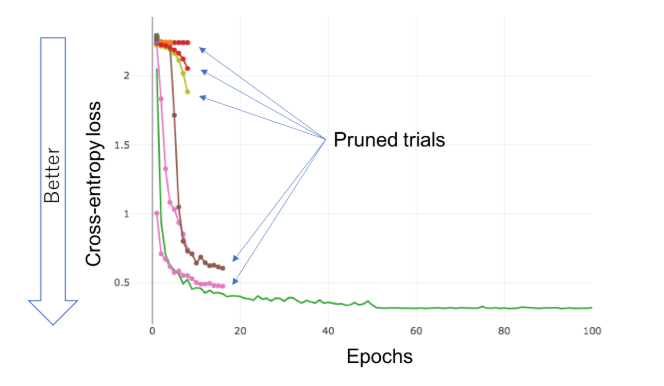

In [0]:
num_rounds = 15000
early_stop = 750
seed = 0
folds=8
cat_features = ['P0_species','P1_species','map']

In [0]:
# Referred https://github.com/pfnet/optuna/blob/master/examples/pruning/lightgbm_integration.py

def fit_lgbm_with_pruning(trial, train, val, devices=(-1,), seed=seed, cat_features=cat_features, num_rounds=num_rounds,early_stop=early_stop):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'auc'
    params = {
        #'num_leaves': trial.suggest_int('num_leaves', 16,1e+4),     # 16~128 정도
        'objective': 'binary',

        'max_depth': trial.suggest_int('max_depth', 8,30),  # 8,30
        #'learning_rate': trial.suggest_discrete_uniform('learning_rate', 9e-3, 1e-2, 1e-5),   
        'learning_rate': trial.suggest_uniform('learning_rate',8e-3,0.11),
        "boosting": "gbdt",#'dart','goss',

        'lambda_l1': trial.suggest_uniform('lambda_l1', 0, 25),   # 1~2     #'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_uniform('lambda_l2', 0, 35),   # 3~6   #'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),

        #"bagging_freq": 5,
        "bagging_fraction": trial.suggest_discrete_uniform('bagging_fraction', 0.05, 0.5, 0.05), 
        "feature_fraction": trial.suggest_discrete_uniform('feature_fraction', 0.05, 0.25, 0.05),  # 0.1, 0.5
        #"bagging_fraction": trial.suggest_uniform('bagging_fraction', 0.35, 0.35),
        #"feature_fraction": trial.suggest_uniform('feature_fraction', 0.4, 0.4),  

        "metric": metric,
        "verbosity": -1,
    }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed
    early_stop = early_stop
    verbose_eval = 500  # 적합을 할 때, 과정을 보여줄 epoch 단위수 (500으로 하면 500:auc, 1000:auc, 1500:auc, ... 이렇게 보여줌)

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features
                          )
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features
                          )
    watchlist = [d_train, d_valid]

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'auc', valid_name='valid_1')    
    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop,
                      callbacks=[pruning_callback])

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration,cat_features=cat_features)
    print('#'*25,'이번 trial 중 가장 좋은 스코어는 다음과 같습니다.','#'*25)
    print('best_score', model.best_score)
    log = {'train/auc': model.best_score['training']['auc'],
           'valid/auc': model.best_score['valid_1']['auc']}
    return model, y_pred_valid, log

def objective_with_prune(trial: Trial, fast_check=True,seed=seed,folds=folds,cat_features=cat_features):
    """This method is completely same with previous `objective` method except calling `fit_lgbm_with_pruning`"""
    folds = folds
    seed = seed
    shuffle = True
    kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

    X_train, y_train = new_x,y
    y_valid_pred_total = np.zeros(X_train.shape[0])
    gc.collect()
    print('='*100)
    print('='*100)
    cat_features = cat_features
    print('cat_features : ', cat_features)

    models0 = []
    valid_score = 0
    for train_idx, valid_idx in kf.split(X_train, y_train):
        train_data = X_train.iloc[train_idx,:], y_train[train_idx]
        valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

        print('train', len(train_idx), 'valid', len(valid_idx))
        model, y_pred_valid, log = fit_lgbm_with_pruning(trial, train_data, valid_data, cat_features=cat_features,
                                                         num_rounds=num_rounds)
        y_valid_pred_total[valid_idx] = y_pred_valid
        models0.append(model)
        gc.collect()
        valid_score += log["valid/auc"]
        if fast_check:
            break
    valid_score /= len(models0)
    return valid_score

In [0]:
#study = optuna.create_study(direction='maximize')   # auc니까 최대를 목표로
#study.optimize(objective_with_prune, n_trials=50)
#study.optimize(lambda trial: objective_with_prune(trial, arg0=1, arg1=2), n_trials=100)

study = optuna.create_study(direction='maximize',pruner=optuna.pruners.MedianPruner(n_warmup_steps=20)) # 20차례는 적어도 지켜보고(warmup), 중앙값을 확인해 Prune 할지 결정
study.optimize(objective_with_prune, n_trials=150)

cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.826087	valid_1's auc: 0.727954
[1000]	training's auc: 0.883687	valid_1's auc: 0.735314
[1500]	training's auc: 0.919408	valid_1's auc: 0.737426
[2000]	training's auc: 0.942599	valid_1's auc: 0.737644
[2500]	training's auc: 0.958299	valid_1's auc: 0.736577
Early stopping, best iteration is:
[1828]	training's auc: 0.935692	valid_1's auc: 0.738086
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9356924507020679}, 'valid_1': {'auc': 0.7380863869111562}})


[I 2020-04-13 10:59:03,232] Finished trial#0 resulted in value: 0.7380863869111562. Current best value is 0.7380863869111562 with parameters: {'max_depth': 15, 'learning_rate': 0.03570553184429619, 'lambda_l1': 17.130668681213745, 'lambda_l2': 30.05029045351807, 'bagging_fraction': 0.15000000000000002, 'feature_fraction': 0.05}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.856547	valid_1's auc: 0.732494
[1000]	training's auc: 0.917724	valid_1's auc: 0.737191
[1500]	training's auc: 0.95074	valid_1's auc: 0.737488
Early stopping, best iteration is:
[1071]	training's auc: 0.923822	valid_1's auc: 0.737853
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9238218216967813}, 'valid_1': {'auc': 0.7378530690532751}})


[I 2020-04-13 11:02:48,262] Finished trial#1 resulted in value: 0.7378530690532751. Current best value is 0.7380863869111562 with parameters: {'max_depth': 15, 'learning_rate': 0.03570553184429619, 'lambda_l1': 17.130668681213745, 'lambda_l2': 30.05029045351807, 'bagging_fraction': 0.15000000000000002, 'feature_fraction': 0.05}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.852459	valid_1's auc: 0.731966
[1000]	training's auc: 0.913903	valid_1's auc: 0.738122
[1500]	training's auc: 0.948186	valid_1's auc: 0.738409
[2000]	training's auc: 0.967862	valid_1's auc: 0.738335
Early stopping, best iteration is:
[1590]	training's auc: 0.952583	valid_1's auc: 0.7387
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9525825521749844}, 'valid_1': {'auc': 0.7387000959026199}})


[I 2020-04-13 11:07:30,459] Finished trial#2 resulted in value: 0.7387000959026199. Current best value is 0.7387000959026199 with parameters: {'max_depth': 23, 'learning_rate': 0.04391793807385927, 'lambda_l1': 13.617918595018196, 'lambda_l2': 15.991831971580652, 'bagging_fraction': 0.3, 'feature_fraction': 0.05}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.926806	valid_1's auc: 0.730921
[1000]	training's auc: 0.975601	valid_1's auc: 0.729159
Early stopping, best iteration is:
[616]	training's auc: 0.944003	valid_1's auc: 0.732039
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9440033905581708}, 'valid_1': {'auc': 0.7320389303638538}})


[I 2020-04-13 11:10:19,489] Finished trial#3 resulted in value: 0.7320389303638538. Current best value is 0.7387000959026199 with parameters: {'max_depth': 23, 'learning_rate': 0.04391793807385927, 'lambda_l1': 13.617918595018196, 'lambda_l2': 15.991831971580652, 'bagging_fraction': 0.3, 'feature_fraction': 0.05}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.836748	valid_1's auc: 0.726505
[1000]	training's auc: 0.898913	valid_1's auc: 0.733516
[1500]	training's auc: 0.93545	valid_1's auc: 0.735925
[2000]	training's auc: 0.958343	valid_1's auc: 0.735718
[2500]	training's auc: 0.973085	valid_1's auc: 0.736228
[3000]	training's auc: 0.982312	valid_1's auc: 0.735453
Early stopping, best iteration is:
[2308]	training's auc: 0.968108	valid_1's auc: 0.736527
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9681079503191132}, 'valid_1': {'auc': 0.7365265291045813}})


[I 2020-04-13 11:17:49,072] Finished trial#4 resulted in value: 0.7365265291045813. Current best value is 0.7387000959026199 with parameters: {'max_depth': 23, 'learning_rate': 0.04391793807385927, 'lambda_l1': 13.617918595018196, 'lambda_l2': 15.991831971580652, 'bagging_fraction': 0.3, 'feature_fraction': 0.05}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 11:18:59,661] Setting status of trial#5 as TrialState.PRUNED. Trial was pruned at iteration 314.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 11:20:27,056] Setting status of trial#6 as TrialState.PRUNED. Trial was pruned at iteration 475.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.870992	valid_1's auc: 0.733061
[1000]	training's auc: 0.932558	valid_1's auc: 0.736137
[1500]	training's auc: 0.963183	valid_1's auc: 0.736386


[I 2020-04-13 11:23:58,593] Setting status of trial#7 as TrialState.PRUNED. Trial was pruned at iteration 1536.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.948769	valid_1's auc: 0.737385
[1000]	training's auc: 0.989777	valid_1's auc: 0.740405
[1500]	training's auc: 0.998077	valid_1's auc: 0.740516
[2000]	training's auc: 0.999638	valid_1's auc: 0.740929
[2500]	training's auc: 0.99993	valid_1's auc: 0.741205
Early stopping, best iteration is:
[1848]	training's auc: 0.999398	valid_1's auc: 0.741607
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9993975754813549}, 'valid_1': {'auc': 0.7416073346865882}})


[I 2020-04-13 11:30:02,555] Finished trial#8 resulted in value: 0.7416073346865882. Current best value is 0.7416073346865882 with parameters: {'max_depth': 17, 'learning_rate': 0.06605171438283344, 'lambda_l1': 1.6915047406243415, 'lambda_l2': 4.0631939981020775, 'bagging_fraction': 0.4, 'feature_fraction': 0.2}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 11:30:28,432] Setting status of trial#9 as TrialState.PRUNED. Trial was pruned at iteration 27.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.956793	valid_1's auc: 0.738276
[1000]	training's auc: 0.992403	valid_1's auc: 0.741063
[1500]	training's auc: 0.998803	valid_1's auc: 0.740618
[2000]	training's auc: 0.999815	valid_1's auc: 0.741571
[2500]	training's auc: 0.999978	valid_1's auc: 0.742203
Early stopping, best iteration is:
[2091]	training's auc: 0.999883	valid_1's auc: 0.742385
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9998827603807647}, 'valid_1': {'auc': 0.7423850608795253}})


[I 2020-04-13 11:37:42,214] Finished trial#10 resulted in value: 0.7423850608795253. Current best value is 0.7423850608795253 with parameters: {'max_depth': 8, 'learning_rate': 0.08115698207401971, 'lambda_l1': 0.8319463267193498, 'lambda_l2': 8.650713097889698, 'bagging_fraction': 0.05, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.952539	valid_1's auc: 0.737722
[1000]	training's auc: 0.991323	valid_1's auc: 0.739174
[1500]	training's auc: 0.998477	valid_1's auc: 0.736248
Early stopping, best iteration is:
[915]	training's auc: 0.988354	valid_1's auc: 0.7397
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9883543972097385}, 'valid_1': {'auc': 0.739700295840944}})


[I 2020-04-13 11:42:15,373] Finished trial#11 resulted in value: 0.739700295840944. Current best value is 0.7423850608795253 with parameters: {'max_depth': 8, 'learning_rate': 0.08115698207401971, 'lambda_l1': 0.8319463267193498, 'lambda_l2': 8.650713097889698, 'bagging_fraction': 0.05, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 11:43:51,971] Setting status of trial#12 as TrialState.PRUNED. Trial was pruned at iteration 477.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.942118	valid_1's auc: 0.738588
[1000]	training's auc: 0.986823	valid_1's auc: 0.740966
[1500]	training's auc: 0.996897	valid_1's auc: 0.740474
[2000]	training's auc: 0.999281	valid_1's auc: 0.738623
Early stopping, best iteration is:
[1265]	training's auc: 0.993928	valid_1's auc: 0.742055
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9939276010982878}, 'valid_1': {'auc': 0.7420546543269704}})


[I 2020-04-13 11:49:17,616] Finished trial#13 resulted in value: 0.7420546543269704. Current best value is 0.7423850608795253 with parameters: {'max_depth': 8, 'learning_rate': 0.08115698207401971, 'lambda_l1': 0.8319463267193498, 'lambda_l2': 8.650713097889698, 'bagging_fraction': 0.05, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.954695	valid_1's auc: 0.739361
[1000]	training's auc: 0.99192	valid_1's auc: 0.737062
Early stopping, best iteration is:
[503]	training's auc: 0.955184	valid_1's auc: 0.739595
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9551840733248139}, 'valid_1': {'auc': 0.7395952435011572}})


[I 2020-04-13 11:52:58,651] Finished trial#14 resulted in value: 0.7395952435011572. Current best value is 0.7423850608795253 with parameters: {'max_depth': 8, 'learning_rate': 0.08115698207401971, 'lambda_l1': 0.8319463267193498, 'lambda_l2': 8.650713097889698, 'bagging_fraction': 0.05, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 11:53:23,862] Setting status of trial#15 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.962132	valid_1's auc: 0.733847


[I 2020-04-13 11:55:12,207] Setting status of trial#16 as TrialState.PRUNED. Trial was pruned at iteration 501.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.944688	valid_1's auc: 0.734939


[I 2020-04-13 11:57:01,985] Setting status of trial#17 as TrialState.PRUNED. Trial was pruned at iteration 501.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.949054	valid_1's auc: 0.737141
[1000]	training's auc: 0.989592	valid_1's auc: 0.737838


[I 2020-04-13 12:00:22,295] Setting status of trial#18 as TrialState.PRUNED. Trial was pruned at iteration 1066.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.955819	valid_1's auc: 0.737928
[1000]	training's auc: 0.993	valid_1's auc: 0.73909
[1500]	training's auc: 0.998895	valid_1's auc: 0.739945
[2000]	training's auc: 0.999819	valid_1's auc: 0.739003
Early stopping, best iteration is:
[1322]	training's auc: 0.997757	valid_1's auc: 0.740774
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9977567601945256}, 'valid_1': {'auc': 0.7407740324171188}})


[I 2020-04-13 12:05:58,450] Finished trial#19 resulted in value: 0.7407740324171188. Current best value is 0.7423850608795253 with parameters: {'max_depth': 8, 'learning_rate': 0.08115698207401971, 'lambda_l1': 0.8319463267193498, 'lambda_l2': 8.650713097889698, 'bagging_fraction': 0.05, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:07:45,362] Setting status of trial#20 as TrialState.PRUNED. Trial was pruned at iteration 432.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:08:10,547] Setting status of trial#21 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:08:35,544] Setting status of trial#22 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:09:00,555] Setting status of trial#23 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:09:25,179] Setting status of trial#24 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:09:49,661] Setting status of trial#25 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:11:44,773] Setting status of trial#26 as TrialState.PRUNED. Trial was pruned at iteration 500.


[500]	training's auc: 0.948823	valid_1's auc: 0.73726
cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:13:05,677] Setting status of trial#27 as TrialState.PRUNED. Trial was pruned at iteration 326.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:13:30,877] Setting status of trial#28 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:15:15,347] Setting status of trial#29 as TrialState.PRUNED. Trial was pruned at iteration 446.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:15:40,352] Setting status of trial#30 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:16:05,424] Setting status of trial#31 as TrialState.PRUNED. Trial was pruned at iteration 22.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:17:32,244] Setting status of trial#32 as TrialState.PRUNED. Trial was pruned at iteration 336.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:17:57,200] Setting status of trial#33 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:18:22,046] Setting status of trial#34 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:18:47,218] Setting status of trial#35 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:20:22,378] Setting status of trial#36 as TrialState.PRUNED. Trial was pruned at iteration 385.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:21:16,842] Setting status of trial#37 as TrialState.PRUNED. Trial was pruned at iteration 165.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:21:41,745] Setting status of trial#38 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:22:06,540] Setting status of trial#39 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:22:31,240] Setting status of trial#40 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:22:56,392] Setting status of trial#41 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:23:22,605] Setting status of trial#42 as TrialState.PRUNED. Trial was pruned at iteration 27.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:23:50,599] Setting status of trial#43 as TrialState.PRUNED. Trial was pruned at iteration 35.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.968328	valid_1's auc: 0.73934
[1000]	training's auc: 0.996428	valid_1's auc: 0.739189
Early stopping, best iteration is:
[677]	training's auc: 0.985052	valid_1's auc: 0.740775
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9850524637269096}, 'valid_1': {'auc': 0.7407747101741496}})


[I 2020-04-13 12:28:23,946] Finished trial#44 resulted in value: 0.7407747101741496. Current best value is 0.7423850608795253 with parameters: {'max_depth': 8, 'learning_rate': 0.08115698207401971, 'lambda_l1': 0.8319463267193498, 'lambda_l2': 8.650713097889698, 'bagging_fraction': 0.05, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.964003	valid_1's auc: 0.739009
[1000]	training's auc: 0.994569	valid_1's auc: 0.739945
[1500]	training's auc: 0.999168	valid_1's auc: 0.739461
Early stopping, best iteration is:
[931]	training's auc: 0.992776	valid_1's auc: 0.740522
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.992776289228163}, 'valid_1': {'auc': 0.7405220762408884}})


[I 2020-04-13 12:33:52,121] Finished trial#45 resulted in value: 0.7405220762408884. Current best value is 0.7423850608795253 with parameters: {'max_depth': 8, 'learning_rate': 0.08115698207401971, 'lambda_l1': 0.8319463267193498, 'lambda_l2': 8.650713097889698, 'bagging_fraction': 0.05, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:35:19,814] Setting status of trial#46 as TrialState.PRUNED. Trial was pruned at iteration 320.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.961486	valid_1's auc: 0.737414


[I 2020-04-13 12:38:10,829] Setting status of trial#47 as TrialState.PRUNED. Trial was pruned at iteration 754.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:38:37,715] Setting status of trial#48 as TrialState.PRUNED. Trial was pruned at iteration 26.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:39:02,756] Setting status of trial#49 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:40:13,384] Setting status of trial#50 as TrialState.PRUNED. Trial was pruned at iteration 220.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.971507	valid_1's auc: 0.737471


[I 2020-04-13 12:42:53,915] Setting status of trial#51 as TrialState.PRUNED. Trial was pruned at iteration 690.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.96154	valid_1's auc: 0.739534
[1000]	training's auc: 0.994108	valid_1's auc: 0.738801
[1500]	training's auc: 0.99909	valid_1's auc: 0.73713
Early stopping, best iteration is:
[908]	training's auc: 0.991649	valid_1's auc: 0.739935
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9916493394660105}, 'valid_1': {'auc': 0.73993547753066}})


[I 2020-04-13 12:48:17,165] Finished trial#52 resulted in value: 0.73993547753066. Current best value is 0.7423850608795253 with parameters: {'max_depth': 8, 'learning_rate': 0.08115698207401971, 'lambda_l1': 0.8319463267193498, 'lambda_l2': 8.650713097889698, 'bagging_fraction': 0.05, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:48:42,280] Setting status of trial#53 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:49:40,418] Setting status of trial#54 as TrialState.PRUNED. Trial was pruned at iteration 171.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:50:05,366] Setting status of trial#55 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:50:30,490] Setting status of trial#56 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:50:55,522] Setting status of trial#57 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:51:20,652] Setting status of trial#58 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:52:14,397] Setting status of trial#59 as TrialState.PRUNED. Trial was pruned at iteration 139.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:53:33,893] Setting status of trial#60 as TrialState.PRUNED. Trial was pruned at iteration 283.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:54:43,252] Setting status of trial#61 as TrialState.PRUNED. Trial was pruned at iteration 215.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:55:35,850] Setting status of trial#62 as TrialState.PRUNED. Trial was pruned at iteration 137.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:57:38,197] Setting status of trial#63 as TrialState.PRUNED. Trial was pruned at iteration 493.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:58:03,840] Setting status of trial#64 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 12:58:28,940] Setting status of trial#65 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.955317	valid_1's auc: 0.739492
[1000]	training's auc: 0.991777	valid_1's auc: 0.739914
[1500]	training's auc: 0.998649	valid_1's auc: 0.738985
Early stopping, best iteration is:
[805]	training's auc: 0.984046	valid_1's auc: 0.740588
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9840455715116107}, 'valid_1': {'auc': 0.7405884964299149}})


[I 2020-04-13 13:03:36,796] Finished trial#66 resulted in value: 0.7405884964299149. Current best value is 0.7423850608795253 with parameters: {'max_depth': 8, 'learning_rate': 0.08115698207401971, 'lambda_l1': 0.8319463267193498, 'lambda_l2': 8.650713097889698, 'bagging_fraction': 0.05, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.96786	valid_1's auc: 0.738934
[1000]	training's auc: 0.996398	valid_1's auc: 0.739003
Early stopping, best iteration is:
[588]	training's auc: 0.977846	valid_1's auc: 0.740282
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9778463969853002}, 'valid_1': {'auc': 0.7402818113734407}})


[I 2020-04-13 13:07:53,277] Finished trial#67 resulted in value: 0.7402818113734407. Current best value is 0.7423850608795253 with parameters: {'max_depth': 8, 'learning_rate': 0.08115698207401971, 'lambda_l1': 0.8319463267193498, 'lambda_l2': 8.650713097889698, 'bagging_fraction': 0.05, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:08:18,850] Setting status of trial#68 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:08:44,246] Setting status of trial#69 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:09:09,475] Setting status of trial#70 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:10:28,105] Setting status of trial#71 as TrialState.PRUNED. Trial was pruned at iteration 258.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:10:55,438] Setting status of trial#72 as TrialState.PRUNED. Trial was pruned at iteration 27.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:11:20,600] Setting status of trial#73 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:12:26,721] Setting status of trial#74 as TrialState.PRUNED. Trial was pruned at iteration 202.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:14:24,030] Setting status of trial#75 as TrialState.PRUNED. Trial was pruned at iteration 468.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:14:49,604] Setting status of trial#76 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:15:14,908] Setting status of trial#77 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:15:40,738] Setting status of trial#78 as TrialState.PRUNED. Trial was pruned at iteration 24.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:16:06,122] Setting status of trial#79 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:16:31,232] Setting status of trial#80 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:17:55,334] Setting status of trial#81 as TrialState.PRUNED. Trial was pruned at iteration 273.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.962798	valid_1's auc: 0.739675
[1000]	training's auc: 0.994027	valid_1's auc: 0.74276
[1500]	training's auc: 0.999087	valid_1's auc: 0.74257
Early stopping, best iteration is:
[989]	training's auc: 0.993758	valid_1's auc: 0.742854
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9937577129099215}, 'valid_1': {'auc': 0.7428540687448957}})


[I 2020-04-13 13:23:57,915] Finished trial#82 resulted in value: 0.7428540687448957. Current best value is 0.7428540687448957 with parameters: {'max_depth': 11, 'learning_rate': 0.09026483190840161, 'lambda_l1': 0.05352901099746288, 'lambda_l2': 19.244620647854855, 'bagging_fraction': 0.05, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:24:25,682] Setting status of trial#83 as TrialState.PRUNED. Trial was pruned at iteration 25.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:25:07,852] Setting status of trial#84 as TrialState.PRUNED. Trial was pruned at iteration 92.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:26:36,968] Setting status of trial#85 as TrialState.PRUNED. Trial was pruned at iteration 293.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:27:04,384] Setting status of trial#86 as TrialState.PRUNED. Trial was pruned at iteration 29.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:27:30,117] Setting status of trial#87 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.968094	valid_1's auc: 0.736993


[I 2020-04-13 13:29:38,956] Setting status of trial#88 as TrialState.PRUNED. Trial was pruned at iteration 500.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:30:05,181] Setting status of trial#89 as TrialState.PRUNED. Trial was pruned at iteration 22.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:30:30,822] Setting status of trial#90 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:31:23,727] Setting status of trial#91 as TrialState.PRUNED. Trial was pruned at iteration 131.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:32:06,185] Setting status of trial#92 as TrialState.PRUNED. Trial was pruned at iteration 93.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:32:49,534] Setting status of trial#93 as TrialState.PRUNED. Trial was pruned at iteration 93.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:34:39,093] Setting status of trial#94 as TrialState.PRUNED. Trial was pruned at iteration 403.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:35:06,945] Setting status of trial#95 as TrialState.PRUNED. Trial was pruned at iteration 30.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:35:34,379] Setting status of trial#96 as TrialState.PRUNED. Trial was pruned at iteration 29.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:35:59,686] Setting status of trial#97 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:36:50,929] Setting status of trial#98 as TrialState.PRUNED. Trial was pruned at iteration 128.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:38:30,853] Setting status of trial#99 as TrialState.PRUNED. Trial was pruned at iteration 332.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:38:56,865] Setting status of trial#100 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:39:22,042] Setting status of trial#101 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:39:47,296] Setting status of trial#102 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:40:12,662] Setting status of trial#103 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:40:38,175] Setting status of trial#104 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:41:05,966] Setting status of trial#105 as TrialState.PRUNED. Trial was pruned at iteration 29.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:41:31,352] Setting status of trial#106 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:42:41,914] Setting status of trial#107 as TrialState.PRUNED. Trial was pruned at iteration 247.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:44:26,965] Setting status of trial#108 as TrialState.PRUNED. Trial was pruned at iteration 398.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:44:52,899] Setting status of trial#109 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.965175	valid_1's auc: 0.740157
[1000]	training's auc: 0.995215	valid_1's auc: 0.737205
Early stopping, best iteration is:
[500]	training's auc: 0.965175	valid_1's auc: 0.740157
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9651752033876427}, 'valid_1': {'auc': 0.7401571040797584}})


[I 2020-04-13 13:49:34,702] Finished trial#110 resulted in value: 0.7401571040797584. Current best value is 0.7428540687448957 with parameters: {'max_depth': 11, 'learning_rate': 0.09026483190840161, 'lambda_l1': 0.05352901099746288, 'lambda_l2': 19.244620647854855, 'bagging_fraction': 0.05, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:51:27,436] Setting status of trial#111 as TrialState.PRUNED. Trial was pruned at iteration 379.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:51:53,549] Setting status of trial#112 as TrialState.PRUNED. Trial was pruned at iteration 22.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:52:58,542] Setting status of trial#113 as TrialState.PRUNED. Trial was pruned at iteration 173.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 13:54:26,802] Setting status of trial#114 as TrialState.PRUNED. Trial was pruned at iteration 269.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.959424	valid_1's auc: 0.738668
[1000]	training's auc: 0.993086	valid_1's auc: 0.739898
[1500]	training's auc: 0.99885	valid_1's auc: 0.738517
Early stopping, best iteration is:
[1040]	training's auc: 0.993952	valid_1's auc: 0.741009
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9939522916763508}, 'valid_1': {'auc': 0.7410092141068348}})


[I 2020-04-13 14:00:46,804] Finished trial#115 resulted in value: 0.7410092141068348. Current best value is 0.7428540687448957 with parameters: {'max_depth': 11, 'learning_rate': 0.09026483190840161, 'lambda_l1': 0.05352901099746288, 'lambda_l2': 19.244620647854855, 'bagging_fraction': 0.05, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:01:13,190] Setting status of trial#116 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:01:41,389] Setting status of trial#117 as TrialState.PRUNED. Trial was pruned at iteration 29.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:03:17,791] Setting status of trial#118 as TrialState.PRUNED. Trial was pruned at iteration 303.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:04:10,478] Setting status of trial#119 as TrialState.PRUNED. Trial was pruned at iteration 126.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:04:54,301] Setting status of trial#120 as TrialState.PRUNED. Trial was pruned at iteration 94.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:05:47,193] Setting status of trial#121 as TrialState.PRUNED. Trial was pruned at iteration 126.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:07:20,100] Setting status of trial#122 as TrialState.PRUNED. Trial was pruned at iteration 286.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:07:48,555] Setting status of trial#123 as TrialState.PRUNED. Trial was pruned at iteration 29.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:08:14,277] Setting status of trial#124 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:08:57,189] Setting status of trial#125 as TrialState.PRUNED. Trial was pruned at iteration 88.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:10:37,646] Setting status of trial#126 as TrialState.PRUNED. Trial was pruned at iteration 354.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.956624	valid_1's auc: 0.738828


[I 2020-04-13 14:13:12,972] Setting status of trial#127 as TrialState.PRUNED. Trial was pruned at iteration 576.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:13:39,052] Setting status of trial#128 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:14:45,745] Setting status of trial#129 as TrialState.PRUNED. Trial was pruned at iteration 190.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:15:12,138] Setting status of trial#130 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:15:37,715] Setting status of trial#131 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:16:25,258] Setting status of trial#132 as TrialState.PRUNED. Trial was pruned at iteration 111.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:16:53,653] Setting status of trial#133 as TrialState.PRUNED. Trial was pruned at iteration 30.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:18:07,775] Setting status of trial#134 as TrialState.PRUNED. Trial was pruned at iteration 211.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:19:40,265] Setting status of trial#135 as TrialState.PRUNED. Trial was pruned at iteration 307.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:20:07,791] Setting status of trial#136 as TrialState.PRUNED. Trial was pruned at iteration 27.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:20:33,346] Setting status of trial#137 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:20:59,189] Setting status of trial#138 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:21:27,021] Setting status of trial#139 as TrialState.PRUNED. Trial was pruned at iteration 29.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:21:52,900] Setting status of trial#140 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:22:18,100] Setting status of trial#141 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:22:43,700] Setting status of trial#142 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:23:09,149] Setting status of trial#143 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:23:34,308] Setting status of trial#144 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:23:59,288] Setting status of trial#145 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:24:24,372] Setting status of trial#146 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:24:50,673] Setting status of trial#147 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:25:16,367] Setting status of trial#148 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-13 14:25:41,941] Setting status of trial#149 as TrialState.PRUNED. Trial was pruned at iteration 21.


In [0]:
new_x.shape

(38872, 7720)

## 1. lr & max_depth & row_samp & col_samp 튜닝

In [0]:
# 8 Fold 
# 0.748792406410226
# {'max_depth': 26, 'learning_rate': 0.00989, 'lambda_l1': 0.5837677257524115, 'lambda_l2': 2.571054121936942, 'bagging_fraction': 0.8, 'feature_fraction': 0.05}
# n_feature = 7720
# Check study history to get best hyperparameters
print('Best trial: score {}, params {}'.format(study.best_value, study.best_params))

#trials_df = study.trials_dataframe()
#trials_df


Best trial: score 0.7452304543344257, params {'max_depth': 12, 'learning_rate': 0.026530522850076628, 'lambda_l1': 2.1926797335917727, 'lambda_l2': 0.007593193782932772, 'bagging_fraction': 0.55, 'feature_fraction': 0.1}


In [0]:
# 8 Fold
# n_feature = 4948
# Check study history to get best hyperparameters
print('Best trial: score {}, params {}'.format(study.best_value, study.best_params))

#trials_df = study.trials_dataframe()
#trials_df


Best trial: score 0.7465256480204412, params {'max_depth': 25, 'learning_rate': 0.026813415309555645, 'lambda_l1': 1.1024606492004492, 'lambda_l2': 1.831117696954427, 'bagging_fraction': 0.1, 'feature_fraction': 0.25}


In [0]:
### Visualize study history to analayze the hyperparams-performance relationship

optuna.visualization.plot_optimization_history(study)   #Optimization history
#optuna.visualization.plot_intermediate_values(study)   #Visualize pruning history
#optuna.visualization.plot_slice(study)    #Visualize plot slice
#optuna.visualization.plot_contour(study)    #Visualize plot contour (변수들 pairwise plot => 두 모수의 상호작용효과 확인)
#optuna.visualization.plot_parallel_coordinate(study)   #Visualize parallel_coordinate

#출처 : https://github.com/pfnet/optuna/tree/master/examples/visualization


In [0]:
### Visualize study history to analayze the hyperparams-performance relationship

#optuna.visualization.plot_optimization_history(study)   #Optimization history
optuna.visualization.plot_intermediate_values(study)   #Visualize pruning history
#optuna.visualization.plot_slice(study)    #Visualize plot slice
#optuna.visualization.plot_contour(study)    #Visualize plot contour (변수들 pairwise plot => 두 모수의 상호작용효과 확인)
#optuna.visualization.plot_parallel_coordinate(study)   #Visualize parallel_coordinate

#출처 : https://github.com/pfnet/optuna/tree/master/examples/visualization


# 최적화된 모수의 모델 적합시키고 변수중요도 Plot 확인, pred값 생성

In [0]:
print(new_x.shape)

(38872, 7720)


In [0]:
def objective(trial: Trial, fast_check=True,  return_info=False,seed=seed,folds=folds,cat_features = cat_features):
    folds = folds
    seed = seed
    shuffle = True
    kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

    X_train, y_train = new_x,y
    y_valid_pred_total = np.zeros(X_train.shape[0])
    gc.collect()

    cat_features = cat_features
    print('cat_features', cat_features)

    models = []
    valid_score = 0
    for train_idx, valid_idx in kf.split(X_train, y_train):
        train_data = X_train.iloc[train_idx,:], y_train[train_idx]
        valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

        print('train', len(train_idx), 'valid', len(valid_idx))
    #     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
        model, y_pred_valid, log = fit_lgbm(trial, train_data, valid_data, cat_features=cat_features,
                                            num_rounds=num_rounds)
        y_valid_pred_total[valid_idx] = y_pred_valid
        models.append(model)
        gc.collect()
        valid_score += log["valid/auc"]
        if fast_check:
            break
    valid_score /= len(models)
    if return_info:
        return valid_score, models, y_pred_valid, y_train
    else:
        return valid_score

def fit_lgbm(trial, train, val, devices=(-1,), seed=seed, num_rounds=num_rounds,early_stop=early_stop,cat_features = cat_features):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'auc'
    params = {
        #'num_leaves': trial.suggest_int('num_leaves', 8, 1024),
        'objective': 'binary',
        'max_depth': trial.suggest_int('max_depth', 2, 30),
        'learning_rate': trial.suggest_uniform('learning_rate', 1e-10, 0.1),
        "boosting": "gbdt",#'dart','goss'
        #'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        #'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'lambda_l1': trial.suggest_uniform('lambda_l1', 0, 50), 
        'lambda_l2': trial.suggest_uniform('lambda_l2', 0, 50),
        #"bagging_freq": 5,
        "bagging_fraction": trial.suggest_uniform('bagging_fraction', 0, 1),
        "feature_fraction": trial.suggest_uniform('feature_fraction', 0, 1),
        "metric": metric,
        "verbosity": -1,
    }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = early_stop
    verbose_eval = 500

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/auc': model.best_score['training']['auc'],
           'valid/auc': model.best_score['valid_1']['auc']}
    return model, y_pred_valid, log

####################################### 모델 불러오기 ###################################
valid_score, models0, y_pred_valid, y_train = objective(optuna.trial.FixedTrial(study.best_params), fast_check=False, return_info=True   )

#best_params = {'max_depth': 26, 'learning_rate': 0.00989, 'lambda_l1': 0.5837677257524115, 'lambda_l2': 2.571054121936942, 'bagging_fraction': 0.8, 'feature_fraction': 0.05}
#valid_score, models0, y_pred_valid, y_train = objective(optuna.trial.FixedTrial(best_params), fast_check=False, return_info=True   )


cat_features ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.784573	valid_1's auc: 0.714734
[1000]	training's auc: 0.833317	valid_1's auc: 0.728746
[1500]	training's auc: 0.870109	valid_1's auc: 0.735349
[2000]	training's auc: 0.898148	valid_1's auc: 0.739033
[2500]	training's auc: 0.919495	valid_1's auc: 0.74151
[3000]	training's auc: 0.936299	valid_1's auc: 0.743095
[3500]	training's auc: 0.949354	valid_1's auc: 0.744365
[4000]	training's auc: 0.959634	valid_1's auc: 0.745425
[4500]	training's auc: 0.967735	valid_1's auc: 0.745861
[5000]	training's auc: 0.974225	valid_1's auc: 0.746103
[5500]	training's auc: 0.979382	valid_1's auc: 0.74707
[6000]	training's auc: 0.983498	valid_1's auc: 0.74742
[6500]	training's auc: 0.986893	valid_1's auc: 0.747739
[7000]	training's auc: 0.989571	valid_1's auc: 0.748208
[7500]	training's auc: 0.991691	valid_1's auc: 0.748575
[8000]	training

In [0]:
new_x.shape

(38872, 7720)

In [0]:
import matplotlib.pyplot as plt

################################ 변수중요도 플랏 ############################
def plot_feature_importance(model):
    importance_df = pd.DataFrame(model.feature_importance(),
                                 index=x.columns,
                                 columns=['importance']).iloc[:200,:].sort_values('importance')
    fig, ax = plt.subplots(figsize=(16, 70))
    importance_df.plot.barh(ax=ax)
    fig.show()
plot_feature_importance(models0[1])
#plot_feature_importance(models1[1])
#plot_feature_importance(models2[1])

## 제출 파일 생성

In [0]:
print(x.drop(bad_features,axis=1).drop(rf_bad_features,axis=1).copy().shape)


(38872, 4949)


In [0]:
test_Ability_Raw.index = no_missing_test.index
test_Ability.index = no_missing_test.index
test_Selection_Raw.index =  no_missing_test.index
test_Selection.index = no_missing_test.index
test_Right_Raw.index =  no_missing_test.index
test_Right.index = no_missing_test.index


In [0]:

test_X = pd.concat([no_missing_test,test_Ability_Raw,test_Ability,
                    test_Selection_Raw,test_Selection,
                    test_Right_Raw, test_Right],axis=1).drop(bad_features,axis=1).drop(rf_bad_features,axis=1).copy()
del test_Ability_Raw,test_Ability,test_Selection_Raw,test_Selection,test_Right_Raw, test_Right

print(test_X.shape)
preds = []
for model in models0:
    pred = model.predict(test_X)#predict_proba    [:, 1]
    preds.append(pred)
pred = np.mean(preds, axis=0)

submission = pd.read_csv('sample_submission.csv', index_col=0)
submission['winner'] = submission['winner'] + pred
submission.to_csv('제출/모델링41_8FOLD_RF변수선택후_Permutation_seed0.csv', encoding='utf8')
submission.head()

(16787, 7720)


winner
game_id          
38872    0.600783
38873    0.717249
38874    0.488208
38875    0.177228
38876    0.640489

## 제출파일 중에 좋은것들 평균내보기

In [0]:
sub = pd.read_csv('sample_submission.csv', index_col=0)

data1 = pd.read_csv('제출/모델링40_8FOLD_permutation후에_RF변수선택_Raw_Ability Selection Right.csv', encoding = 'utf8')
data2 = pd.read_csv('제출/모델링38_8FOLD늘림_RawAbility_RawSelection_RawRight_colname구분_데이터전체에permutation.csv', encoding = 'utf8')


mean_pred = (data1['winner']+data2['winner'])/2
mean_pred.index = sub.index
sub['winner'] = sub['winner'] + mean_pred
sub.to_csv('제출/40과38평균내기.csv',encoding='utf8')
sub.head()

winner
game_id          
38872    0.422928
38873    0.674959
38874    0.393806
38875    0.145818
38876    0.619864